# Settings

## Constant

In [1]:
import pytz
import os


DEFAULT_TZ = pytz.FixedOffset(540)  # GMT+09:00; Asia/Seoul

PATH_DATA = "/var/nfs_share/D#1"
PATH_ESM = os.path.join(PATH_DATA, 'EsmResponse.csv')
PATH_PARTICIPANT = os.path.join(PATH_DATA, 'UserInfo.csv')
PATH_SENSOR = os.path.join(PATH_DATA, 'Sensor')

PATH_INTERMEDIATE = '/var/nfs_share/Stress_Detection_D-1/Intermediate/Original_analysis'

DATA_TYPES = {
    'Acceleration': 'ACC',
    'AmbientLight': 'AML',
    'Calorie': 'CAL',
    'Distance': 'DST',
    'EDA': 'EDA',
    'HR': 'HRT',
    'RRI': 'RRI',
    'SkinTemperature': 'SKT',
    'StepCount': 'STP',
    'UltraViolet': 'ULV',
    'ActivityEvent': 'ACE',
    'ActivityTransition': 'ACT',
    'AppUsageEvent': 'APP',
    'BatteryEvent': 'BAT',
    'CallEvent': 'CAE',
    'Connectivity': 'CON',
    'DataTraffic': 'DAT',
    'InstalledApp': 'INS',
    'Location': 'LOC',
    'MediaEvent': 'MED',
    'MessageEvent': 'MSG',
    'WiFi': 'WIF',
    'ScreenEvent': 'SCR',
    'RingerModeEvent': 'RNG',
    'ChargeEvent': 'CHG',
    'PowerSaveEvent': 'PWS',
    'OnOffEvent': 'ONF'
}


## Utility Functions

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import cloudpickle
import ray
from datetime import datetime
from contextlib import contextmanager
import warnings
import time
import os
from typing import Optional


def load(path: str):
    with open(path, mode='rb') as f:
        return cloudpickle.load(f)

    
def dump(obj, path: str):
    with open(path, mode='wb') as f:
        cloudpickle.dump(obj, f)
        
    
def log(msg: any):
    print('[{}] {}'.format(datetime.now().strftime('%y-%m-%d %H:%M:%S'), msg))


def summary(x):
    x = np.asarray(x)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        n = len(x)
        # Here, uppercase np.dtype.kind corresponds to non-numeric data.
        # Also, we view the boolean data as dichotomous categorical data.
        if x.dtype.kind.isupper() or x.dtype.kind == 'b': 
            cnt = pd.Series(x).value_counts(dropna=False)
            card = len(cnt)
            cnt = cnt[:20]                
            cnt_str = ', '.join([f'{u}:{c}' for u, c in zip(cnt.index, cnt)])
            if card > 30:
                cnt_str = f'{cnt_str}, ...'
            return {
                'n': n,
                'cardinality': card,
                'value_count': cnt_str
            }
        else: 
            x_nan = x[np.isnan(x)]
            x_norm = x[~np.isnan(x)]
            
            tot = np.sum(x_norm)
            m = np.mean(x_norm)
            me = np.median(x_norm)
            s = np.std(x_norm, ddof=1)
            l, u = np.min(x_norm), np.max(x)
            conf_l, conf_u = st.t.interval(0.95, len(x_norm) - 1, loc=m, scale=st.sem(x_norm))
            n_nan = len(x_nan)
            
            return {
                'n': n,
                'sum': tot,
                'mean': m,
                'SD': s,
                'med': me,
                'range': (l, u),
                'conf.': (conf_l, conf_u),
                'nan_count': n_nan
            }


@contextmanager
def on_ray(*args, **kwargs):
    try:
        if ray.is_initialized():
            ray.shutdown()
        ray.init(*args, **kwargs)
        yield None
    finally:
        ray.shutdown()


def _load_data(
    name: str
) -> Optional[pd.DataFrame]:
    paths = [
        (d, os.path.join(PATH_SENSOR, d, f'{name}.csv'))
        for d in os.listdir(PATH_SENSOR)
        if d.startswith('P')
    ]
    return pd.concat(
        filter(
            lambda x: len(x.index), 
            [
                pd.read_csv(p).assign(pcode=pcode)
                for pcode, p in paths
                if os.path.exists(p)
            ]
        ), ignore_index=True
    ).assign(
        timestamp=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)
    ).set_index(
        ['pcode', 'timestamp']
    )

## Settings for R

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R

library(tidyverse)
library(ggforce)
library(ggpubr)
library(showtext)
library(rmcorr)
library(patchwork)

THEME_DEFAULT <- theme_bw(
    base_size=10,
    base_family='Source Serif Pro',
) + theme(
    # your theme settings...
)

showtext_auto()

THEME_DEFAULT <- theme_bw(
    base_size=10,
    base_family='ssp',
) + theme(
        axis.title.x=element_text(colour='grey20', size=10, face='bold'),
        axis.title.y=element_text(colour='grey20', size=10, face='bold'),
        axis.text.x=element_text(colour='grey20', size=10),
        axis.text.y=element_text(colour='grey20', size=10),
        strip.text.x=element_text(colour='grey20', size=10, face='bold'),
        strip.text.y=element_text(colour='grey20', size=10, face='bold'),
        legend.background=element_blank(),
        legend.title=element_text(colour='grey20', size=10, face='bold'),
        legend.text=element_text(colour='grey20', size=10),
        legend.position='top',
        legend.box.spacing= unit(0, 'cm'),
        plot.subtitle=element_text(colour='grey20', size=10, hjust=.5),
    )


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


R[write to console]: Loading required package: sysfonts

R[write to console]: Loading required package: showtextdb



# Dataset Overview

## Participants

In [5]:
import pandas as pd
import os

PARTICIPANTS = pd.read_csv(PATH_PARTICIPANT).set_index('pcode')

PARTICIPANTS.to_csv(os.path.join(PATH_INTERMEDIATE, 'proc', 'PARTICIPANT_INFO.csv'),index = True)

Belows are some demographics:

In [6]:
for c in PARTICIPANTS.columns:
    print(f'- {c}:', summary(PARTICIPANTS[c]))

- participationStartDate: {'n': 77, 'cardinality': 3, 'value_count': '2019-05-08 00:00:00+09:00:27, 2019-05-16 00:00:00+09:00:25, 2019-04-30 00:00:00+09:00:25'}
- participationStartTimestamp: {'n': 77, 'sum': 119907572400000, 'mean': 1557241200000.0, 'SD': 560637231.4279153, 'med': 1557241200000.0, 'range': (1556550000000, 1557932400000), 'conf.': (1557113950957.346, 1557368449042.654), 'nan_count': 0}
- age: {'n': 77, 'sum': 1686, 'mean': 21.896103896103895, 'SD': 3.8613619617422406, 'med': 21.0, 'range': (17, 38), 'conf.': (21.019682236199852, 22.77252555600794), 'nan_count': 0}
- gender: {'n': 77, 'cardinality': 2, 'value_count': 'M:53, F:24'}
- openness: {'n': 77, 'sum': 787, 'mean': 10.220779220779221, 'SD': 2.8956563505732467, 'med': 11.0, 'range': (3, 15), 'conf.': (9.563545848092234, 10.878012593466208), 'nan_count': 0}
- conscientiousness: {'n': 77, 'sum': 820, 'mean': 10.64935064935065, 'SD': 2.3662441579221882, 'med': 11.0, 'range': (5, 15), 'conf.': (10.112279104861539, 11.

## Labels (via ESM)

In [6]:
import pandas as pd
import os


LABELS = pd.read_csv(PATH_ESM).set_index(
    ['pcode']
)
LABELS.head()

responseTime  scheduledTime  valence  arousal  attention  stress  \
pcode                                                                      
P01    1557278103000            NaN        0        0          0      -1   
P01    1557278986000   1.557279e+12       -3        3          3       3   
P01    1557281772000   1.557282e+12       -3       -2          2       2   
P01    1557287138000            NaN        2       -1          2       0   
P01    1557291117000            NaN        3        3          3      -3   

       duration  disturbance  change  
pcode                                 
P01        20.0            3      -2  
P01         5.0           -1      -3  
P01        15.0            3      -2  
P01        15.0            1      -1  
P01        20.0            1       0

In [7]:
for c in LABELS.columns:
    print(f'- {c}:', summary(LABELS[c]))

- responseTime: {'n': 5582, 'sum': 8694314195328000, 'mean': 1557562557385.8833, 'SD': 590915040.4254278, 'med': 1557562969500.0, 'range': (1556582982000, 1558545246000), 'conf.': (1557547052362.8618, 1557578062408.9048), 'nan_count': 0}
- scheduledTime: {'n': 5582, 'sum': 5175814282500000.0, 'mean': 1557572760306.9517, 'SD': 591697484.8543198, 'med': 1557565860000.0, 'range': (1556586120000.0, nan), 'conf.': (1557552635074.4736, 1557592885539.4297), 'nan_count': 2259}
- valence: {'n': 5582, 'sum': 3665, 'mean': 0.6565747044070226, 'SD': 1.4184297545899174, 'med': 1.0, 'range': (-3, 3), 'conf.': (0.6193565182132938, 0.6937928906007513), 'nan_count': 0}
- arousal: {'n': 5582, 'sum': -529, 'mean': -0.09476890003582945, 'SD': 1.6675313128774563, 'med': 0.0, 'range': (-3, 3), 'conf.': (-0.13852326339835566, -0.051014536673303246), 'nan_count': 0}
- attention: {'n': 5582, 'sum': 2236, 'mean': 0.4005732712289502, 'SD': 1.6113242733571864, 'med': 1.0, 'range': (-3, 3), 'conf.': (0.35829372468

Belows are some demographics:

In [9]:
inst = LABELS.groupby('pcode').count().iloc[:, -1]
inst_sch = LABELS.loc[lambda x: ~x['scheduledTime'].isna(), :].groupby('pcode').count().iloc[:, -1]
inst_vol = LABELS.loc[lambda x: x['scheduledTime'].isna(), :].groupby('pcode').count().iloc[:, -1]
resp_time = LABELS.assign(
    timestamp=lambda x: pd.to_datetime(x['responseTime'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)
)
sam = np.concatenate([
    (resp_time.loc[p, 'timestamp'].array - resp_time.loc[p, 'timestamp'].array.shift(1)).dropna().total_seconds()
    for p in LABELS.index.unique()
])

print('- # Inst.:', summary(inst))
print('- # Inst. - Scheduled:', summary(inst_sch))
print('- # Inst. - Voluntary:', summary(inst_vol))
print('- Samp. period:', summary(sam))
for c in LABELS.columns:
    print(f'- {c}:', summary(LABELS[c]))

- # Inst.: {'n': 77, 'sum': 5582, 'mean': 72.49350649350649, 'SD': 16.02270048911147, 'med': 74.0, 'range': (20, 110), 'conf.': (68.85679957559911, 76.13021341141386), 'nan_count': 0}
- # Inst. - Scheduled: {'n': 76, 'sum': 3323, 'mean': 43.723684210526315, 'SD': 19.36291898394835, 'med': 43.5, 'range': (3, 83), 'conf.': (39.29906768359284, 48.14830073745979), 'nan_count': 0}
- # Inst. - Voluntary: {'n': 77, 'sum': 2259, 'mean': 29.337662337662337, 'SD': 16.297893300742235, 'med': 27.0, 'range': (2, 74), 'conf.': (25.638494313245726, 33.03683036207895), 'nan_count': 0}
- Samp. period: {'n': 5505, 'sum': 42240670.0, 'mean': 7673.146230699364, 'SD': 13193.471538029606, 'med': 3090.0, 'range': (1.0, 136446.0), 'conf.': (7324.548923384188, 8021.743538014541), 'nan_count': 0}
- responseTime: {'n': 5582, 'sum': 8694314195328000, 'mean': 1557562557385.8833, 'SD': 590915040.4254278, 'med': 1557562969500.0, 'range': (1556582982000, 1558545246000), 'conf.': (1557547052362.8618, 1557578062408.904

### Plot

In [10]:
data = LABELS.loc[
    :, lambda x: ~x.columns.isin(['responseTime', 'scheduledTime'])
]

/home/panyu/.conda/envs/sci-data/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
/home/panyu/.conda/envs/sci-data/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "responseTime". Fall back to string conversion. The error is: integer 1557278103000 does not fit 'int'
  warnings.warn('Error while trying to convert '


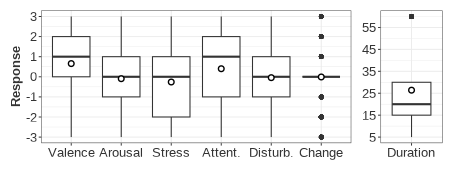

In [11]:
%%R -i LABELS -w 16 -h 6 -u cm

data <- LABELS %>% pivot_longer(
    cols = c('valence', 'arousal', 'attention', 'stress', 'duration', 'disturbance', 'change'),
    names_to = 'metric'
)

p_rest <- ggplot(
    data %>% filter(metric != 'duration'), aes(x=metric, y=value)
) + geom_boxplot(
) + geom_point(
    data = data %>% filter(
        metric != 'duration'
    ) %>% group_by(
        metric
    ) %>% summarise(
        mean = mean(value, na.rm=TRUE)
    ),
    mapping=aes(x=metric, y=mean),
    shape=21,
    stroke=1,
    size=2,
    fill='white'
) + scale_x_discrete(
    name=NULL,
    limits=c('valence', 'arousal', 'stress', 'attention', 'disturbance', 'change'),
    labels=c('Valence', 'Arousal', 'Stress', 'Attent.', 'Disturb.', 'Change'),
) + scale_y_continuous(
    name='Response',
    breaks=-3:3
) + THEME_DEFAULT

p_duration <- ggplot(
    data %>% filter(metric == 'duration'), aes(x=metric, y=value)
) + geom_boxplot(
) + geom_point(
    data = data %>% filter(
        metric == 'duration'
    ) %>% group_by(
        metric
    ) %>% summarise(
        mean = mean(value, na.rm=TRUE)
    ),
    mapping=aes(x=metric, y=mean),
    shape=21,
    stroke=1,
    size=2,
    fill='white'
)+ scale_x_discrete(
    name=NULL,
    limits=c('duration'),
    labels=c('Duration'),
) + scale_y_continuous(
    name=NULL,
    breaks=seq(from=5, to=60, by=10)
) + THEME_DEFAULT

p <- p_rest + p_duration + plot_layout(widths=c(4, 0.8))
ggsave('./fig/dist-labels.pdf', plot=p, width=16, height=6, unit='cm', device=cairo_pdf)
print(p)

### Correlation

Because each participant reported their labels multiple times (i.e., repeated measure), repeated measure correlation between affect labels were used.

In [12]:
data = LABELS.reset_index()[[
    'pcode', 'valence', 'arousal', 'stress', 'attention', 'disturbance', 'change'
]]

In [13]:
%%R -i data 

com <- combn(c('valence', 'arousal', 'stress', 'attention', 'disturbance', 'change'), 2)

for(i in 1:ncol(com)) {
    a <- com[, i][1]
    b <- com[, i][2]
    r <- rmcorr(participant = 'pcode', measure1=a, measure2=b, dataset=data)
    cat(a, '-', b, ': R =', r$r, '(p =', r$p, ') \n')
}

valence - arousal : R = 0.3858505 (p = 6.005105e-195 ) 
valence - stress : R = -0.5918317 (p = 0 ) 
valence - attention : R = 0.2880379 (p = 1.138238e-105 ) 
valence - disturbance : R = -0.02946216 (p = 0.02880521 ) 
valence - change : R = 0.3163849 (p = 2.978458e-128 ) 
arousal - stress : R = -0.2020498 (p = 8.095612e-52 ) 
arousal - attention : R = 0.4354836 (p = 1.162341e-253 ) 
arousal - disturbance : R = 0.0284022 (p = 0.03507786 ) 
arousal - change : R = 0.1673468 (p = 7.1899e-36 ) 
stress - attention : R = -0.1515681 (p = 1.176714e-29 ) 
stress - disturbance : R = 0.08679844 (p = 1.108432e-10 ) 
stress - change : R = -0.2907816 (p = 9.560751e-108 ) 
attention - disturbance : R = 0.1182107 (p = 1.363257e-18 ) 
attention - change : R = 0.1163492 (p = 4.682081e-18 ) 
disturbance - change : R = -0.2216444 (p = 3.009815e-62 ) 


## Sensor Data

In [14]:
import os
import pandas as pd
import gc
from typing import Optional
import ray

@ray.remote
def load_and_process_data(name: str, path_sensor: str) -> Optional[pd.DataFrame]:
    paths = [
        (d, os.path.join(path_sensor, d, f'{name}.csv'))
        for d in os.listdir(path_sensor)
        if d.startswith('P')
    ]
    data = pd.concat(
        filter(
            lambda x: len(x.index),
            [
                pd.read_csv(p).assign(pcode=pcode)
                for pcode, p in paths
                if os.path.exists(p)
            ]
        ), ignore_index=True
    ).assign(
        timestamp=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)
    ).set_index(
        ['pcode', 'timestamp']
    )
    inst = data.groupby('pcode').count().iloc[:, -1]
    samp = np.concatenate([
        (data.loc[(p,), :].index.array - data.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()
        for p in data.index.get_level_values('pcode').unique()
    ])
    inst_summary = summary(inst)
    samp_summary = summary(samp)

    column_summaries = {
        c: summary(data[c])
        for c in data.columns
    }

    print('#'*5, name, '#'*5)
    print('- # Inst.:', inst_summary)
    print('- Samp. period:', samp_summary)

    for c, c_summary in column_summaries.items():
        print(f'- {c}:', c_summary)

    return {
        'name': name,
        'inst_summary': inst_summary,
        'samp_summary': samp_summary,
        'column_summaries': column_summaries
    }


with on_ray(): 

    results = []

    for data_type in DATA_TYPES:
        results.append(load_and_process_data.remote(data_type, PATH_SENSOR))

    stats = ray.get(results)

    STATS = pd.DataFrame(stats)

del results, stats, STATS


2023-07-23 15:39:08,427	INFO worker.py:1452 -- Connecting to existing Ray cluster at address: 192.168.1.28:6379...
2023-07-23 15:39:08,492	INFO worker.py:1627 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
(load_and_process_data pid=159580) /tmp/ipykernel_159458/4022728983.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.


(load_and_process_data pid=159582) ##### CallEvent #####
(load_and_process_data pid=159582) - # Inst.: {'n': 67, 'sum': 1546, 'mean': 23.074626865671643, 'SD': 25.421485444543677, 'med': 13.0, 'range': (1, 123), 'conf.': (16.87383934740705, 29.275414383936237), 'nan_count': 0}
(load_and_process_data pid=159582) - Samp. period: {'n': 1479, 'sum': 16861406.623, 'mean': 11400.545384043273, 'SD': 27689.5710025381, 'med': 1337.943, 'range': (0.408, 338163.378), 'conf.': (9988.215903119613, 12812.874864966932), 'nan_count': 0}
(load_and_process_data pid=159582) - number: {'n': 1546, 'cardinality': 492, 'value_count': '0104$070dd33ca6bb9f397ef5d50b5ff85a68:152, 0103$40b5d03a8b8ea68054d5ac4c72b382d1:42, 0107$7a44af8ea4fa07ae50542fcb560dd529:41, 0104$953efebd0af0a0f6f73948961fd239bd:37, 0102$7891680e5c259162e79235c578895ebb:33, 0104$fab8457f6f6fe2575d1ba5205177cbee:28, 0105$b23b2674f2e76dabd69e76a2cd0cb438:23, 0105$5539bf1719ca24553f5cdc026780ab6d:21, 0158$af629036eeea7f946ff562aab2254d49:18, 0

(load_and_process_data pid=159592) ##### ActivityEvent #####
(load_and_process_data pid=159592) - confidenceStill: {'n': 857437, 'sum': 384491.49999999994, 'mean': 0.4484195340299053, 'SD': 0.43461160263959403, 'med': 0.24, 'range': (0.0, 1.0), 'conf.': (0.44749961646725483, 0.4493394515925558), 'nan_count': 0}
(load_and_process_data pid=159592) - confidenceUnknown: {'n': 857437, 'sum': 77627.03000000001, 'mean': 0.09053380015091489, 'SD': 0.15446505481813258, 'med': 0.01, 'range': (0.0, 1.0), 'conf.': (0.09020685278945476, 0.09086074751237502), 'nan_count': 0}
(load_and_process_data pid=159592) - confidenceOnFoot: {'n': 857437, 'sum': 141488.60000000003, 'mean': 0.16501340623276117, 'SD': 0.30429163345470084, 'med': 0.01, 'range': (0.0, 1.0), 'conf.': (0.16436932950751387, 0.16565748295800847), 'nan_count': 0}
(load_and_process_data pid=159592) - confidenceWalking: {'n': 857437, 'sum': 140625.11999999997, 'mean': 0.16400635848464665, 'SD': 0.30332259929643823, 'med': 0.01, 'range': (0

(load_and_process_data pid=323677, ip=192.168.1.49) /tmp/ipykernel_159458/4022728983.py:30: PerformanceWarning: indexing past lexsort depth may impact performance. [repeated 18x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(load_and_process_data pid=159587) /tmp/ipykernel_159458/4022728983.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.


(load_and_process_data pid=323677, ip=192.168.1.49) ##### WiFi #####
(load_and_process_data pid=323677, ip=192.168.1.49) - bssid: {'n': 15258102, 'cardinality': 310874, 'value_count': '6b186e57-cc96-4f85-ad3c-80734ba597b8:20300, 777ae97a-7584-4414-9862-ee8a4645ae8b:15749, 6dd66e08-a0b7-481e-af4b-9d70e82d49cb:15458, adab9bd0-15e5-409f-929c-57f4f0424c50:15331, bdb0522c-5453-4e8f-8bb9-93b2483cced5:13912, 454820e6-9e3b-4938-9cf6-74a955c47e05:13777, 2fac2da8-d0f8-408d-9608-b98caa359823:13745, 14e48f9a-2b95-4f53-9ee4-90add0183eb0:13287, da75aa19-6ec8-490f-8830-fd62fd315af9:13186, fd5ba903-8eea-4771-af9d-86f84f037d8b:13170, 87b30ad2-34b8-49c7-b150-c057943d8b22:12703, b5d5d05d-6a0a-4686-9a7e-cc21c7b0f780:12578, 90440206-a66b-4e3f-a474-6ddb3cea4385:12112, d54493fd-5903-4d0b-84b6-b40f864cff4c:12110, 117e1849-dbc8-4d2a-bac3-fd3c11a16f6c:12039, d66da681-8b44-4b37-b73f-f5408568c5a4:11950, b1c96308-2341-4b06-9731-e2389a065bb8:11811, dd9e36d5-b6a1-47db-a015-a89269a881db:11755, ee86ec5d-c3f5-4334-9cce

(load_and_process_data pid=159584) /tmp/ipykernel_159458/4022728983.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.


(load_and_process_data pid=159587) ##### HR #####
(load_and_process_data pid=159587) - bpm: {'n': 13621023, 'sum': 1029728342, 'mean': 75.59845850051057, 'SD': 9.820564496209341, 'med': 75.0, 'range': (35, 199), 'conf.': (75.59324319542789, 75.60367380559326), 'nan_count': 0}
(load_and_process_data pid=159587) - bpm: {'n': 13621023, 'sum': 1029728342, 'mean': 75.59845850051057, 'SD': 9.820564496209341, 'med': 75.0, 'range': (35, 199), 'conf.': (75.59324319542789, 75.60367380559326), 'nan_count': 0}
(load_and_process_data pid=159587) - bpm: {'n': 13621023, 'sum': 1029728342, 'mean': 75.59845850051057, 'SD': 9.820564496209341, 'med': 75.0, 'range': (35, 199), 'conf.': (75.59324319542789, 75.60367380559326), 'nan_count': 0}


(load_and_process_data pid=159590) /tmp/ipykernel_159458/4022728983.py:30: PerformanceWarning: indexing past lexsort depth may impact performance. [repeated 3x across cluster]


(load_and_process_data pid=159584) ##### Calorie #####
(load_and_process_data pid=159584) - # Inst.: {'n': 77, 'sum': 15601514, 'mean': 202617.06493506493, 'SD': 59660.549453893436, 'med': 203676.0, 'range': (61197, 314216), 'conf.': (189075.78123744018, 216158.34863268968), 'nan_count': 0}
(load_and_process_data pid=159584) - Samp. period: {'n': 15601437, 'sum': 41213542.37799999, 'mean': 2.641650405536361, 'SD': 318.55820674269137, 'med': 1.025, 'range': (0.001, 347545.58), 'conf.': (2.483578524354587, 2.7997222867181355), 'nan_count': 0}
(load_and_process_data pid=159584) - caloriesToday: {'n': 15601514, 'sum': 17690514158, 'mean': 1133.897271636586, 'SD': 429.68944030674555, 'med': 1142.0, 'range': (0, 2387), 'conf.': (1133.684055812589, 1134.1104874605833), 'nan_count': 0}
(load_and_process_data pid=159584) - totalCalories: {'n': 15601514, 'sum': 90234460224, 'mean': 5783.6989553706135, 'SD': 3364.9152102294734, 'med': 5451.0, 'range': (0, 14838), 'conf.': (5782.029253716513, 5785

(load_and_process_data pid=159586) /tmp/ipykernel_159458/4022728983.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.


(load_and_process_data pid=159586) ##### AmbientLight #####
(load_and_process_data pid=159586) - brightness: {'n': 31948974, 'sum': 11939891469, 'mean': 373.71752435618123, 'SD': 2573.6669710177616, 'med': 39.0, 'range': (0, 65535), 'conf.': (372.82509879993745, 374.609949912425), 'nan_count': 0}
(load_and_process_data pid=159586) - # Inst.: {'n': 77, 'sum': 31948974, 'mean': 414921.74025974027, 'SD': 122176.94279182944, 'med': 416936.0, 'range': (125402, 643940), 'conf.': (387190.9758132746, 442652.5047062059), 'nan_count': 0} [repeated 2x across cluster]
(load_and_process_data pid=159586) - Samp. period: {'n': 31948897, 'sum': 41213635.99199992, 'mean': 1.2899861923871712, 'SD': 222.60798183884282, 'med': 0.5, 'range': (0.001, 347544.869), 'conf.': (1.2127962165083053, 1.367176168266037), 'nan_count': 0} [repeated 2x across cluster]


(load_and_process_data pid=159589) /tmp/ipykernel_159458/4022728983.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.


(load_and_process_data pid=159589) ##### EDA #####
(load_and_process_data pid=159589) - resistance: {'n': 80150329, 'sum': 4456740676426, 'mean': 55604.77083538858, 'SD': 121898.51318979527, 'med': 1385.0, 'range': (0, 340330), 'conf.': (55578.08419819559, 55631.45747258158), 'nan_count': 0}
(load_and_process_data pid=159589) - resistance: {'n': 80150329, 'sum': 4456740676426, 'mean': 55604.77083538858, 'SD': 121898.51318979527, 'med': 1385.0, 'range': (0, 340330), 'conf.': (55578.08419819559, 55631.45747258158), 'nan_count': 0}
(load_and_process_data pid=159589) - resistance: {'n': 80150329, 'sum': 4456740676426, 'mean': 55604.77083538858, 'SD': 121898.51318979527, 'med': 1385.0, 'range': (0, 340330), 'conf.': (55578.08419819559, 55631.45747258158), 'nan_count': 0}


(load_and_process_data pid=159594) /tmp/ipykernel_159458/4022728983.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.


(load_and_process_data pid=159594) ##### Acceleration #####
(load_and_process_data pid=159594) - # Inst.: {'n': 77, 'sum': 123260001, 'mean': 1600779.2337662338, 'SD': 473426.34254662704, 'med': 1616756.0, 'range': (489289, 2464554), 'conf.': (1493324.634822134, 1708233.8327103336), 'nan_count': 0}
(load_and_process_data pid=159594) - Samp. period: {'n': 123259924, 'sum': 41213652.715999976, 'mean': 0.33436376868121365, 'SD': 113.32762322571325, 'med': 0.13, 'range': (0.001, 347544.66), 'conf.': (0.3143571853179485, 0.3543703520444788), 'nan_count': 0}
(load_and_process_data pid=159594) - x: {'n': 123260001, 'sum': -5999685.698486219, 'mean': -0.048675041780067964, 'SD': 0.619149989039201, 'med': -0.066162109375, 'range': (-7.9951171875, 7.99975585938), 'conf.': (-0.048784344981250685, -0.04856573857888524), 'nan_count': 0}
(load_and_process_data pid=159594) - y: {'n': 123260001, 'sum': 21869550.39282226, 'mean': 0.17742617406616976, 'SD': 0.5751403091314405, 'med': 0.223876953125, 'ra

# Preprocessing

## Label

Because we intended to collected participants' responses to ESMs not voluntary responses, we screend out some responses as follows:
* We first screen out ESM responses that does not have 'scheduledTime' (meaning that a given ESM was expired or participants voluntarily reported their affective states regardless of ESM delivery). 
* Since we will evaluate our model using LOSO, the small number of responses for each participant might lead to inappropriate performance evaluation. We emprically set the number of the minimum responses upon ESM delivery as 5 per day (i.e., a half of our guides), so that we excluded participants whose responses to ESM less than 35.

In [8]:
LABELS_VALID = LABELS.loc[
    lambda x: ~x['scheduledTime'].isna(), :
]
print(f'# Non-voluntary response: {len(LABELS_VALID)}')
print(summary(LABELS_VALID.groupby('pcode').count().iloc[:, -1]))

excl_pcode = LABELS_VALID.loc[
    lambda x: ~x['scheduledTime'].isna()
].groupby('pcode').count().iloc[:, -1].loc[lambda y: y < 35]

LABELS_VALID = LABELS_VALID.loc[
    lambda x:  ~x.index.get_level_values('pcode').isin(excl_pcode.index), :
]
print(f'# Response from participants with enough responses: {len(LABELS_VALID)}')
print(summary(LABELS_VALID.groupby('pcode').count().iloc[:, -1]))

print('# Participants whose responses to ESM delivery were less then 35')
print(excl_pcode, f'#participants = {len(excl_pcode)} / #response = {sum(excl_pcode)}')

# Non-voluntary response: 3323
{'n': 76, 'sum': 3323, 'mean': 43.723684210526315, 'SD': 19.36291898394835, 'med': 43.5, 'range': (3, 83), 'conf.': (39.29906768359284, 48.14830073745979), 'nan_count': 0}
# Response from participants with enough responses: 2619
{'n': 47, 'sum': 2619, 'mean': 55.723404255319146, 'SD': 13.076201628480542, 'med': 52.0, 'range': (36, 83), 'conf.': (51.88408763344431, 59.56272087719398), 'nan_count': 0}
# Participants whose responses to ESM delivery were less then 35
pcode
P04    34
P07    24
P11    22
P14    11
P16    30
P17    13
P18    32
P20    31
P22    23
P24    10
P25    30
P29    32
P34    22
P36    29
P37    31
P38    33
P41    31
P43    24
P44    23
P46     4
P54    13
P56    31
P58    29
P62     3
P63    34
P64    30
P68    11
P73    31
P74    33
Name: change, dtype: int64 #participants = 29 / #response = 704


Here we consider binary classifications for valence, arousal, stress, and disturbance, in which a label value greater than 0 is "HIGH" (1) and the rest is "LOW" (0), at the arrival of ESM prompts (*scheduledTime*)

In [9]:
import pandas as pd
import numpy as np


LABELS_PROC = LABELS_VALID.reset_index().assign(
    timestamp=lambda x: pd.to_datetime(x['scheduledTime'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ),
    valence_bin = lambda x: np.where(x['valence'] > 0, 1, 0),
    arousal_bin = lambda x: np.where(x['arousal'] > 0, 1, 0),
    stress_bin = lambda x: np.where(x['stress'] > 0, 1, 0),
    disturbance_bin = lambda x: np.where(x['disturbance'] > 0, 1, 0)
).set_index(
    ['pcode', 'timestamp']
)

LABELS_PROC.head()

responseTime  scheduledTime  valence  \
pcode timestamp                                                          
P01   2019-05-08 10:26:00+09:00  1557278986000   1.557279e+12       -3   
      2019-05-08 11:13:00+09:00  1557281772000   1.557282e+12       -3   
      2019-05-08 15:56:00+09:00  1557298702000   1.557299e+12        3   
      2019-05-08 16:41:00+09:00  1557301311000   1.557301e+12        3   
      2019-05-08 17:23:00+09:00  1557304062000   1.557304e+12        3   

                                 arousal  attention  stress  duration  \
pcode timestamp                                                         
P01   2019-05-08 10:26:00+09:00        3          3       3       5.0   
      2019-05-08 11:13:00+09:00       -2          2       2      15.0   
      2019-05-08 15:56:00+09:00        3          3      -3      20.0   
      2019-05-08 16:41:00+09:00        3          3      -3      30.0   
      2019-05-08 17:23:00+09:00        3          3      -3      20.0   

                                 disturbance  change  valence_bin  \
pcode timestamp                                                     
P01   2019-05-08 10:26:00+09:00           -1      -3            0   
      2019-05-08 11:13:00+09:00            3      -2            0   
      2019-05-08 15:56:00+09:00            2       0            1   
      2019-05-08 16:41:00+09:00            1       2            1   
      2019-05-08 17:23:00+09:00            2       2            1   

                                 arousal_bin  stress_bin  disturbance_bin  
pcode timestamp                                                            
P01   2019-05-08 10:26:00+09:00            1           1                0  
      2019-05-08 11:13:00+09:00            0           1                1  
      2019-05-08 15:56:00+09:00            1           0                1  
      2019-05-08 16:41:00+09:00            1           0                1  
      2019-05-08 17:23:00+09:00            1           0                1

In [10]:
import numpy as np

def zscore(col):
  mean = col.mean()
  std = col.std()
  return (col - mean) / std

#Use user speicifc mean threshold

LABELS_PROC['stress_user_mean'] = np.nan

for user in LABELS_PROC.index.get_level_values('pcode').unique():
    user_df = LABELS_PROC.loc[user].copy()
    user_df['zscore'] = zscore(user_df['stress']) 

    # Align indices before assigning
    user_df = user_df.align(LABELS_PROC, axis=0)[0]  

    LABELS_PROC.loc[user, 'stress_user_mean'] = (user_df['zscore'] > user_df['zscore'].mean()).astype(int)

In [11]:
# Count positive/negative labels per user
label_counts = LABELS_PROC.groupby(['pcode'])['stress_bin'].value_counts()
label_counts = label_counts.unstack(fill_value=0)

# Calculate proportion of positive labels  
pos_prop = label_counts[1] / label_counts.sum(axis=1)

# Define threshold for biased users
threshold = 0.8

# Find positively biased users
pos_biased = pos_prop[pos_prop > threshold].index

# Calculate proportion of negative labels
neg_prop = label_counts[0] / label_counts.sum(axis=1) 

# Find negatively biased users 
neg_biased = neg_prop[neg_prop > threshold].index  

# Remove both positively and negatively biased users
all_biased = pos_biased.union(neg_biased)

LABELS_PROC = LABELS_PROC.loc[lambda x:  ~x.index.get_level_values('pcode').isin(all_biased), :]

print(f'# Response from participants with balanced stress distribution: {len(LABELS_VALID)}')
print(summary(LABELS_VALID.groupby('pcode').count().iloc[:, -1]))

print('# Participants whose stress distribution is imbalanced')
print(excl_pcode, f'#participants = {len(all_biased)} ')

# Response from participants with balanced stress distribution: 2619
{'n': 47, 'sum': 2619, 'mean': 55.723404255319146, 'SD': 13.076201628480542, 'med': 52.0, 'range': (36, 83), 'conf.': (51.88408763344431, 59.56272087719398), 'nan_count': 0}
# Participants whose stress distribution is imbalanced
pcode
P04    34
P07    24
P11    22
P14    11
P16    30
P17    13
P18    32
P20    31
P22    23
P24    10
P25    30
P29    32
P34    22
P36    29
P37    31
P38    33
P41    31
P43    24
P44    23
P46     4
P54    13
P56    31
P58    29
P62     3
P63    34
P64    30
P68    11
P73    31
P74    33
Name: change, dtype: int64 #participants = 9 


In [12]:
import numpy as np


inst = LABELS_PROC.groupby('pcode').count().iloc[:, -1]
for c in [c for c in LABELS_PROC.columns if c.endswith('_bin')]:
    print(f'- {c}:', summary(LABELS_PROC[c].astype(object)))

- valence_bin: {'n': 2119, 'cardinality': 2, 'value_count': '1:1213, 0:906'}
- arousal_bin: {'n': 2119, 'cardinality': 2, 'value_count': '0:1324, 1:795'}
- stress_bin: {'n': 2119, 'cardinality': 2, 'value_count': '0:1268, 1:851'}
- disturbance_bin: {'n': 2119, 'cardinality': 2, 'value_count': '0:1179, 1:940'}


In [13]:
import numpy as np


inst = LABELS_PROC.groupby('pcode').count().iloc[:, -1]
for c in [c for c in LABELS_PROC.columns if c.endswith('_user_mean')]:
    print(f'- {c}:', summary(LABELS_PROC[c].astype(object)))

- stress_user_mean: {'n': 2119, 'cardinality': 2, 'value_count': '0.0:1139, 1.0:980'}


## Sensor Data

For each type of sensor data, we applied different preprocessing. Detailed decsription is provided in the paper.



### Implementation

In [21]:
import pandas as pd
import numpy as np
import scipy.spatial.distance as dist
from typing import Dict, Union
import pygeohash as geo
from datetime import timedelta
from collections import defaultdict


# AppUsageEvent.csv
def _proc_app_usage(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    data = data.loc[
        lambda x: x['type'].isin(['MOVE_TO_FOREGROUND', 'MOVE_TO_BACKGROUND']), :
    ].assign(
        packageName=lambda x: np.where(x['type'] == 'MOVE_TO_FOREGROUND', x['packageName'], None),
        category=lambda x: np.where(x['type'] == 'MOVE_TO_FOREGROUND', x['category'], None),
    )

    return {
        'PAC': data['packageName'].astype('object'),
        'CAT': data['category'].astype('object')
    }


# Connectivity.csv
def _proc_connectivity(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    data = data.assign(
        type=lambda x: np.where(x['isConnected'] == True, x['type'], 'DISCONNECTED')
    )

    return data['type'].astype('object')


# BatteryEvent.csv
def _proc_battery(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return {
        'LEV': data['level'].astype('float32'),
        'STA': data['status'].astype('object'),
        'TMP': data['temperature'].astype('float32')
    }
        

# CallEvent.csv
def _proc_call(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    data = data.loc[
        lambda x: x['duration'] > 0, :
    ]
    new_data = []

    for row in data.itertuples():
        pcode, timestamp = row.Index
        
        new_data.append({
            'pcode': pcode,
            'timestamp': timestamp,                
            'state': 'CALL',
        })
        new_data.append({
            'pcode': pcode,
            'timestamp': timestamp + timedelta(milliseconds=row.duration),
            'state': 'IDLE'
        })

    new_data = pd.DataFrame(new_data).set_index(
        ['pcode', 'timestamp']
    )

    return new_data['state'].astype('object')


# DataTraffic.csv
def _proc_data_traffic(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return {
        'RCV': data['rxKiloBytes'].astype('float32'),
        'SNT': data['txKiloBytes'].astype('float32')
    }


# RingerModeEvent.csv
def _proc_ringer_mode(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['type'].astype('object')


# ScreenEvent.csv
def _proc_screen(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['type'].astype('object')


# OnOffEvent.csv
def _proc_on_off(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['type'].astype('object')


# PowerSaveEvent.csv
def _proc_power_save(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['type'].astype('object')


# ChargeEvent.csv
def _proc_charge(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['type'].astype('object')


# Location.csv
def _proc_location(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    def _haversine(_lat1, _lat2, _lng1, _lng2) -> float:
        if np.isnan(_lat1) or np.isnan(_lat2) or np.isnan(_lng1) or np.isnan(_lng2):
            return 0.0

        _lat1_r, _lat2_r, _lng1_r, _lng2_r = np.radians(_lat1), np.radians(_lat2), np.radians(_lng1), np.radians(_lng2)
        _lat = _lat2_r - _lat1_r
        _lng = _lng2_r - _lng1_r
        _R = 6371008.8
        _d = np.sin(_lat * 0.5) ** 2 + np.cos(_lat1_r) * np.cos(_lat2_r) * np.sin(_lng * 0.5) ** 2
        return 2 * _R * np.arcsin(np.sqrt(_d))

    new_data = []
    
    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        ).assign(
            _latitude=lambda x: x['latitude'].shift(1),
            _longitude=lambda x: x['longitude'].shift(1),
            dist=lambda x: x.apply(
                lambda y: _haversine(y['latitude'], y['_latitude'], y['longitude'], y['_longitude']),
                axis=1
            ),
            cluster=lambda x: x.apply(
                lambda y: geo.encode(y['latitude'], y['longitude'], precision=7),
                axis=1
            ),
            pcode=pcode
        ).reset_index()
        new_data.append(sub)

    new_data = pd.concat(new_data, axis=0, ignore_index=True).set_index(
        ['pcode', 'timestamp']
    )

    return {
        'CLS': new_data['cluster'].astype('object'),
        'DST': new_data['dist'].astype('float32')
    }


# ActivityEvent.csv
def _proc_activity_event(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return {
        'UNK': data['confidenceUnknown'].astype('float32'),
        'FOT': data['confidenceOnFoot'].astype('float32'),
        'WLK': data['confidenceWalking'].astype('float32'),
        'VHC': data['confidenceInVehicle'].astype('float32'),
        'BCC': data['confidenceOnBicycle'].astype('float32'),
        'RUN': data['confidenceRunning'].astype('float32'),
        'TLT': data['confidenceTilting'].astype('float32')
    }


# ActivityTransition.csv
def _proc_activity_transition(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    data = data.loc[
        lambda x: x['transitionType'].isin(['ENTER_WALKING', 'ENTER_STILL', 'ENTER_IN_VEHICLE', 'ENTER_ON_BICYCLE', 'ENTER_RUNNING']), :
    ].assign(
        type=lambda x: x['transitionType'].str.replace('ENTER_', '')
    )
    
    return data['type'].astype('object')


# WiFi.csv
def _proc_wifi(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = []
    
    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        ).assign(
            bssid=lambda x: x['bssid'].str.cat(x['frequency'].astype(str), sep='-')
        )
        t = sub.index.unique().array
        for cur_t, prev_t in zip(t, t.shift(1)):
            if cur_t is pd.NaT or prev_t is pd.NaT:
                continue

            prev = sub.loc[[prev_t], :]
            cur = sub.loc[[cur_t], :]
            intersect = np.intersect1d(prev['bssid'], cur['bssid'])
            union = np.union1d(prev['bssid'], cur['bssid'])
            w = np.repeat(1 / len(intersect), len(intersect)) if len(intersect) else 1.0
            prev_intersect = prev.loc[
                lambda x: x['bssid'].isin(intersect), :
            ].sort_values('bssid')
            cur_intersect = cur.loc[
                lambda x: x['bssid'].isin(intersect), :
            ].sort_values('bssid')
            prev_rssi = prev_intersect['rssi']
            cur_rssi = cur_intersect['rssi']

            new_data.append(dict(
                pcode=pcode,
                timestamp=cur_t,
                cosine=1 - dist.cosine(prev_rssi, cur_rssi) if len(intersect) > 0 else 0,
                euclidean=1 / (1 + dist.euclidean(prev_rssi, cur_rssi, w)) if len(intersect) > 0 else 0,
                manhattan=1 / (1 + dist.cityblock(prev_rssi, cur_rssi, w)) if len(intersect) > 0 else 0,
                jaccard = len(intersect) / len(union) if len(union) > 0 else 0
            ))
            
    new_data = pd.DataFrame(new_data).set_index(
        ['pcode', 'timestamp']
    )
    
    return {
        'COS': new_data['cosine'].astype('float32'),
        'EUC': new_data['euclidean'].astype('float32'),
        'MAN': new_data['manhattan'].astype('float32'),
        'JAC': new_data['jaccard'].astype('float32')
    }


# InstalledApp.csv
def _proc_installed_app(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = []
    
    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(axis=0, level='timestamp')
        t = sub.index.unique().array
        for cur_t, prev_t in zip(t, t.shift(1)):
            if cur_t is pd.NaT or prev_t is pd.NaT:
                continue

            prev = sub.loc[[prev_t], :]
            cur = sub.loc[[cur_t], :]
            intersect = np.intersect1d(prev['packageName'], cur['packageName'])
            union = np.union1d(prev['packageName'], cur['packageName'])
            new_data.append(dict(
                pcode=pcode,
                timestamp=cur_t,
                jaccard = len(intersect) / len(union) if len(union) > 0 else 0
            ))
            
    new_data = pd.DataFrame(new_data).set_index(
        ['pcode', 'timestamp']
    )
    
    return {
       'JAC': new_data['jaccard'].astype('float32')
    }


# MediaEvent.csv
def _proc_media_event(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = defaultdict(list)
    
    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        )

        video = sub.loc[
            lambda x: x['mimetype'].str.startswith('video'), :
        ].assign(
            event=1,
            pcode=pcode
        ).reset_index()

        image = sub.loc[
            lambda x: x['mimetype'].str.startswith('image'), :
        ].assign(
            event=1,
            pcode=pcode
        ).reset_index()

        media = sub.assign(
            event=1,
            pcode=pcode
        ).reset_index()

        new_data['VID'].append(video)
        new_data['IMG'].append(image)
        new_data['ALL'].append(media)

    return {
        k: pd.concat(
            v, axis=0, ignore_index=True
        ).set_index(
            ['pcode', 'timestamp']
        )['event'].astype('float32') 
        for k, v in new_data.items()
    }


# MessageEvent.csv
def _proc_message_event(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = defaultdict(list)
    
    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        )

        sent = sub.loc[
            lambda x: x['messageBox'] == 'SENT', :
        ].assign(
            event=1,
            pcode=pcode
        ).reset_index()

        recv = sub.loc[
            lambda x: x['messageBox'] == 'INBOX', :
        ].assign(
            event=1,
            pcode=pcode
        ).reset_index()

        msg = sub.assign(
            event=1,
            pcode=pcode
        ).reset_index()

        new_data['SNT'].append(sent)
        new_data['RCV'].append(recv)
        new_data['ALL'].append(msg)

    return {
        k: pd.concat(
            v, axis=0, ignore_index=True
        ).set_index(
            ['pcode', 'timestamp']
        )['event'].astype('float32') 
        for k, v in new_data.items()
    }


# Acceleration.csv
def _proc_acceleration(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    data = data.assign(
        mag=lambda x: np.sqrt(np.square(x['x']) + np.square(x['y']) + np.square(x['z']))
    )

    return {
        'AXX': data['x'].astype('float32'),
        'AXY': data['y'].astype('float32'),
        'AXZ': data['z'].astype('float32'),
        'MAG': data['mag'].astype('float32')
    }

# UltraViolet.csv
def _proc_ultra_violet(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = []
    
    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        ).assign(
            exposure=lambda x: (x['totalExposure'] - x['totalExposure'].shift(1)),
            pcode=pcode
        ).reset_index()

        new_data.append(sub)

    new_data = pd.concat(new_data, axis=0, ignore_index=True).set_index(
        ['pcode', 'timestamp']
    )

    return {
        'INT': new_data['intensity'].astype('object'),
        'EXP': new_data['exposure'].dropna().astype('float32')
    }


# SkinTemperature.csv
def _proc_skin_temperature(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['temperature'].astype('float32')


# RRI.csv
def _proc_rri(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['interval'].astype('float32')


# AmbientLight.csv
def _proc_ambient_light(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['brightness'].astype('float32')
    

# StepCount.csv
def _proc_step_count(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = []

    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        ).assign(
            steps=lambda x: (x['totalSteps'] - x['totalSteps'].shift(1)),
            pcode=pcode
        ).reset_index()
        new_data.append(sub)

    new_data = pd.concat(new_data, axis=0, ignore_index=True).set_index(
        ['pcode', 'timestamp']
    )

    return new_data['steps'].dropna().astype('float32')
    

# HR.csv
def _proc_hr(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['bpm'].astype('float32')
    

# EDA.csv
def _proc_eda(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['resistance'].astype('float32')


# Distance.csv
def _proc_distance(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = []

    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        ).assign(
            distance=lambda x: x['totalDistance'] - x['totalDistance'].shift(1),
            pcode=pcode
        ).reset_index()

        new_data.append(sub)

    new_data = pd.concat(new_data, axis=0, ignore_index=True).set_index(
        ['pcode', 'timestamp']
    )

    return {
        'DST': new_data['distance'].dropna().astype('float32'),
        'MOT': new_data['motionType'].astype('object'),
        'PAC': new_data['pace'].astype('float32'),
        'SPD': new_data['speed'].astype('float32')
    }


# Calorie.csv
def _proc_calories(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = []

    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        ).assign(
            calories=lambda x: x['totalCalories'] - x['totalCalories'].shift(1),
            pcode=pcode
        ).reset_index()

        new_data.append(sub)

    new_data = pd.concat(new_data, axis=0, ignore_index=True).set_index(
        ['pcode', 'timestamp']
    )

    return new_data['calories'].dropna().astype('float32')           


### Execution

In [22]:
import pandas as pd
import gc
from functools import reduce

FUNC_PROC = {
    'Acceleration': _proc_acceleration,
    'AmbientLight': _proc_ambient_light,
    'Calorie': _proc_calories,
    'Distance': _proc_distance,
    'EDA': _proc_eda,
    'HR': _proc_hr,
    'RRI': _proc_rri,
    'SkinTemperature': _proc_skin_temperature,
    'StepCount': _proc_step_count,
    'UltraViolet': _proc_ultra_violet,
    'ActivityEvent': _proc_activity_event,
    'ActivityTransition': _proc_activity_transition,
    'AppUsageEvent': _proc_app_usage,
    'BatteryEvent': _proc_battery,
    'CallEvent': _proc_call,
    'Connectivity': _proc_connectivity,
    'DataTraffic': _proc_data_traffic,
    'InstalledApp': _proc_installed_app,
    'Location': _proc_location,
    'MediaEvent': _proc_media_event,
    'MessageEvent': _proc_message_event,
    'WiFi': _proc_wifi,
    'ScreenEvent': _proc_screen,
    'RingerModeEvent': _proc_ringer_mode,
    'ChargeEvent': _proc_charge,
    'PowerSaveEvent': _proc_power_save,
    'OnOffEvent': _proc_on_off
}


def _process(data_type: str):
    log(f'Begin to processing data: {data_type}')
    
    abbrev = DATA_TYPES[data_type]
    data_raw = _load_data(data_type)
    data_proc = FUNC_PROC[data_type](data_raw)
    del data_raw
    result = dict()
    
    if type(data_proc) is dict:
        for k, v in data_proc.items():
            result[f'{abbrev}_{k}'] = v
    else:
        result[abbrev] = data_proc
        
    log(f'Complete processing data: {data_type}')
    return result



# with on_ray(num_cpus=12):
with on_ray():
    jobs = []
    
    func = ray.remote(_process).remote
    
    for data_type in DATA_TYPES:
        job = func(data_type)
        jobs.append(job)

    jobs = ray.get(jobs)
    jobs = reduce(lambda a, b: {**a, **b}, jobs)
    dump(jobs, os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))

    del jobs
    gc.collect()

2023-07-23 15:42:47,277	INFO worker.py:1452 -- Connecting to existing Ray cluster at address: 192.168.1.28:6379...
2023-07-23 15:42:47,287	INFO worker.py:1627 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


(_process pid=160532) [23-07-23 15:42:47] Begin to processing data: Calorie
(_process pid=160539) [23-07-23 15:42:47] Begin to processing data: Distance
(_process pid=160536) [23-07-23 15:42:47] Begin to processing data: AmbientLight
(_process pid=160542) [23-07-23 15:42:47] Begin to processing data: Acceleration
(_process pid=160534) [23-07-23 15:42:48] Begin to processing data: SkinTemperature
(_process pid=160540) [23-07-23 15:42:48] Begin to processing data: EDA
(_process pid=160537) [23-07-23 15:42:48] Begin to processing data: RRI
(_process pid=160533) [23-07-23 15:42:48] Begin to processing data: HR
(_process pid=323668, ip=192.168.1.49) [23-07-23 15:42:48] Begin to processing data: InstalledApp
(_process pid=323671, ip=192.168.1.49) [23-07-23 15:42:48] Begin to processing data: DataTraffic
(_process pid=323665, ip=192.168.1.49) [23-07-23 15:42:48] Begin to processing data: Location
(_process pid=323673, ip=192.168.1.49) [23-07-23 15:42:48] Begin to processing data: ActivityTran

(_process pid=323670, ip=192.168.1.49) /tmp/ipykernel_159458/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=323670, ip=192.168.1.49) /tmp/ipykernel_159458/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=323670, ip=192.168.1.49) /tmp/ipykernel_159458/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=323670, ip=192.168.1.49) /tmp/ipykernel_159458/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=323670, ip=192.168.1.49) /tmp/ipykernel_159458/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=323670, ip=192.168.1.49) /tmp/ipykernel_159458/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=323670, ip=192.168.1.49) /tmp/ipykernel_159458/2045122460.py:353: Performa

(_process pid=324877, ip=192.168.1.49) [23-07-23 15:42:48] Begin to processing data: OnOffEvent
(_process pid=160686) [23-07-23 15:42:48] Begin to processing data: RingerModeEvent
(_process pid=160640) [23-07-23 15:42:48] Begin to processing data: ScreenEvent
(_process pid=160789) [23-07-23 15:42:48] Begin to processing data: ChargeEvent
(_process pid=160746) [23-07-23 15:42:48] Begin to processing data: PowerSaveEvent
(_process pid=324877, ip=192.168.1.49) [23-07-23 15:42:48] Complete processing data: OnOffEvent


(_process pid=323670, ip=192.168.1.49) /tmp/ipykernel_159458/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=323670, ip=192.168.1.49) /tmp/ipykernel_159458/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=323670, ip=192.168.1.49) /tmp/ipykernel_159458/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.


(_process pid=160686) [23-07-23 15:42:48] Complete processing data: RingerModeEvent
(_process pid=323671, ip=192.168.1.49) [23-07-23 15:42:48] Complete processing data: DataTraffic
(_process pid=323670, ip=192.168.1.49) [23-07-23 15:42:48] Complete processing data: UltraViolet
(_process pid=160534) [23-07-23 15:42:48] Complete processing data: SkinTemperature
(_process pid=160789) [23-07-23 15:42:48] Complete processing data: ChargeEvent
(_process pid=160746) [23-07-23 15:42:48] Complete processing data: PowerSaveEvent
(_process pid=160640) [23-07-23 15:42:48] Complete processing data: ScreenEvent
(_process pid=323669, ip=192.168.1.49) [23-07-23 15:42:49] Complete processing data: BatteryEvent
(_process pid=323674, ip=192.168.1.49) [23-07-23 15:42:49] Complete processing data: ActivityEvent
(_process pid=160541) [23-07-23 15:42:49] Complete processing data: MessageEvent
(_process pid=160538) [23-07-23 15:42:49] Complete processing data: MediaEvent
(_process pid=323666, ip=192.168.1.49)

(_process pid=323668, ip=192.168.1.49) /tmp/ipykernel_159458/2045122460.py:226: PerformanceWarning: indexing past lexsort depth may impact performance. [repeated 174x across cluster]


(_process pid=323668, ip=192.168.1.49) [23-07-23 15:42:57] Complete processing data: InstalledApp


(_process pid=323665, ip=192.168.1.49) /tmp/ipykernel_159458/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance. [repeated 64x across cluster]
(_process pid=323665, ip=192.168.1.49) /tmp/ipykernel_159458/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance. [repeated 15x across cluster]


(_process pid=160533) [23-07-23 15:43:06] Complete processing data: HR


(_process pid=160532) /tmp/ipykernel_159458/2045122460.py:448: PerformanceWarning: indexing past lexsort depth may impact performance. [repeated 63x across cluster]


(_process pid=160537) [23-07-23 15:43:11] Complete processing data: RRI


(_process pid=323665, ip=192.168.1.49) /tmp/ipykernel_159458/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance. [repeated 126x across cluster]


(_process pid=323665, ip=192.168.1.49) [23-07-23 15:43:16] Complete processing data: Location


(_process pid=160539) /tmp/ipykernel_159458/2045122460.py:422: PerformanceWarning: indexing past lexsort depth may impact performance. [repeated 51x across cluster]


(_process pid=160536) [23-07-23 15:43:25] Complete processing data: AmbientLight
(_process pid=160532) [23-07-23 15:43:25] Complete processing data: Calorie
(_process pid=160535) [23-07-23 15:43:25] Complete processing data: StepCount
(_process pid=160539) [23-07-23 15:43:32] Complete processing data: Distance


(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance. [repeated 30x across cluster]
(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.


(_process pid=160540) [23-07-23 15:43:53] Complete processing data: EDA


(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.


(_process pid=160542) [23-07-23 15:44:35] Complete processing data: Acceleration


(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=160573) /tmp/ipykernel_159458/2045122460.

(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=160573) /tmp/ipykernel_159458/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=160573) /tmp/ipykernel_159458/2045122460.

(_process pid=160573) [23-07-23 15:55:52] Complete processing data: WiFi


In [22]:
import os
import gc


DATA = load(os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))
N_NUMERIC, N_CATEGORICAL = 0, 0

for k, v in DATA.items():
    if v.dtype.kind.isupper() or v.dtype.kind == 'b': 
        N_CATEGORICAL = N_CATEGORICAL + 1
    else:
        N_NUMERIC = N_NUMERIC + 1
        
    inst = v.groupby('pcode').count()
    sam = np.concatenate([
        (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
        for p in v.index.get_level_values('pcode').unique()
    ])
    
    print('#'*5, k, '#'*5, )
    print('- # Inst.:', summary(inst))
    print('- Samp. period:', summary(sam))
    print('- Values', summary(v))
    print('')
    
    
print(f'# categorical data: {N_CATEGORICAL}/# numeric data: {N_NUMERIC}')
del DATA
gc.collect()

/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### ACC_AXX #####
- # Inst.: {'n': 77, 'sum': 123260001, 'mean': 1600779.2337662338, 'SD': 473426.34254662704, 'med': 1616756.0, 'range': (489289, 2464554), 'conf.': (1493324.634822134, 1708233.8327103336), 'nan_count': 0}
- Samp. period: {'n': 123259924, 'sum': 41213652.715999976, 'mean': 0.33436376868121365, 'SD': 113.32762322571325, 'med': 0.13, 'range': (0.001, 347544.66), 'conf.': (0.3143571853179485, 0.3543703520444788), 'nan_count': 0}
- Values {'n': 123260001, 'sum': -5999699.5, 'mean': -0.048675153, 'SD': 0.6191499, 'med': -0.06616211, 'range': (-7.995117, 7.999756), 'conf.': (-0.048784456594055885, -0.04856585021489263), 'nan_count': 0}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### ACC_AXY #####
- # Inst.: {'n': 77, 'sum': 123260001, 'mean': 1600779.2337662338, 'SD': 473426.34254662704, 'med': 1616756.0, 'range': (489289, 2464554), 'conf.': (1493324.634822134, 1708233.8327103336), 'nan_count': 0}
- Samp. period: {'n': 123259924, 'sum': 41213652.715999976, 'mean': 0.33436376868121365, 'SD': 113.32762322571325, 'med': 0.13, 'range': (0.001, 347544.66), 'conf.': (0.3143571853179485, 0.3543703520444788), 'nan_count': 0}
- Values {'n': 123260001, 'sum': 21869622.0, 'mean': 0.17742676, 'SD': 0.57513875, 'med': 0.22387695, 'range': (-7.995117, 7.9990234), 'conf.': (0.1773252218623611, 0.1775282889942673), 'nan_count': 0}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### ACC_AXZ #####
- # Inst.: {'n': 77, 'sum': 123260001, 'mean': 1600779.2337662338, 'SD': 473426.34254662704, 'med': 1616756.0, 'range': (489289, 2464554), 'conf.': (1493324.634822134, 1708233.8327103336), 'nan_count': 0}
- Samp. period: {'n': 123259924, 'sum': 41213652.715999976, 'mean': 0.33436376868121365, 'SD': 113.32762322571325, 'med': 0.13, 'range': (0.001, 347544.66), 'conf.': (0.3143571853179485, 0.3543703520444788), 'nan_count': 0}
- Values {'n': 123260001, 'sum': 27721322.0, 'mean': 0.2249012, 'SD': 0.5024594, 'med': 0.21386719, 'range': (-8.0, 7.9990234), 'conf.': (0.22481249640517365, 0.22498990227646698), 'nan_count': 0}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### ACC_MAG #####
- # Inst.: {'n': 77, 'sum': 123260001, 'mean': 1600779.2337662338, 'SD': 473426.34254662704, 'med': 1616756.0, 'range': (489289, 2464554), 'conf.': (1493324.634822134, 1708233.8327103336), 'nan_count': 0}
- Samp. period: {'n': 123259924, 'sum': 41213652.715999976, 'mean': 0.33436376868121365, 'SD': 113.32762322571325, 'med': 0.13, 'range': (0.001, 347544.66), 'conf.': (0.3143571853179485, 0.3543703520444788), 'nan_count': 0}
- Values {'n': 123260001, 'sum': 125006250.0, 'mean': 1.0141672, 'SD': 0.1499644, 'med': 1.0013473, 'range': (0.0061859665, 13.854715), 'conf.': (1.014140715254147, 1.01419366394202), 'nan_count': 0}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### AML #####
- # Inst.: {'n': 77, 'sum': 31948974, 'mean': 414921.74025974027, 'SD': 122176.94279182944, 'med': 416936.0, 'range': (125402, 643940), 'conf.': (387190.9758132746, 442652.5047062059), 'nan_count': 0}
- Samp. period: {'n': 31948897, 'sum': 41213635.99199992, 'mean': 1.2899861923871712, 'SD': 222.60798183884282, 'med': 0.5, 'range': (0.001, 347544.869), 'conf.': (1.2127962165083053, 1.367176168266037), 'nan_count': 0}
- Values {'n': 31948974, 'sum': 11939903000.0, 'mean': 373.7179, 'SD': 2573.6665, 'med': 39.0, 'range': (0.0, 65535.0), 'conf.': (372.8254701135408, 374.6103209020842), 'nan_count': 0}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### CAL #####
- # Inst.: {'n': 77, 'sum': 15601437, 'mean': 202616.06493506493, 'SD': 59660.549453893436, 'med': 203675.0, 'range': (61196, 314215), 'conf.': (189074.78123744018, 216157.34863268968), 'nan_count': 0}
- Samp. period: {'n': 15601360, 'sum': 41213462.121999964, 'mean': 2.641658299148277, 'SD': 318.5589928386445, 'med': 1.025, 'range': (0.001, 347545.58), 'conf.': (2.4835856378177184, 2.7997309604788354), 'nan_count': 0}
- Values {'n': 15601437, 'sum': 728224.0, 'mean': 0.046676725, 'SD': 4.0165553, 'med': 0.0, 'range': (0.0, 1468.0), 'conf.': (0.04468366880914382, 0.04866978148916551), 'nan_count': 0}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### DST_DST #####
- # Inst.: {'n': 77, 'sum': 15658384, 'mean': 203355.63636363635, 'SD': 64968.13128573705, 'med': 206891.0, 'range': (30, 319156), 'conf.': (188609.67936026378, 218101.59336700893), 'nan_count': 0}
- Samp. period: {'n': 15658307, 'sum': 41209556.300002016, 'mean': 2.631801528735004, 'SD': 318.2467949995925, 'med': 1.009000192, 'range': (0.000999936, 347546.808999936), 'conf.': (2.474171207209948, 2.78943185026006), 'nan_count': 0}
- Values {'n': 15658384, 'sum': 223762060.0, 'mean': 14.29024, 'SD': 547.05695, 'med': 0.0, 'range': (0.0, 704408.0), 'conf.': (14.019279035101407, 14.561201540460116), 'nan_count': 0}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### DST_MOT #####
- # Inst.: {'n': 77, 'sum': 15658461, 'mean': 203356.63636363635, 'SD': 64968.13128573705, 'med': 206892.0, 'range': (31, 319157), 'conf.': (188610.67936026378, 218102.59336700893), 'nan_count': 0}
- Samp. period: {'n': 15658384, 'sum': 41219633.38000058, 'mean': 2.6324321449774497, 'SD': 318.25604076820156, 'med': 1.009000192, 'range': (0.000999936, 347546.808999936), 'conf.': (2.4747976315300555, 2.790066658424844), 'nan_count': 0}
- Values {'n': 15658461, 'cardinality': 4, 'value_count': 'IDLE:14312951, WALKING:1312097, JOGGING:33213, RUNNING:200'}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### DST_PAC #####
- # Inst.: {'n': 77, 'sum': 15658461, 'mean': 203356.63636363635, 'SD': 64968.13128573705, 'med': 206892.0, 'range': (31, 319157), 'conf.': (188610.67936026378, 218102.59336700893), 'nan_count': 0}
- Samp. period: {'n': 15658384, 'sum': 41219633.38000058, 'mean': 2.6324321449774497, 'SD': 318.25604076820156, 'med': 1.009000192, 'range': (0.000999936, 347546.808999936), 'conf.': (2.4747976315300555, 2.790066658424844), 'nan_count': 0}
- Values {'n': 15658461, 'sum': 1729413100.0, 'mean': 110.44592, 'SD': 366.63028, 'med': 0.0, 'range': (0.0, 3225.0), 'conf.': (110.2643286750883, 110.6275170280367), 'nan_count': 0}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### DST_SPD #####
- # Inst.: {'n': 77, 'sum': 15658461, 'mean': 203356.63636363635, 'SD': 64968.13128573705, 'med': 206892.0, 'range': (31, 319157), 'conf.': (188610.67936026378, 218102.59336700893), 'nan_count': 0}
- Samp. period: {'n': 15658384, 'sum': 41219633.38000058, 'mean': 2.6324321449774497, 'SD': 318.25604076820156, 'med': 1.009000192, 'range': (0.000999936, 347546.808999936), 'conf.': (2.4747976315300555, 2.790066658424844), 'nan_count': 0}
- Values {'n': 15658461, 'sum': 187088180.0, 'mean': 11.948056, 'SD': 36.67668, 'med': 0.0, 'range': (0.0, 695.0), 'conf.': (11.929890040668512, 11.96622240134809), 'nan_count': 0}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### EDA #####
- # Inst.: {'n': 77, 'sum': 80150329, 'mean': 1040913.3636363636, 'SD': 306422.1210160014, 'med': 1046093.0, 'range': (314771, 1615971), 'conf.': (971364.0733618538, 1110462.6539108735), 'nan_count': 0}
- Samp. period: {'n': 80150252, 'sum': 41213631.2560001, 'mean': 0.5142046372605305, 'SD': 140.5468260735241, 'med': 0.199, 'range': (0.001, 347546.153), 'conf.': (0.4834354025951188, 0.544973871925942), 'nan_count': 0}
- Values {'n': 80150329, 'sum': 4456728500000.0, 'mean': 55604.617, 'SD': 121898.17, 'med': 1385.0, 'range': (0.0, 340330.0), 'conf.': (55577.93062502937, 55631.30374997063), 'nan_count': 0}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### HRT #####
- # Inst.: {'n': 77, 'sum': 13621023, 'mean': 176896.4025974026, 'SD': 52558.47787145981, 'med': 191711.0, 'range': (38545, 266374), 'conf.': (164967.0914179474, 188825.7137768578), 'nan_count': 0}
- Samp. period: {'n': 13620946, 'sum': 40968427.9209999, 'mean': 3.0077520255201, 'SD': 362.9172458474613, 'med': 0.996, 'range': (0.001, 351677.643), 'conf.': (2.8150207922568797, 3.20048325878332), 'nan_count': 0}
- Values {'n': 13621023, 'sum': 1029727900.0, 'mean': 75.59843, 'SD': 9.820564, 'med': 75.0, 'range': (35.0, 199.0), 'conf.': (75.5932115138851, 75.60364212381022), 'nan_count': 0}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### RRI #####
- # Inst.: {'n': 77, 'sum': 20764471, 'mean': 269668.45454545453, 'SD': 81037.2444152014, 'med': 279148.0, 'range': (81185, 439154), 'conf.': (251275.25624700362, 288061.65284390544), 'nan_count': 0}
- Samp. period: {'n': 20764394, 'sum': 41213534.8500001, 'mean': 1.98481760893191, 'SD': 276.2002925233018, 'med': 0.762, 'range': (0.001, 347548.529), 'conf.': (1.866018654033739, 2.103616563830081), 'nan_count': 0}
- Values {'n': 20764471, 'sum': 15700586000.0, 'mean': 756.12744, 'SD': 178.71407, 'med': 763.232, 'range': (298.656, 1493.28), 'conf.': (756.0505732586674, 756.2043095538326), 'nan_count': 0}

##### SKT #####
- # Inst.: {'n': 77, 'sum': 535095, 'mean': 6949.285714285715, 'SD': 2044.9192742858738, 'med': 7010.0, 'range': (2095, 10770), 'conf.': (6485.145972273351, 7413.425456298079), 'nan_count': 0}
- Samp. period: {'n': 535018, 'sum': 41212170.552, 'mean': 77.02950284289501, 'SD': 1719.1916269814033, 'med': 30.082, 'range': (0.006, 347555.636), 'conf.': (72.42

/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### STP #####
- # Inst.: {'n': 77, 'sum': 15848379, 'mean': 205823.1038961039, 'SD': 60607.39763375781, 'med': 206902.0, 'range': (62163, 319174), 'conf.': (192066.91202315246, 219579.29576905532), 'nan_count': 0}
- Samp. period: {'n': 15848302, 'sum': 41213448.95899996, 'mean': 2.600496189370947, 'SD': 316.07183540695047, 'med': 1.009, 'range': (0.001, 347546.809), 'conf.': (2.444884379686913, 2.756107999054981), 'nan_count': 0}
- Values {'n': 15848379, 'sum': 2924804.0, 'mean': 0.1845491, 'SD': 6.332922, 'med': 0.0, 'range': (0.0, 8796.0), 'conf.': (0.18143121007628105, 0.18766697641663888), 'nan_count': 0}

##### ULV_INT #####
- # Inst.: {'n': 77, 'sum': 264692, 'mean': 3437.5584415584417, 'SD': 1017.6239287455036, 'med': 3495.0, 'range': (1044, 5373), 'conf.': (3206.5861417259757, 3668.5307413909077), 'nan_count': 0}
- Samp. period: {'n': 264615, 'sum': 41109668.714999996, 'mean': 155.35653199931974, 'SD': 2474.851673896092, 'med': 59.998, 'range': (0.012, 347610.692), 'conf.': (

/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### ULV_EXP #####
- # Inst.: {'n': 77, 'sum': 264615, 'mean': 3436.5584415584417, 'SD': 1017.6239287455036, 'med': 3494.0, 'range': (1043, 5372), 'conf.': (3205.5861417259757, 3667.5307413909077), 'nan_count': 0}
- Samp. period: {'n': 264538, 'sum': 41069430.690999985, 'mean': 155.24964538554002, 'SD': 2474.243660853903, 'med': 59.998, 'range': (0.012, 347610.692), 'conf.': (145.82101716490203, 164.678273606178), 'nan_count': 0}
- Values {'n': 264615, 'sum': 33120000.0, 'mean': 125.16297, 'SD': 2961.9224, 'med': 0.0, 'range': (0.0, 300000.0), 'conf.': (113.877582879293, 136.44836011387108), 'nan_count': 0}

##### ACE_UNK #####
- # Inst.: {'n': 77, 'sum': 857437, 'mean': 11135.545454545454, 'SD': 4325.836148396645, 'med': 11085.0, 'range': (2640, 22938), 'conf.': (10153.701085845014, 12117.389823245894), 'nan_count': 0}


/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


- Samp. period: {'n': 857360, 'sum': 43179845.23400002, 'mean': 50.363727295418514, 'SD': 631.3182326494629, 'med': 15.19, 'range': (0.001, 260838.132), 'conf.': (49.02739203647508, 51.70006255436195), 'nan_count': 0}
- Values {'n': 857437, 'sum': 77627.03, 'mean': 0.0905338, 'SD': 0.15446506, 'med': 0.01, 'range': (0.0, 1.0), 'conf.': (0.09020685304139024, 0.09086074780490035), 'nan_count': 0}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### ACE_FOT #####
- # Inst.: {'n': 77, 'sum': 857437, 'mean': 11135.545454545454, 'SD': 4325.836148396645, 'med': 11085.0, 'range': (2640, 22938), 'conf.': (10153.701085845014, 12117.389823245894), 'nan_count': 0}
- Samp. period: {'n': 857360, 'sum': 43179845.23400002, 'mean': 50.363727295418514, 'SD': 631.3182326494629, 'med': 15.19, 'range': (0.001, 260838.132), 'conf.': (49.02739203647508, 51.70006255436195), 'nan_count': 0}
- Values {'n': 857437, 'sum': 141488.58, 'mean': 0.16501339, 'SD': 0.30429167, 'med': 0.01, 'range': (0.0, 1.0), 'conf.': (0.16436931100607285, 0.16565746459245315), 'nan_count': 0}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### ACE_WLK #####
- # Inst.: {'n': 77, 'sum': 857437, 'mean': 11135.545454545454, 'SD': 4325.836148396645, 'med': 11085.0, 'range': (2640, 22938), 'conf.': (10153.701085845014, 12117.389823245894), 'nan_count': 0}
- Samp. period: {'n': 857360, 'sum': 43179845.23400002, 'mean': 50.363727295418514, 'SD': 631.3182326494629, 'med': 15.19, 'range': (0.001, 260838.132), 'conf.': (49.02739203647508, 51.70006255436195), 'nan_count': 0}
- Values {'n': 857437, 'sum': 140625.14, 'mean': 0.16400638, 'SD': 0.30332258, 'med': 0.01, 'range': (0.0, 1.0), 'conf.': (0.16336435663453572, 0.16464840781935222), 'nan_count': 0}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### ACE_VHC #####
- # Inst.: {'n': 77, 'sum': 857437, 'mean': 11135.545454545454, 'SD': 4325.836148396645, 'med': 11085.0, 'range': (2640, 22938), 'conf.': (10153.701085845014, 12117.389823245894), 'nan_count': 0}
- Samp. period: {'n': 857360, 'sum': 43179845.23400002, 'mean': 50.363727295418514, 'SD': 631.3182326494629, 'med': 15.19, 'range': (0.001, 260838.132), 'conf.': (49.02739203647508, 51.70006255436195), 'nan_count': 0}
- Values {'n': 857437, 'sum': 73268.586, 'mean': 0.085450694, 'SD': 0.18684648, 'med': 0.01, 'range': (0.0, 1.0), 'conf.': (0.08505520669029926, 0.08584618123961713), 'nan_count': 0}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### ACE_BCC #####
- # Inst.: {'n': 77, 'sum': 857437, 'mean': 11135.545454545454, 'SD': 4325.836148396645, 'med': 11085.0, 'range': (2640, 22938), 'conf.': (10153.701085845014, 12117.389823245894), 'nan_count': 0}
- Samp. period: {'n': 857360, 'sum': 43179845.23400002, 'mean': 50.363727295418514, 'SD': 631.3182326494629, 'med': 15.19, 'range': (0.001, 260838.132), 'conf.': (49.02739203647508, 51.70006255436195), 'nan_count': 0}
- Values {'n': 857437, 'sum': 35811.67, 'mean': 0.04176595, 'SD': 0.11612063, 'med': 0.0, 'range': (0.0, 1.0), 'conf.': (0.04152016471532068, 0.04201173652502813), 'nan_count': 0}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### ACE_RUN #####
- # Inst.: {'n': 77, 'sum': 857437, 'mean': 11135.545454545454, 'SD': 4325.836148396645, 'med': 11085.0, 'range': (2640, 22938), 'conf.': (10153.701085845014, 12117.389823245894), 'nan_count': 0}
- Samp. period: {'n': 857360, 'sum': 43179845.23400002, 'mean': 50.363727295418514, 'SD': 631.3182326494629, 'med': 15.19, 'range': (0.001, 260838.132), 'conf.': (49.02739203647508, 51.70006255436195), 'nan_count': 0}
- Values {'n': 857437, 'sum': 18982.562, 'mean': 0.022138726, 'SD': 0.046682358, 'med': 0.0, 'range': (0.0, 1.0), 'conf.': (0.02203991608508362, 0.022237535847346647), 'nan_count': 0}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### ACE_TLT #####
- # Inst.: {'n': 77, 'sum': 857437, 'mean': 11135.545454545454, 'SD': 4325.836148396645, 'med': 11085.0, 'range': (2640, 22938), 'conf.': (10153.701085845014, 12117.389823245894), 'nan_count': 0}
- Samp. period: {'n': 857360, 'sum': 43179845.23400002, 'mean': 50.363727295418514, 'SD': 631.3182326494629, 'med': 15.19, 'range': (0.001, 260838.132), 'conf.': (49.02739203647508, 51.70006255436195), 'nan_count': 0}
- Values {'n': 857437, 'sum': 98346.0, 'mean': 0.11469764, 'SD': 0.31865692, 'med': 0.0, 'range': (0.0, 1.0), 'conf.': (0.11402315971443419, 0.11537212553432222), 'nan_count': 0}

##### ACT #####
- # Inst.: {'n': 77, 'sum': 25508, 'mean': 331.27272727272725, 'SD': 172.48910235322697, 'med': 304.0, 'range': (116, 1197), 'conf.': (292.1225033627252, 370.4229511827293), 'nan_count': 0}
- Samp. period: {'n': 25431, 'sum': 42154858.737, 'mean': 1657.6170318508907, 'SD': 6234.43690809779, 'med': 229.535, 'range': (0.081, 261515.903), 'conf.': (1580.989598772312, 173

/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### APP_PAC #####
- # Inst.: {'n': 77, 'sum': 614926, 'mean': 7986.051948051948, 'SD': 3266.7496355668914, 'med': 7190.0, 'range': (2357, 16401), 'conf.': (7244.590731398055, 8727.51316470584), 'nan_count': 0}
- Samp. period: {'n': 1229182, 'sum': 43306629.67000002, 'mean': 35.23207276871938, 'SD': 573.866273624286, 'med': 0.26, 'range': (0.001, 260988.331), 'conf.': (34.21757493374671, 36.24657060369204), 'nan_count': 0}
- Values {'n': 1229259, 'cardinality': 828, 'value_count': 'None:614333, com.kakao.talk:229698, com.sec.android.app.launcher:75165, com.facebook.katana:23583, com.lge.launcher3:23099, com.pacoapp.paco:19683, com.android.systemui:13099, com.twitter.android:12376, com.android.chrome:9700, fi.polar.beat:9429, com.nhn.android.webtoon:8426, com.cashwalk.cashwalk:8398, com.sec.android.app.sbrowser:8345, com.android.settings:6551, com.instagram.android:6504, com.google.android.youtube:5951, com.dcinside.app:5336, com.sec.android.app.clockpackage:5235, com.kakao.page:3704, 

/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### APP_CAT #####
- # Inst.: {'n': 77, 'sum': 614926, 'mean': 7986.051948051948, 'SD': 3266.7496355668914, 'med': 7190.0, 'range': (2357, 16401), 'conf.': (7244.590731398055, 8727.51316470584), 'nan_count': 0}
- Samp. period: {'n': 1229182, 'sum': 43306629.67000002, 'mean': 35.23207276871938, 'SD': 573.866273624286, 'med': 0.26, 'range': (0.001, 260988.331), 'conf.': (34.21757493374671, 36.24657060369204), 'nan_count': 0}
- Values {'n': 1229259, 'cardinality': 32, 'value_count': 'None:614333, COMMUNICATION:255399, TOOLS:83599, PERSONALIZATION:79395, SOCIAL:54028, HEALTH_AND_FITNESS:42703, FINANCE:11881, LIFESTYLE:10345, COMICS:8777, TRAVEL_AND_LOCAL:7024, ENTERTAINMENT:6998, VIDEO_PLAYERS:6929, PRODUCTIVITY:6641, MUSIC_AND_AUDIO:6011, MISC:5530, BOOKS_AND_REFERENCE:5084, SHOPPING:4740, EDUCATION:4180, PHOTOGRAPHY:3819, GAME:3258, ...'}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### BAT_LEV #####
- # Inst.: {'n': 77, 'sum': 1160326, 'mean': 15069.16883116883, 'SD': 7677.663567303528, 'med': 12795.0, 'range': (2872, 42124), 'conf.': (13326.552957674054, 16811.784704663605), 'nan_count': 0}
- Samp. period: {'n': 1160249, 'sum': 43417685.22700001, 'mean': 37.42100637621753, 'SD': 425.2680918274713, 'med': 10.168, 'range': (0.001, 261248.657), 'conf.': (36.6471938757714, 38.19481887666365), 'nan_count': 0}
- Values {'n': 1160326, 'sum': 73058440.0, 'mean': 62.96372, 'SD': 28.00724, 'med': 66.0, 'range': (0.0, 100.0), 'conf.': (62.91275848114728, 63.014678347466), 'nan_count': 0}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### BAT_STA #####
- # Inst.: {'n': 77, 'sum': 1160326, 'mean': 15069.16883116883, 'SD': 7677.663567303528, 'med': 12795.0, 'range': (2872, 42124), 'conf.': (13326.552957674054, 16811.784704663605), 'nan_count': 0}
- Samp. period: {'n': 1160249, 'sum': 43417685.22700001, 'mean': 37.42100637621753, 'SD': 425.2680918274713, 'med': 10.168, 'range': (0.001, 261248.657), 'conf.': (36.6471938757714, 38.19481887666365), 'nan_count': 0}
- Values {'n': 1160326, 'cardinality': 4, 'value_count': 'CHARGING:651709, DISCHARGING:423437, FULL:81850, NOT_CHARGING:3330'}



/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### BAT_TMP #####
- # Inst.: {'n': 77, 'sum': 1160326, 'mean': 15069.16883116883, 'SD': 7677.663567303528, 'med': 12795.0, 'range': (2872, 42124), 'conf.': (13326.552957674054, 16811.784704663605), 'nan_count': 0}
- Samp. period: {'n': 1160249, 'sum': 43417685.22700001, 'mean': 37.42100637621753, 'SD': 425.2680918274713, 'med': 10.168, 'range': (0.001, 261248.657), 'conf.': (36.6471938757714, 38.19481887666365), 'nan_count': 0}
- Values {'n': 1160326, 'sum': 37831990.0, 'mean': 32.60462, 'SD': 4.1624484, 'med': 32.7, 'range': (9.7, 81.3), 'conf.': (32.59704819946333, 32.61219557495073), 'nan_count': 0}

##### CAE #####
- # Inst.: {'n': 62, 'sum': 1532, 'mean': 24.70967741935484, 'SD': 24.925059545302172, 'med': 17.0, 'range': (2, 122), 'conf.': (18.3798975029852, 31.039457335724478), 'nan_count': 0}
- Samp. period: {'n': 1470, 'sum': 15121752.07, 'mean': 10286.906170068027, 'SD': 29259.323966989607, 'med': 131.9135, 'range': (1.0, 344244.143), 'conf.': (8789.941035847305, 11783.87130

/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### DAT_RCV #####
- # Inst.: {'n': 77, 'sum': 692935, 'mean': 8999.155844155845, 'SD': 3664.6841935630578, 'med': 8428.0, 'range': (1584, 19668), 'conf.': (8167.374561859926, 9830.937126451763), 'nan_count': 0}
- Samp. period: {'n': 692858, 'sum': 43067429.30399999, 'mean': 62.159099417196586, 'SD': 807.6512193118496, 'med': 15.033, 'range': (11.534, 261869.448), 'conf.': (60.25736185376409, 64.06083698062908), 'nan_count': 0}
- Values {'n': 692935, 'sum': 937801800.0, 'mean': 1353.3762, 'SD': 9590.346, 'med': 40.0, 'range': (0.0, 847233.0), 'conf.': (1330.7955486666247, 1375.9568927396253), 'nan_count': 0}

##### DAT_SNT #####
- # Inst.: {'n': 77, 'sum': 692935, 'mean': 8999.155844155845, 'SD': 3664.6841935630578, 'med': 8428.0, 'range': (1584, 19668), 'conf.': (8167.374561859926, 9830.937126451763), 'nan_count': 0}
- Samp. period: {'n': 692858, 'sum': 43067429.30399999, 'mean': 62.159099417196586, 'SD': 807.6512193118496, 'med': 15.033, 'range': (11.534, 261869.448), 'conf.': (60.2

/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### INS_JAC #####
- # Inst.: {'n': 77, 'sum': 3839, 'mean': 49.857142857142854, 'SD': 9.046247092920103, 'med': 52.0, 'range': (12, 55), 'conf.': (47.80389662650409, 51.91038908778162), 'nan_count': 0}
- Samp. period: {'n': 3762, 'sum': 41897818.849, 'mean': 11137.112931685273, 'SD': 6717.757339781899, 'med': 10810.0215, 'range': (10800.001, 271385.388), 'conf.': (10922.377952792569, 11351.847910577977), 'nan_count': 0}
- Values {'n': 3839, 'sum': 3834.7275, 'mean': 0.99888706, 'SD': 0.024531089, 'med': 1.0, 'range': (0.13846155, 1.0), 'conf.': (0.9981108277528373, 0.9996632963926705), 'nan_count': 0}

##### LOC_CLS #####
- # Inst.: {'n': 77, 'sum': 788430, 'mean': 10239.35064935065, 'SD': 5938.968016340164, 'med': 8854.0, 'range': (2047, 27742), 'conf.': (8891.370258346496, 11587.331040354804), 'nan_count': 0}
- Samp. period: {'n': 788353, 'sum': 42733537.06, 'mean': 54.20609430039589, 'SD': 888.3962695759782, 'med': 2.0, 'range': (0.001, 261313.101), 'conf.': (52.245015153086904, 5

/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


- Values {'n': 788430, 'cardinality': 23887, 'value_count': 'wy6wfjs:22490, wy6wfjn:15481, wy6wfj1:14340, wy6wfhy:13779, wy6wfje:12318, wy6wfjd:11888, wy6wfjt:11605, wy6wfhd:10168, wy6wf5g:9485, wy6wfhx:8764, wy6wfjm:8569, wy6wfhz:7618, wy6wfhw:7036, wy6wfjh:6751, wy6wfjj:6700, wy6wfhv:6546, wy6wfjw:6345, wy6wf5e:6182, wy6wfjk:6153, wy6wfm0:6011, ...'}

##### LOC_DST #####
- # Inst.: {'n': 77, 'sum': 788430, 'mean': 10239.35064935065, 'SD': 5938.968016340164, 'med': 8854.0, 'range': (2047, 27742), 'conf.': (8891.370258346496, 11587.331040354804), 'nan_count': 0}
- Samp. period: {'n': 788353, 'sum': 42733537.06, 'mean': 54.20609430039589, 'SD': 888.3962695759782, 'med': 2.0, 'range': (0.001, 261313.101), 'conf.': (52.245015153086904, 56.167173447704876), 'nan_count': 0}
- Values {'n': 788430, 'sum': 158096640.0, 'mean': 200.52083, 'SD': 37087.01, 'med': 9.325912, 'range': (0.0, 11726499.0), 'conf.': (118.65756948711748, 282.38408700702314), 'nan_count': 0}

##### MED_VID #####
- # Inst.

/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### MED_IMG #####
- # Inst.: {'n': 68, 'sum': 1764, 'mean': 25.941176470588236, 'SD': 31.531496858183676, 'med': 14.0, 'range': (1, 158), 'conf.': (18.308928252705993, 33.57342468847048), 'nan_count': 0}
- Samp. period: {'n': 1696, 'sum': 19498767.881, 'mean': 11496.915024174528, 'SD': 32675.80603185176, 'med': 147.77249999999998, 'range': (0.063, 458846.323), 'conf.': (9940.69247372538, 13053.137574623677), 'nan_count': 0}
- Values {'n': 1764, 'sum': 1764.0, 'mean': 1.0, 'SD': 0.0, 'med': 1.0, 'range': (1.0, 1.0), 'conf.': (nan, nan), 'nan_count': 0}

##### MED_ALL #####
- # Inst.: {'n': 68, 'sum': 1814, 'mean': 26.676470588235293, 'SD': 32.195967660966296, 'med': 15.0, 'range': (1, 159), 'conf.': (18.883386171450674, 34.46955500501991), 'nan_count': 0}
- Samp. period: {'n': 1746, 'sum': 19530305.077, 'mean': 11185.741739404353, 'SD': 32116.61130432838, 'med': 149.0435, 'range': (0.063, 458846.323), 'conf.': (9678.242774201177, 12693.24070460753), 'nan_count': 0}
- Values {'n': 1814

/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### WIF_COS #####
- # Inst.: {'n': 77, 'sum': 632015, 'mean': 8207.987012987012, 'SD': 7444.732430407115, 'med': 6649.0, 'range': (1323, 59399), 'conf.': (6518.240022457556, 9897.734003516469), 'nan_count': 0}
- Samp. period: {'n': 631938, 'sum': 43155863.75099999, 'mean': 68.29129400510807, 'SD': 728.8783419917986, 'med': 13.788, 'range': (0.009, 260934.687), 'conf.': (66.49421681060579, 70.08837119961035), 'nan_count': 0}
- Values {'n': 632015, 'sum': 608502.6, 'mean': 0.96279776, 'SD': 0.18386734, 'med': 0.9992121, 'range': (0.0, 1.0), 'conf.': (0.9623444566913765, 0.9632510652355034), 'nan_count': 0}

##### WIF_EUC #####
- # Inst.: {'n': 77, 'sum': 632015, 'mean': 8207.987012987012, 'SD': 7444.732430407115, 'med': 6649.0, 'range': (1323, 59399), 'conf.': (6518.240022457556, 9897.734003516469), 'nan_count': 0}
- Samp. period: {'n': 631938, 'sum': 43155863.75099999, 'mean': 68.29129400510807, 'SD': 728.8783419917986, 'med': 13.788, 'range': (0.009, 260934.687), 'conf.': (66.4942168

/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### WIF_MAN #####
- # Inst.: {'n': 77, 'sum': 632015, 'mean': 8207.987012987012, 'SD': 7444.732430407115, 'med': 6649.0, 'range': (1323, 59399), 'conf.': (6518.240022457556, 9897.734003516469), 'nan_count': 0}
- Samp. period: {'n': 631938, 'sum': 43155863.75099999, 'mean': 68.29129400510807, 'SD': 728.8783419917986, 'med': 13.788, 'range': (0.009, 260934.687), 'conf.': (66.49421681060579, 70.08837119961035), 'nan_count': 0}
- Values {'n': 632015, 'sum': 233692.9, 'mean': 0.3697585, 'SD': 0.2903466, 'med': 0.27083334, 'range': (0.0, 1.0), 'conf.': (0.3690426698213406, 0.3704743036741428), 'nan_count': 0}

##### WIF_JAC #####
- # Inst.: {'n': 77, 'sum': 632015, 'mean': 8207.987012987012, 'SD': 7444.732430407115, 'med': 6649.0, 'range': (1323, 59399), 'conf.': (6518.240022457556, 9897.734003516469), 'nan_count': 0}
- Samp. period: {'n': 631938, 'sum': 43155863.75099999, 'mean': 68.29129400510807, 'SD': 728.8783419917986, 'med': 13.788, 'range': (0.009, 260934.687), 'conf.': (66.49421681

/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### SCR #####
- # Inst.: {'n': 77, 'sum': 207137, 'mean': 2690.090909090909, 'SD': 998.2933091534162, 'med': 2718.0, 'range': (512, 5034), 'conf.': (2463.5061217158936, 2916.6756964659244), 'nan_count': 0}
- Samp. period: {'n': 207060, 'sum': 43288647.885000005, 'mean': 209.06330476673432, 'SD': 1404.1554471892762, 'med': 13.744499999999999, 'range': (0.003, 261385.771), 'conf.': (203.0152221646858, 215.11138736878283), 'nan_count': 0}
- Values {'n': 207137, 'cardinality': 3, 'value_count': 'ON:77317, OFF:77233, UNLOCK:52587'}

##### RNG #####
- # Inst.: {'n': 76, 'sum': 1242, 'mean': 16.342105263157894, 'SD': 15.946203419898165, 'med': 11.5, 'range': (1, 87), 'conf.': (12.698241688042252, 19.985968838273536), 'nan_count': 0}
- Samp. period: {'n': 1166, 'sum': 30162187.284, 'mean': 25868.085149228133, 'SD': 46793.844568577675, 'med': 5975.3595000000005, 'range': (0.013, 434379.337), 'conf.': (23179.406018772534, 28556.76427968373), 'nan_count': 0}
- Values {'n': 1242, 'cardinality': 

/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
/tmp/ipykernel_11233/2064767316.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


0

# Feature Extraction

## Implementation

In [81]:
import numpy as np
import pandas as pd
from typing import Dict, Callable, Union, Tuple, List, Optional, Iterable
from datetime import timedelta as td
from scipy import stats
import ray
import warnings
import time


def _safe_na_check(_v):
    _is_nan_inf = False
    
    try:
        _is_nan_inf = np.isnan(_v) or np.isinf(_v)
    except:
        _is_nan_inf = False
    
    return _is_nan_inf or _v is None

            
def _extract(
        pid: str,
        data: Dict[str, pd.Series],
        label: pd.Series,
        label_values: List[str],
        window_data: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],
        window_label: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],        
        categories: Dict[str, Optional[List[any]]] = None,        
        constant_features: Dict[str, any] = None,
        resample_s: Dict[str, float] = None
) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    _s = time.time()
    log(f"Begin feature extraction on {pid}'s data.")

    categories = categories or dict()
    constant_features = constant_features or dict()
    resample_s = resample_s or dict()

    X, y, date_times = [], [], []
 
    for timestamp in label.index:
        row = dict()

        label_cur = label.at[timestamp]
        t = timestamp - td(milliseconds=1)

        # Features relevant to participants' info
        for d_key, d_val in constant_features.items():
            if  'PIF#GEN' in d_key:
                d_val = int(d_val )
            row[d_key] = d_val
        
        # Features from sensor data
        for d_key, d_val in data.items():
            is_numeric = d_key not in categories
            cats = categories.get(d_key) or list()
            d_val = d_val.sort_index()

            # Features relevant to latest value of a given data
            # These features are extracted only for bounded categorical data and numerical data.
            if is_numeric or cats:
                try:
                    v = d_val.loc[:t].iloc[-1]
                except (KeyError, IndexError):
                    v = 0

                if is_numeric:
                    row[f'{d_key}#VAL'] = v
                else:
                    for c in cats:
                        row[f'{d_key}#VAL={c}'] = v == c
            # Features relevant to duration since the latest state change.
            # These features are only for categorical data.
            # In addition, duration since a given state is set recently is considered, 
            # that are available only at bounded categorical data.
            if not is_numeric:
                try:
                    v = d_val.loc[:t]
                    row[f'{d_key}#DSC'] = (t - v.index[-1]).total_seconds() if len(v) else -1.0
                    for c in cats:
                        v_sub = v.loc[lambda x: x == c].index
                        row[f'{d_key}#DSC={c}'] = (t - v_sub[-1]).total_seconds() if len(v_sub) else -1.0
                except (KeyError, IndexError):
                    row[f'{d_key}#DSC'] = -1.0
                    for c in cats:
                        row[f'{d_key}#DSC={c}'] = -1.0

            # Features extracted from time-windows
            # These features requires resampling and imputation on each data.
            sample_rate = resample_s.get(d_key) or 1
            d_val_res = d_val.resample(f'{sample_rate}S', origin='start')
            if is_numeric:
                d_val_res = d_val_res.mean().interpolate(method='linear').dropna()
            else:
                d_val_res = d_val_res.ffill().dropna()
                
            for w_key, w_val in window_data.items():
                w_val = w_val(t) if isinstance(w_val, Callable) else w_val
                try:
                    v = d_val_res.loc[t - td(seconds=w_val):t]
                except (KeyError, IndexError):
                    continue
                
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')

                    if is_numeric:
                        hist, _ = np.histogram(v, bins='doane', density=False)
                        std = np.sqrt(np.var(v, ddof=1)) if len(v) > 1 else 0
                        v_norm = (v - np.mean(v)) / std if std != 0 else np.zeros(len(v))

                        row[f'{d_key}#AVG#{w_key}'] = np.mean(v) # Sample mean
                        row[f'{d_key}#STD#{w_key}'] = std # Sample standard deviation
                        row[f'{d_key}#SKW#{w_key}'] = stats.skew(v, bias=False) # Sample skewness
                        row[f'{d_key}#KUR#{w_key}'] = stats.kurtosis(v, bias=False) # Sample kurtosis
                        row[f'{d_key}#ASC#{w_key}'] = np.sum(np.abs(np.diff(v))) # Abstract sum of changes
                        row[f'{d_key}#BEP#{w_key}'] = stats.entropy(hist) # Binned entropy
                        row[f'{d_key}#MED#{w_key}'] = np.median(v) # Median
                        row[f'{d_key}#TSC#{w_key}'] = np.sqrt(np.sum(np.power(np.diff(v_norm), 2))) # Timeseries complexity
                    else:
                        cnt = v.value_counts()
                        val, sup = cnt.index, cnt.values
                        hist = {k: v for k, v in zip(val, sup)}
                        
                        # Information Entropy
                        row[f'{d_key}#ETP#{w_key}'] = stats.entropy(sup / len(v))
                        
                        # Abs. Sum of Changes
                        row[f'{d_key}#ASC#{w_key}'] = np.sum(v.values[1:] != v.values[:-1]) 

                        if len(cats) == 2: # Dichotomous categorical data
                            c = cats[0]
                            row[f'{d_key}#DUR#{w_key}'] = hist[c] / len(v) if c in hist else 0
                        else:
                            for c in cats:
                                row[f'{d_key}#DUR={c}#{w_key}'] = hist[c] / len(v) if c in hist else 0
        
        # Features relevant to time
        day_of_week = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'][t.isoweekday() - 1]
        is_weekend = 'Y' if t.isoweekday() > 5 else 'N'
        hour = t.hour

        if 6 <= hour < 9:
            hour_name = 'DAWN'
        elif 9 <= hour < 12:
            hour_name = 'MORNING'
        elif 12 <= hour < 15:
            hour_name = 'AFTERNOON'
        elif 15 <= hour < 18:
            hour_name = 'LATE_AFTERNOON'
        elif 18 <= hour < 21:
            hour_name = 'EVENING'
        elif 21 <= hour < 24:
            hour_name = 'NIGHT'
        else:
            hour_name = 'MIDNIGHT'
        
        for d in ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']:
            row[f'ESM#DOW={d}'] = int(d == day_of_week)

        for d in ['Y', 'N']:
            row[f'ESM#WKD={d}'] = int(d == is_weekend)
        
        for d in ['DAWN', 'MORNING', 'AFTERNOON', 'LATE_AFTERNOON', 'EVENING', 'NIGHT', 'MIDNIGHT']:
            row[f'ESM#HRN={d}'] = int(d == hour_name)
            
        try:
            last_label = label.loc[label[:t].index.max()]
        except (KeyError, IndexError):
            last_label = 0
        row[f'ESM#LastLabel'] = last_label
        
        # Features extracted from previous respones behavior
        for w_key, w_val in window_label.items():
            w_val = w_val(t) if isinstance(w_val, Callable) else w_val

            try:
                v = label.loc[t - td(seconds=w_val):t]

                if len(label_values) <= 2: # Binary classification
                    row[f'ESM#LIK#{w_key}'] = np.sum(v == label_values[0]) / len(v) if len(v) > 0 else 0
                else:
                    for l in label_values:
                        row[f'ESM#LIK={l}#{w_key}'] = np.sum(v == l) / len(v) if len(v) > 0 else 0
            except (KeyError, IndexError):
                if len(label_values) <= 2: 
                    row[f'ESM#LIK#{w_key}'] = 0
                else:
                    for l in label_values:
                        row[f'ESM#LIK={l}#{w_key}'] = 0

        #The following code is designed for raw stress labels considering the fact that we should not know 
        #the mean value of the whole set for dynamic threshold
#         for w_key, w_val in window_label.items():
#             w_val = w_val(t) if isinstance(w_val, Callable) else w_val

#             try:
#                 v = label.loc[t - td(seconds=w_val):t]
                
#                 row[f'ESM#Mean#{w_key}'] = np.mean(v) if len(v) > 0 else 0

#             except (KeyError, IndexError):

#                 row[f'ESM#Mean#{w_key}'] = 0

        row = {
            k: 0.0 if _safe_na_check(v) else v
            for k, v in row.items()
        }
        
        X.append(row)
        y.append(label_cur)
        date_times.append(timestamp)
    
    log(f"Complete feature extraction on {pid}'s data ({time.time() - _s:.2f} s)."  )
    #Normalization for each feature of user pid
    df_X = pd.DataFrame(X).fillna(0)
    df_X_sensor =  df_X.loc[:,[('PIF' not in str(x)) and ('ESM' not in str(x)) for x in df_X.keys()]]  
    df_X_no_sensor = df_X.loc[:,[('PIF' in str(x)) or ('ESM' in str(x)) for x in df_X.keys()]]
    # Z-score Standardization for each column
    X_normalized_sensor = df_X_sensor.apply(lambda col: (col - col.mean()) / col.std())
    X_normalized = pd.concat([X_normalized_sensor, df_X_no_sensor], axis=1 )
    X, y, group, date_times = X_normalized, np.asarray(y), np.repeat(pid, len(y)), np.asarray(date_times)
    return X, y, group, date_times


def extract(
        pids: Iterable[str],
        data: Dict[str, pd.Series],
        label: pd.Series,
        label_values: List[str],
        window_data: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],
        window_label: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],        
        categories: Dict[str, Optional[List[any]]] = None,        
        constat_features: Dict[str, Dict[str, any]] = None,
        resample_s: Dict[str, float] = None,
        with_ray: bool=False
):
    if with_ray and not ray.is_initialized():
        raise EnvironmentError('Ray should be initialized if "with_ray" is set as True.')
    
    func = ray.remote(_extract).remote if with_ray else _extract
    jobs = []

    for pid in pids:
        d = dict()

        for k, v in data.items():
            try:
                d[k] = v.loc[(pid, )]
            except (KeyError, IndexError):
                pass

        job = func(
            pid=pid, data=d, label=label.loc[(pid, )], 
            label_values=label_values, 
            window_data=window_data, 
            window_label=window_label,
            categories=categories, 
            constant_features=constat_features[pid],
            resample_s=resample_s
        )
        jobs.append(job)
    
    jobs = ray.get(jobs) if with_ray else jobs

    X = pd.concat([x for x, _, _, _ in jobs], axis=0, ignore_index=True)
    y = np.concatenate([x for _, x, _, _ in jobs], axis=0)
    group = np.concatenate([x for _, _, x, _ in jobs], axis=0)
    date_times = np.concatenate([x for _, _, _, x in jobs], axis=0)

    t_s = date_times.min().normalize().timestamp()
    t_norm = np.asarray(list(map(lambda x: x.timestamp() - t_s, date_times)))
    
    C, DTYPE = X.columns, X.dtypes
    
    X = X.fillna({
        **{c: False for c in C[(DTYPE == object) | (DTYPE == bool)]},
        **{c: 0.0 for c in C[(DTYPE != object) & (DTYPE != bool)]},
    }).astype({
        **{c: 'bool' for c in C[(DTYPE == object) | (DTYPE == bool)]},
        **{c: 'float32' for c in C[(DTYPE != object) & (DTYPE != bool)]},
    })
        
    return X, y, group, t_norm, date_times


## Execution

In [82]:
LABEL_VALUES = [1, 0]

WINDOW_DATA = {
    'S30': 30,
    'M01': 60,
    'M05': 60 * 5,
    'M10': 60 * 10,
    'M30': 60 * 30,
    'H01': 60 * 60,
    'H03': 60 * 60 * 3,
    'H06': 60 * 60 * 6
}

WINDOW_LABEL = {
    'H06': 60 * 60 * 6,
    'H12': 60 * 60 * 12,
    'H24': 60 * 60 * 24,
}

CATEGORIES = {
    'DST_MOT': ['IDLE', 'WALKING', 'JOGGING', 'RUNNING'],
    'ULV_INT': ['NONE', 'LOW', 'MEDIUM', 'HIGH'],
    'ACT': ['WALKING', 'STILL', 'IN_VEHICLE', 'ON_BICYCLE', 'RUNNING'],
    'APP_PAC': [],
    'APP_CAT': ['PERSONALIZATION', 'COMMUNICATION', 'PHOTOGRAPHY', 'FINANCE',
                'TOOLS', 'PRODUCTIVITY', 'HEALTH_AND_FITNESS', 'MISC',
                'VIDEO_PLAYERS', 'TRAVEL_AND_LOCAL', 'MAPS_AND_NAVIGATION',
                'LIFESTYLE', 'SYSTEM', 'MUSIC_AND_AUDIO', 'HOUSE_AND_HOME',
                'SOCIAL', 'GAME', 'SHOPPING', 'WEATHER', 'FOOD_AND_DRINK',
                'EDUCATION', 'NEWS_AND_MAGAZINES', 'ENTERTAINMENT', 'SPORTS',
                'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'LIBRARIES_AND_DEMO',
                'BEAUTY', 'ART_AND_DESIGN', 'AUTO_AND_VEHICLES'],
    'BAT_STA': ['CHARGING', 'DISCHARGING', 'FULL', 'NOT_CHARGING'],
    'CAE': ['CALL', 'IDLE'],
    'CON': ['DISCONNECTED', 'WIFI', 'MOBILE'],
    'LOC_CLS': [],
    'SCR': ['ON', 'OFF', 'UNLOCK'],
    'RNG': ['VIBRATE', 'SILENT', 'NORMAL'],
    'CHG': ['DISCONNECTED', 'CONNECTED'],
    'PWS': ['ACTIVATE', 'DEACTIVATE'],
    'ONF': ['ON', 'OFF']
}

RESAMPLE_S = {
    'ACC_AXX': 0.25,
    'ACC_AXY': 0.25,
    'ACC_AXZ': 0.25,
    'ACC_MAG': 0.25,
    'AML': 1.0,
    'EDA': 0.5,
}

PINFO = PARTICIPANTS.assign(
    AGE=lambda x: x['age'],
    GEN=lambda x: x['gender'],
    BFI_OPN=lambda x: x['openness'],
    BFI_CON=lambda x: x['conscientiousness'],
    BFI_NEU=lambda x: x['neuroticism'],
    BFI_EXT=lambda x: x['extraversion'],
    BFI_AGR=lambda x: x['agreeableness'],
    PSS=lambda x: x['PSS10'],
    PHQ=lambda x: x['PHQ9'],
    GHQ=lambda x: x['GHQ12'],
)[[
    'AGE', 'GEN', 'BFI_OPN', 'BFI_CON', 'BFI_NEU', 'BFI_EXT', 'BFI_AGR', 'PSS', 'PHQ', 'GHQ'
]]

PINFO = pd.get_dummies(PINFO, prefix_sep='=', dtype=bool).to_dict('index')
PINFO = {k: {f'PIF#{x}': y for x, y in v.items()} for k, v in PINFO.items()}

DATA = load(os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))

In [83]:
# with on_ray(num_cpus=12):
with on_ray():
#     for l in ['valence', 'arousal', 'stress', 'disturbance']:
    for l in ['stress']:
        
#         labels = LABELS_PROC[f'{l}_user_mean']
        labels = LABELS_PROC[f'{l}_bin']
        pids = labels.index.get_level_values('pcode').unique()

        feat = extract(
            pids=pids, 
            data=DATA,
            label=labels,
            label_values=LABEL_VALUES,
            window_data=WINDOW_DATA,
            window_label=WINDOW_LABEL,
            categories=CATEGORIES,
            constat_features=PINFO,
            resample_s=RESAMPLE_S,
            with_ray=True
        )

#         dump(feat, os.path.join(PATH_INTERMEDIATE, f'{l}-user-mean.pkl'))
        dump(feat, os.path.join(PATH_INTERMEDIATE, f'{l}.pkl'))

2023-07-23 21:56:27,637	INFO worker.py:1452 -- Connecting to existing Ray cluster at address: 192.168.1.28:6379...
2023-07-23 21:56:27,646	INFO worker.py:1627 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
/tmp/ipykernel_164007/1719853195.py:251: PerformanceWarning: indexing past lexsort depth may impact performance.
  d[k] = v.loc[(pid, )]


(_extract pid=175928) [23-07-23 21:56:30] Begin feature extraction on P01's data.
(_extract pid=176096) [23-07-23 21:56:36] Begin feature extraction on P06's data. [repeated 3x across cluster]
(_extract pid=176259) [23-07-23 21:56:42] Begin feature extraction on P12's data. [repeated 2x across cluster]
(_extract pid=176440) [23-07-23 21:56:49] Begin feature extraction on P15's data. [repeated 2x across cluster]
(_extract pid=176682) [23-07-23 21:56:57] Begin feature extraction on P28's data. [repeated 2x across cluster]
(_extract pid=176859) [23-07-23 21:57:03] Begin feature extraction on P31's data.
(_extract pid=176858) [23-07-23 21:57:07] Begin feature extraction on P32's data.
(_extract pid=177035) [23-07-23 21:57:13] Begin feature extraction on P33's data.
(_extract pid=177034) [23-07-23 21:57:20] Begin feature extraction on P35's data.
(_extract pid=177249) [23-07-23 21:57:30] Begin feature extraction on P39's data.
(_extract pid=177248) [23-07-23 21:57:38] Begin feature extracti

In [84]:
import numpy as np


# for l in ['valence', 'arousal', 'stress', 'disturbance']:
for l in [ 'stress']:
#     X, y, group, t, _ = load(os.path.join(PATH_INTERMEDIATE, f'{l}-user-mean.pkl'))
    X, y, group, t, _ = load(os.path.join(PATH_INTERMEDIATE, f'{l}.pkl'))
    print(f'# {l}')
    print(f'- Feature space: {len(X.dtypes)}; Cat.: {np.sum(X.dtypes == bool)}; Num.: {np.sum(X.dtypes != bool)}')
    print(f'- Label distribution: {np.unique(y, return_counts=True)}')


# stress
- Feature space: 3357; Cat.: 0; Num.: 3357
- Label distribution: (array([0, 1]), array([1268,  851]))


Let's check whether the number of features is same as intented.

In [85]:
N_NUM, N_CAT_B, N_CAT_NB = 0, 0, 0 

for k, v in DATA.items():
    if k in CATEGORIES:
        if CATEGORIES.get(k):
            N_CAT_B = N_CAT_B + 1
        else:
            N_CAT_NB = N_CAT_NB + 1
    else:
        N_NUM = N_NUM + 1

# Features relavant to delivery time
N_TIM = 7 + 2 + 7
print(f'N_TIM: {N_TIM}')

# Features relavant to personal demographics
N_PIF = len(PINFO['P01'])
print(f'N_PIF: {N_PIF}')
        
# Features relevant to latest value
N_VAL_NUM = N_NUM
N_VAL_CAT = sum([len(c)for c in CATEGORIES.values()])
N_VAL = N_VAL_NUM + N_VAL_CAT
print(f'N_VAL: {N_VAL} (N_VAL_NUM: {N_VAL_NUM} / N_VAL_CAT: {N_VAL_CAT})')

# Features relevant to duration since change
N_DSC = N_CAT_B + N_CAT_NB + sum([
    len(CATEGORIES.get(k))
    for k in CATEGORIES
])
print(f'N_DSC: {N_DSC}')


# Features from time-windows
N_WIN_NUM = N_NUM * 8 * len(WINDOW_DATA)
N_WIN_CAT = (N_CAT_B + N_CAT_NB) * 2 * len(WINDOW_DATA) + sum([
    len(WINDOW_DATA) if len(CATEGORIES.get(k)) == 2 else len(CATEGORIES.get(k)) * len(WINDOW_DATA)
    for k in CATEGORIES
])

print(f'N_WIN_NUM: {N_WIN_NUM} / N_WIN_CAT: {N_WIN_CAT}')


# Features from previous labels
N_LBL = len(WINDOW_LABEL) * (1 if len(LABEL_VALUES) <= 2 else len(LABEL_VALUES))
print(f'N_LBL: {N_LBL}')

N_FEAT = N_TIM + N_PIF + N_VAL + N_DSC + N_WIN_NUM + N_WIN_CAT + N_LBL
print(f'N_FEAT: {N_FEAT}')


N_TIM: 16
N_PIF: 11
N_VAL: 103 (N_VAL_NUM: 38 / N_VAL_CAT: 65)
N_DSC: 79
N_WIN_NUM: 2432 / N_WIN_CAT: 712
N_LBL: 3
N_FEAT: 3356


Okay, features are extracted as intended.

# Cross-validation

## Implementation

### CV Pipeline

In [99]:
def exclude_low_variance(agg_feature, threshold=.0000001):
    agg_feature_non_zero_var = agg_feature.loc[:,agg_feature.var()>threshold]
    num_removed = agg_feature.shape[1]-agg_feature_non_zero_var.shape[1]
    print(f'{num_removed}/{agg_feature.shape[1]} features with variance < {threshold} removed')
    return agg_feature_non_zero_var

In [100]:
import os
import pandas as pd
import numpy as np
import traceback as tb
from contextlib import contextmanager
from typing import Tuple, Dict, Union, Generator, List
from dataclasses import dataclass
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.base import BaseEstimator, clone
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import TimeSeriesSplit, StratifiedGroupKFold, StratifiedKFold, LeaveOneGroupOut, StratifiedShuffleSplit, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
import time
import ray



@dataclass
class FoldResult:
    name: str
    estimator: BaseEstimator
    X_train: pd.DataFrame
    y_train: np.ndarray
    X_test: pd.DataFrame
    y_test: np.ndarray
    categories: Dict[str, Dict[int, str]] = None


def _split(
        alg: str,
        X: Union[pd.DataFrame, np.ndarray] = None,
        y: np.ndarray = None,
        groups: np.ndarray = None,
        random_state: int = None,
        n_splits: int = None,
        n_repeats: int = None,
        test_ratio: float = None
) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
    if alg == 'holdout':
        splitter = StratifiedShuffleSplit(
            n_splits=n_splits,
            test_size=test_ratio,
            random_state=random_state
        )
    elif alg == 'kfold_shuffle':
        if n_repeats and n_repeats > 1:
            splitter = RepeatedStratifiedKFold(
                n_splits=n_splits,
                n_repeats=n_repeats,
                random_state=random_state,
            )
        else:
            splitter = StratifiedKFold(
                n_splits=n_splits,
                random_state=random_state,
                shuffle=True,
            )
    elif alg == 'kfold_no_shuffle':
        if n_repeats and n_repeats > 1:
            splitter = RepeatedStratifiedKFold(
                n_splits=n_splits,
                n_repeats=n_repeats,
                random_state=random_state,
            )
        else:
            splitter = StratifiedKFold(
                n_splits=n_splits,
                shuffle=False,
            )
    elif alg == 'logo':
        splitter = LeaveOneGroupOut()
    elif alg == 'groupk':
        splitter = StratifiedGroupKFold(
            n_splits=n_splits,
            random_state=random_state,
            shuffle=False if random_state is None else True
        )
    elif alg == 'TimeSeriesSplit':
        splitter = TimeSeriesSplit(
            n_splits=n_splits)
    else:
        raise ValueError('"alg" should be one of "holdout", "kfold_shuffle","kfold_no_shuffle", "logo", "TimeSeriesSplit", or "groupk".')
    
    if alg in ['logo', 'groupk']:
        split = splitter.split(X, y, groups)
    else:
        split = splitter.split(X, y)

    for I_train, I_test in split:
        yield I_train, I_test


def _train(
    dir_result: str,
    name: str,
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    X_test: pd.DataFrame,
    y_test: np.ndarray,
    C_cat: np.ndarray,
    C_num: np.ndarray,
    estimator: BaseEstimator,
    normalize: bool = False,
    select: Union[List[SelectFromModel], SelectFromModel] = None,
    oversample: bool = False,
    random_state: int = None,
    categories: Union[List, Dict[str, Dict[int, str]]] = None
):
    @contextmanager
    def _log(task_type: str):
        log(f'In progress: {task_type}.')
        _t = time.time()
        _err = None
        _result = dict()
        
        try:
            yield _result
        except:
            _err = tb.format_exc()
        finally:
            _e = time.time() - _t
            if _err:
                _msg = f'Failure: {task_type} ({_e:.2f}s). Keep running without this task. Caused by: \n{_err}' 
            else:
                _msg = f'Success: {task_type} ({_e:.2f}s).' 
                if _result:
                    _r = '\n'.join([f'- {k}: {v}' for k, v in _result.items()])
                    _msg = f'{_msg}\n{_r}'
            log(_msg)
    
    #Instead of using fixed threshold, we tried to use mean value as threshold for binarization
# #     y_train_mean = np.mean(np.concatenate((y_train,y_test)))
#     y_train_mean = np.mean(y_train)
#     y_train = np.where(y_train > y_train_mean, 1, 0)
#     y_test= np.where(y_test > y_train_mean, 1, 0)
#     X_train['ESM#LastLabel'] = np.where(X_train['ESM#LastLabel'] > y_train_mean, 1, 0)
#     X_test['ESM#LastLabel'] = np.where(X_test['ESM#LastLabel'] > y_train_mean, 1, 0)

    
    if normalize:
        with _log(f'[{name}] Normalizing numeric features'):
            X_train_N, X_test_N = X_train[C_num].values, X_test[C_num].values
            X_train_C, X_test_C = X_train[C_cat].values, X_test[C_cat].values
            
            scaler = StandardScaler().fit(X_train_N)
            X_train_N = scaler.transform(X_train_N)
            X_test_N = scaler.transform(X_test_N)
         
            X_train = pd.DataFrame(
                np.concatenate((X_train_C, X_train_N), axis=1),
                columns=np.concatenate((C_cat, C_num))
            )
            X_test = pd.DataFrame(
                np.concatenate((X_test_C, X_test_N), axis=1),
                columns=np.concatenate((C_cat, C_num))
            )
    
           
    if select:
        # Removing low variance features
        X_train = exclude_low_variance(X_train)
        X_test = X_test[X_train.columns]  # Keep only the selected features in the test set

        if isinstance(select, SelectFromModel):
            select = [select]
            
        for i, s in enumerate(select):
            with _log(f'[{name}] {i+1}-th Feature selection') as r:
                C = np.asarray(X_train.columns)
                r['# Orig. Feat.'] = f'{len(C)} (# Cat. = {len(C_cat)}; # Num. = {len(C_num)})'
                M = s.fit(X=X_train.values, y=y_train).get_support()
                C_sel = C[M]
                C_cat = C_cat[np.isin(C_cat, C_sel)]
                C_num = C_num[np.isin(C_num, C_sel)]
                
                X_train_N, X_test_N = X_train[C_num].values, X_test[C_num].values
                X_train_C, X_test_C = X_train[C_cat].values, X_test[C_cat].values


                X_train = pd.DataFrame(
                    np.concatenate((X_train_C, X_train_N), axis=1),
                    columns=np.concatenate((C_cat, C_num))
                )
                X_test = pd.DataFrame(
                    np.concatenate((X_test_C, X_test_N), axis=1),
                    columns=np.concatenate((C_cat, C_num))
                )
                r['# Sel. Feat.'] = f'{len(C_sel)} (# Cat. = {len(C_cat)}; # Num. = {len(C_num)})'
    

    if oversample:
        with _log(f'[{name}] Oversampling') as r:
            if len(C_cat):
                M = np.isin(X_train.columns, C_cat)
                sampler = SMOTENC(categorical_features=M, random_state=random_state)
            else:
                sampler = SMOTE(random_state=random_state)
            X_train, y_train = sampler.fit_resample(X_train, y_train)

    with _log(f'[{name}] Training'):
        estimator = estimator.fit(X_train, y_train)
        result = FoldResult(
            name=name,
            estimator=estimator,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            categories=categories
        )
        dump(result, os.path.join(dir_result, f'{name}.pkl'))
    

def cross_val(
    X: pd.DataFrame,
    y: np.ndarray,
    groups: np.ndarray,
    path: str,
    name: str,
    estimator: BaseEstimator,
    categories: List[str] = None,
    normalize: bool = False,
    split: str = None,
    split_params: Dict[str, any] = None,
    select: Union[List[SelectFromModel], SelectFromModel] = None,
    oversample: bool = False,
    random_state: int = None
):
    if not os.path.exists(path):
        raise ValueError('"path" does not exist.')
    
    if not split:
        raise ValueError('"split" should be specified.')
    
    if not ray.is_initialized():
        raise EnvironmentError('"ray" should be initialized.')
    
    jobs = []
    func = ray.remote(_train).remote

    categories = list() if categories is None else categories
    C_cat = np.asarray(sorted(categories))
    C_num = np.asarray(sorted(X.columns[~X.columns.isin(C_cat)]))

    split_params = split_params or dict()
    splitter = _split(alg=split, X=X, y=y, groups=groups, random_state=random_state, **split_params)

    for idx_fold, (I_train, I_test) in enumerate(splitter):
        if split == 'logo':
            FOLD_NAME = str(np.unique(groups[I_test]).item(0))
        else:
            FOLD_NAME = str(idx_fold + 1)

        X_train, y_train = X.iloc[I_train, :], y[I_train]
        X_test, y_test = X.iloc[I_test, :], y[I_test]

        job = func(
            dir_result=path,
            name=f'{name}#{FOLD_NAME}',
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            C_cat=C_cat,
            C_num=C_num,
            categories=categories,
            estimator=clone(estimator),
            normalize=normalize,
            select=select,
            oversample=oversample,
            random_state=random_state
        )
        jobs.append(job)
    ray.get(jobs)


### Minor Modification on XGBClassifer
This modification allows XGBClassifiers to automatically generate evaluation sets during pipeline (without passing any argument in "fit" function)

In [89]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedShuffleSplit
from typing import Union


class EvXGBClassifier(BaseEstimator):
    def __init__(
        self,
        eval_size=None,
        eval_metric='logloss',
        early_stopping_rounds=10,
        random_state=None,
        **kwargs
        ):
        self.random_state = random_state
        self.eval_size = eval_size
        self.eval_metric = eval_metric
        self.early_stopping_rounds = early_stopping_rounds
        self.model = XGBClassifier(
            random_state=self.random_state,
            eval_metric=self.eval_metric,
            early_stopping_rounds=self.early_stopping_rounds,
            **kwargs
        )

    @property
    def classes_(self):
        return self.model.classes_

    @property
    def feature_importances_(self):
        return self.model.feature_importances_
    
    @property
    def feature_names_in_(self):
        return self.model.feature_names_in_

    def fit(self, X: Union[pd.DataFrame, np.ndarray], y: np.ndarray):
        if self.eval_size:
            splitter = StratifiedShuffleSplit(random_state=self.random_state, test_size=self.eval_size)
            I_train, I_eval = next(splitter.split(X, y))
            if isinstance(X, pd.DataFrame):
                X_train, y_train = X.iloc[I_train, :], y[I_train]
                X_eval, y_eval = X.iloc[I_eval, :], y[I_eval]
            else:
                X_train, y_train = X[I_train, :], y[I_train]
                X_eval, y_eval = X[I_eval, :], y[I_eval]
                
            self.model = self.model.fit(
                X=X_train, y=y_train, 
                eval_set=[(X_eval, y_eval)],
                verbose=False
            )
        else:
            self.model = self.model.fit(X=X, y=y, verbose=False)
        return self

    def predict(self, X: pd.DataFrame):
        return self.model.predict(X)

    def predict_proba(self, X: pd.DataFrame):
        return self.model.predict_proba(X)


## Execution

Unfortunately, our feature data has a big-$p$, little-$N$ problem: # sample = 2,619 while # features = 3,356.
Therefore, we need to choose important features only. 

In [101]:
import os
from itertools import product
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from eli5.sklearn.permutation_importance import PermutationImportance

#We are not using tensorflow and gpu
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'



RANDOM_STATE = 42

ESTIMATOR_DUMMY = DummyClassifier(strategy='prior')
ESTIMATOR_RF = RandomForestClassifier(random_state=RANDOM_STATE)
ESTIMATOR_XGB = EvXGBClassifier(
    random_state=RANDOM_STATE, 
    eval_metric='logloss', 
    eval_size=0.2,
    early_stopping_rounds=10, 
    objective='binary:logistic', 
    verbosity=0,
    learning_rate=0.01
)

SELECT_SVC = SelectFromModel(
    estimator=LinearSVC(
        penalty='l1',
        loss='squared_hinge',
        dual=False,
        tol=1e-3,
        C=1e-2,
        max_iter=5000,
        random_state=RANDOM_STATE
    ),
    threshold=1e-5
)

# CLS = ['valence', 'arousal', 'stress', 'disturbance']
CLS = ['stress']
SETTINGS = [
    dict(
        estimator=clone(ESTIMATOR_DUMMY),
        oversample=False,
        select=None,
        name='dummy'
    ),
    dict(
        estimator=clone(ESTIMATOR_RF),
        oversample=False,
        select=[clone(SELECT_SVC)],
        name='rf_ns'
    ),
    dict(
        estimator=clone(ESTIMATOR_RF),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='rf_os'
    ),
    dict(
        estimator=clone(ESTIMATOR_XGB),
        oversample=False,
        select=[clone(SELECT_SVC)],
        name='xgb_ns'
    ),
    dict(
        estimator=clone(ESTIMATOR_XGB),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='xgb_os'
    )
]

for l in CLS:
    par_dir = os.path.join(PATH_INTERMEDIATE, 'eval', l)
    if os.path.isdir(par_dir):
        # Get a list of all the files in the folder
        files = os.listdir(par_dir)

        # Delete all the files in the folder
        for file in files:
            if file !='.ipynb_checkpoints':
                os.remove(os.path.join(par_dir, file))
    

# with on_ray(num_cpus=16):
with on_ray():
    for l, s in product(
        CLS, SETTINGS
    ):
        #The following line is for training set mean threshold label
#         p = os.path.join(PATH_INTERMEDIATE, f'{l}-raw-label.pkl')
        #The following line is for 0 threshold label
        p = os.path.join(PATH_INTERMEDIATE, f'{l}.pkl')
        #The following line is for each user mean threshold label
#         p = os.path.join(PATH_INTERMEDIATE, f'{l}-user-mean.pkl')
        
        par_dir = os.path.join(PATH_INTERMEDIATE, 'eval', l)
        os.makedirs(par_dir, exist_ok=True)
        
        X, y, groups, t, datetimes = load(p)
        
    
    
        #The following code is designed for reordering for the sake of time series split
        #################################################
        # Create a DataFrame with user_id and datetime
#         df = pd.DataFrame({'user_id': groups, 'datetime': pd.to_datetime(datetimes)})

#         # Normalize the datetime for each user
# #         df['datetime'] = df.groupby('user_id')['datetime'].transform(lambda x: x - x.min())
#         df['datetime'] = df.groupby('user_id')['datetime'].transform(lambda x: x - x.min().normalize())

#         # Sort the DataFrame by datetime
# #         df = df.sort_values(by=['user_id', 'datetime'])
#         df = df.sort_values(by=[ 'datetime'])
#         # Shuffle the DataFrame
# #         df = df.sample(frac=1, random_state=RANDOM_STATE)

#         # Update groups and datetimes
#         groups = df['user_id'].to_numpy()
#         datetimes = df['datetime'].dt.total_seconds().to_numpy()  # convert to seconds

#         # Use the new order to reorder X and y
#         X = X.reindex(df.index)
#         y = y[df.index]
        #####################################################
        
        #The following code is designed for only using ESM labels
        feat_ESM = X.loc[:,[('ESM#LIK' in str(x)) or ('ESM#LastLabel' in str(x)) for x in X.keys()]]  
        feat_ESM_lik = X.loc[:,[ ('ESM#LIK' in str(x)) for x in X.keys()]]  
        feat_ESM_last = X.loc[:,[ ('ESM#LastLabel' in str(x)) for x in X.keys()]]  
#         feat_ACE = X.loc[:,[('ACE_' in str(x)) for x in X.keys()]]  
        feat_no_ESM = X.loc[:,[('ESM#LIK' not in str(x)) and ('ESM#LastLabel' not in str(x)) for x in X.keys()]]
        feat_pif = feat_no_ESM.loc[:,[('PIF' in str(x))  for x in feat_no_ESM.keys()]]  
        feat_sensor = feat_no_ESM.loc[:,[('PIF' not in str(x))  for x in feat_no_ESM.keys()]]  


        feat_final = pd.concat([feat_sensor, feat_pif],axis=1)
        X = feat_final

        cats = X.columns[X.dtypes == bool]
        cross_val(
            X=X, y=y, groups=groups,
            path=par_dir,
            categories=cats,
            normalize=False,
            split='logo',
#             split_params={'n_splits' : 5},
            random_state=RANDOM_STATE,
            **s
        )

2023-07-23 22:16:31,038	INFO worker.py:1452 -- Connecting to existing Ray cluster at address: 192.168.1.28:6379...
2023-07-23 22:16:31,049	INFO worker.py:1627 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


(_train pid=182923) [23-07-23 22:16:32] In progress: [dummy#P39] Training.
(_train pid=38813, ip=192.168.1.27) [23-07-23 22:16:33] Success: [dummy#P67] Training (0.30s).
(_train pid=334290, ip=192.168.1.49) [23-07-23 22:16:37] In progress: [dummy#P55] Training. [repeated 31x across cluster]
(_train pid=334235, ip=192.168.1.49) [23-07-23 22:16:38] Success: [dummy#P49] Training (2.48s). [repeated 10x across cluster]
(_train pid=334554, ip=192.168.1.49) [23-07-23 22:16:39] In progress: [dummy#P80] Training. [repeated 6x across cluster]
(_train pid=183001) [23-07-23 22:16:46] Success: [dummy#P32] Training (13.51s). [repeated 13x across cluster]
(_train pid=183013) [23-07-23 22:16:51] Success: [dummy#P33] Training (19.12s). [repeated 5x across cluster]
(_train pid=182953) 357/3353 features with variance < 1e-07 removed
(_train pid=182953) [23-07-23 22:16:56] In progress: [rf_ns#P03] 1-th Feature selection.
(_train pid=334554, ip=192.168.1.49) [23-07-23 22:16:55] Success: [dummy#P80] Trainin

(_train pid=182987) [23-07-23 22:17:31] In progress: [xgb_os#P01] Oversampling.
(_train pid=182987) [23-07-23 22:17:32] Success: [xgb_os#P01] Oversampling (0.06s).
(_train pid=334290, ip=192.168.1.49) 357/3353 features with variance < 1e-07 removed [repeated 24x across cluster]
(_train pid=334290, ip=192.168.1.49) [23-07-23 22:17:31] In progress: [xgb_os#P45] 1-th Feature selection. [repeated 24x across cluster]
(_train pid=334178, ip=192.168.1.49) [23-07-23 22:17:30] Success: [xgb_ns#P79] Training (1.46s). [repeated 22x across cluster]
(_train pid=334552, ip=192.168.1.49) [23-07-23 22:17:34] Success: [xgb_os#P53] 1-th Feature selection (0.48s). [repeated 24x across cluster]
(_train pid=334552, ip=192.168.1.49) - # Orig. Feat.: 2996 (# Cat. = 0; # Num. = 3353) [repeated 24x across cluster]
(_train pid=334552, ip=192.168.1.49) - # Sel. Feat.: 182 (# Cat. = 0; # Num. = 182) [repeated 24x across cluster]
(_train pid=334552, ip=192.168.1.49) [23-07-23 22:17:34] In progress: [xgb_os#P53] Tr

# Evaluation

## Implementation

In [91]:
import numpy as np
from typing import Dict
from itertools import product
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, balanced_accuracy_score, \
    confusion_matrix, precision_recall_fscore_support, \
    roc_auc_score, matthews_corrcoef, average_precision_score, \
    log_loss, brier_score_loss
import scipy.stats.mstats as ms


def evaluate(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    y_prob: np.ndarray,
    classes: np.ndarray
) -> Dict[str, any]:
    R = {}
    n_classes = len(classes)
    is_multiclass = n_classes > 2
    is_same_y = len(np.unique(y_true)) == 1
    R['inst'] = len(y_true)
    
    for c in classes:
        R[f'inst_{c}'] = np.sum(y_true == c)
        
    if not is_multiclass:
        _, cnt = np.unique(y_true, return_counts=True)
        
        if len(cnt) > 1:
            R['class_ratio'] = cnt[0] / cnt[1]
        else:
            R['class_ratio'] = np.nan

    C = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=classes)
    for (i1, c1), (i2, c2) in product(enumerate(classes), enumerate(classes)):
        R[f'true_{c1}_pred_{c2}'] = C[i1, i2]

    # Threshold Measure
    R['acc'] = accuracy_score(y_true=y_true, y_pred=y_pred)
    R['bac'] = balanced_accuracy_score(y_true=y_true, y_pred=y_pred)
    R['gmean'] = ms.gmean(np.diag(C) / np.sum(C, axis=1))
    R['mcc'] = matthews_corrcoef(y_true=y_true, y_pred=y_pred)
    
    if is_multiclass:
        for avg in ('macro', 'micro'):
            pre, rec, f1, _ = precision_recall_fscore_support(
                y_true=y_true,
                y_pred=y_pred,
                labels=classes,
                average=avg, 
                zero_division=0
            )
            R[f'pre_{avg}'] = pre
            R[f'rec_{avg}'] = rec
            R[f'f1_{avg}'] = f1
    else:
        pre, rec, f1, _ = precision_recall_fscore_support(
            y_true=y_true, y_pred=y_pred, pos_label=c, average='macro', zero_division=0
        )
        R[f'pre_macro'] = pre
        R[f'rec_macro'] = rec
        R[f'f1_macro'] = f1
        
        for c in classes:
            pre, rec, f1, _ = precision_recall_fscore_support(
                y_true=y_true, y_pred=y_pred, pos_label=c, average='binary', zero_division=0
            )
            R[f'pre_{c}'] = pre
            R[f'rec_{c}'] = rec
            R[f'f1_{c}'] = f1

    # Ranking Measure
    if is_multiclass:
        for avg, mc in product(('macro', 'micro'), ('ovr', 'ovo')):
            R[f'roauc_{avg}_{mc}'] = roc_auc_score(
                y_true=y_true, y_score=y_prob,
                average=avg, multi_class=mc, labels=classes
            ) if not is_same_y else np.nan
    else:
        R[f'roauc'] = roc_auc_score(
            y_true=y_true, y_score=y_prob[:, 1], average=None
        ) if not is_same_y else np.nan
        for i, c in enumerate(classes):
            R[f'prauc_{c}'] = average_precision_score(
                y_true=y_true, y_score=y_prob[:, i], pos_label=c, average=None
            ) 
            R[f'prauc_ref_{c}'] = np.sum(y_true == c) / len(y_true)

    # Probability Measure
    R['log_loss'] = log_loss(y_true=y_true, y_pred=y_prob, labels=classes, normalize=True)

    if not is_multiclass:
        R[f'brier_loss'] = brier_score_loss(
            y_true=y_true, y_prob=y_prob[:, 1], pos_label=classes[1]
        )

    return R

## Execution

In [102]:
import os
import pandas as pd
import ray

# Define the remote function to process each file
@ray.remote
def process_file(file_path):
    file_name = os.path.basename(file_path)
    model, pid = file_name[:file_name.index('.pkl')].split('#')
    res = load(file_path)
    X, y = res.X_test, res.y_test
    y_pred = res.estimator.predict(X)
    y_prob = res.estimator.predict_proba(X)
    ev_test = evaluate(
        y_true=y,
        y_pred=y_pred,
        y_prob=y_prob,
        classes=[0, 1]
    )

    X, y = res.X_train, res.y_train
    y_pred = res.estimator.predict(X)
    y_prob = res.estimator.predict_proba(X)
    ev_train = evaluate(
        y_true=y,
        y_pred=y_pred,
        y_prob=y_prob,
        classes=[0, 1]
    )

    return {
        'label': l,
        'alg': model,
        'split': pid,
        'n_feature': len(X.columns),
        **{f'test_{k}': v for k, v in ev_test.items()},
        **{f'train_{k}': v for k, v in ev_train.items()}
    }

RESULTS_EVAL = []
DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')

with on_ray():

    for l in ['stress']:
        dir_l = os.path.join(DIR_EVAL, l)
        if not os.path.exists(dir_l):
            continue

        file_paths = [os.path.join(dir_l, f) for f in os.listdir(dir_l) if f != '.ipynb_checkpoints']
        futures = [process_file.remote(file_path) for file_path in file_paths]
        results = ray.get(futures)
        RESULTS_EVAL.extend(results)


RESULTS_EVAL = pd.DataFrame(RESULTS_EVAL)
RESULTS_EVAL.head()


2023-07-23 22:17:57,814	INFO worker.py:1452 -- Connecting to existing Ray cluster at address: 192.168.1.28:6379...
2023-07-23 22:17:57,824	INFO worker.py:1627 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


label     alg split  n_feature  test_inst  test_inst_0  test_inst_1  \
0  stress   rf_ns   P42        179         70           29           41   
1  stress   rf_os   P49        186         79           59           20   
2  stress  xgb_ns   P55        175         56           42           14   
3  stress  xgb_os   P69        177         76           49           27   
4  stress   rf_ns   P45        188         38           19           19   

   test_class_ratio  test_true_0_pred_0  test_true_0_pred_1  ...  train_pre_1  \
0          0.707317                  26                   3  ...     1.000000   
1          2.950000                  32                  27  ...     1.000000   
2          3.000000                  37                   5  ...     0.906040   
3          1.814815                  31                  18  ...     0.941032   
4          1.000000                  19                   0  ...     1.000000   

   train_rec_1  train_f1_1  train_roauc  train_prauc_0  train_prauc_ref_0  \
0     1.000000    1.000000     1.000000       1.000000           0.604685   
1     1.000000    1.000000     1.000000       1.000000           0.500000   
2     0.806452    0.853350     0.946244       0.958352           0.594280   
3     0.942576    0.941803     0.982381       0.979261           0.500000   
4     1.000000    1.000000     1.000000       1.000000           0.600192   

   train_prauc_1  train_prauc_ref_1  train_log_loss  train_brier_loss  
0       1.000000           0.395315        0.176914          0.029470  
1       1.000000           0.500000        0.158908          0.024715  
2       0.920869           0.405720        0.383903          0.111393  
3       0.983158           0.500000        0.183626          0.046668  
4       1.000000           0.399808        0.180401          0.030362  

[5 rows x 60 columns]

In [103]:
RESULTS_xgbos = RESULTS_EVAL[RESULTS_EVAL['alg']=='xgb_os']

In [104]:
RESULTS_xgbos[['split','test_class_ratio', 'train_class_ratio','test_f1_0', 'test_f1_1','test_f1_macro','test_roauc','test_true_0_pred_0',
       'test_true_0_pred_1', 'test_true_1_pred_0', 'test_true_1_pred_1']]

split  test_class_ratio  train_class_ratio  test_f1_0  test_f1_1  \
3     P69          1.814815                1.0   0.673913   0.500000   
7     P33          1.785714                1.0   0.680000   0.428571   
13    P48          0.947368                1.0   0.378378   0.378378   
19    P61          2.476190                1.0   0.371429   0.421053   
20    P15          3.333333                1.0   0.806452   0.250000   
23    P08          0.437500                1.0   0.350000   0.734694   
25    P78          2.571429                1.0   0.724638   0.387097   
26    P60          3.692308                1.0   0.744186   0.388889   
27    P01          2.636364                1.0   0.800000   0.560000   
29    P45          1.000000                1.0   0.500000   0.444444   
30    P40          1.192308                1.0   0.557377   0.490566   
34    P53          1.303030                1.0   0.629213   0.476190   
38    P31          1.789474                1.0   0.597015   0.307692   
40    P42          0.707317                1.0   0.438356   0.388060   
67    P39          1.222222                1.0   0.584615   0.509091   
71    P72          3.062500                1.0   0.666667   0.250000   
73    P75          3.866667                1.0   0.711538   0.285714   
74    P51          0.575000                1.0   0.333333   0.500000   
83    P67          3.333333                1.0   0.650602   0.382979   
84    P70          0.761905                1.0   0.473684   0.444444   
88    P35          1.833333                1.0   0.647059   0.294118   
95    P80          1.350000                1.0   0.480000   0.409091   
96    P49          2.950000                1.0   0.695652   0.186047   
109   P55          3.000000                1.0   0.756098   0.333333   
111   P05          0.888889                1.0   0.500000   0.480000   
114   P03          1.750000                1.0   0.431373   0.216216   
122   P76          1.407407                1.0   0.461538   0.461538   
132   P06          2.500000                1.0   0.571429   0.228571   
134   P47          0.711111                1.0   0.487805   0.416667   
137   P28          0.509091                1.0   0.461538   0.522727   
138   P12          3.500000                1.0   0.764706   0.272727   
141   P21          0.785714                1.0   0.553191   0.603774   
151   P32          1.600000                1.0   0.634921   0.439024   
153   P79          3.500000                1.0   0.714286   0.000000   
159   P50          2.909091                1.0   0.700000   0.307692   
169   P66          1.080000                1.0   0.571429   0.618182   
183   P13          1.160000                1.0   0.626866   0.390244   
185   P77          1.200000                1.0   0.535714   0.187500   

     test_f1_macro  test_roauc  test_true_0_pred_0  test_true_0_pred_1  \
3         0.586957    0.637188                  31                  18   
7         0.554286    0.574286                  17                   8   
13        0.378378    0.388889                   7                  11   
19        0.396241    0.554945                  13                  39   
20        0.528226    0.633333                  25                   5   
23        0.542347    0.638889                   7                  14   
25        0.555867    0.593254                  25                  11   
26        0.566537    0.642628                  32                  16   
27        0.680000    0.708464                  22                   7   
29        0.472222    0.465374                  10                   9   
30        0.523972    0.535980                  17                  14   
34        0.552702    0.560958                  28                  15   
38        0.452354    0.388545                  20                  14   
40        0.413208    0.499579                  16                  13   
67        0.546853    0.497194                  19                  14   
71        0

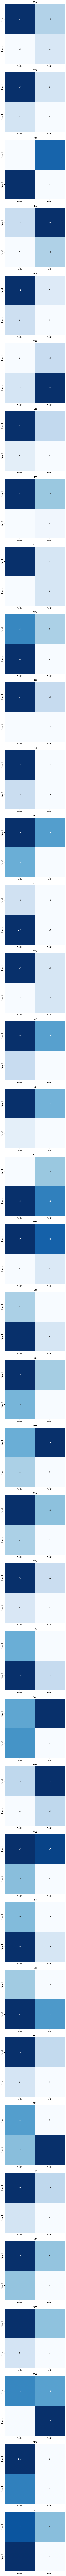

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming `df` is your DataFrame
df_confusion_matrix = RESULTS_xgbos[['split', 'test_true_0_pred_0',
       'test_true_0_pred_1', 'test_true_1_pred_0', 'test_true_1_pred_1']].set_index('split')

fig, axes = plt.subplots(df_confusion_matrix.shape[0], figsize=(5, df_confusion_matrix.shape[0]*5))

for ax, (index, row) in zip(axes.flat, df_confusion_matrix.iterrows()):
    cm = np.array(row).reshape((2,2))
    sns.heatmap(cm, annot=True, fmt='.0f', ax=ax, cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    ax.set_title(index)

plt.tight_layout()
plt.show()

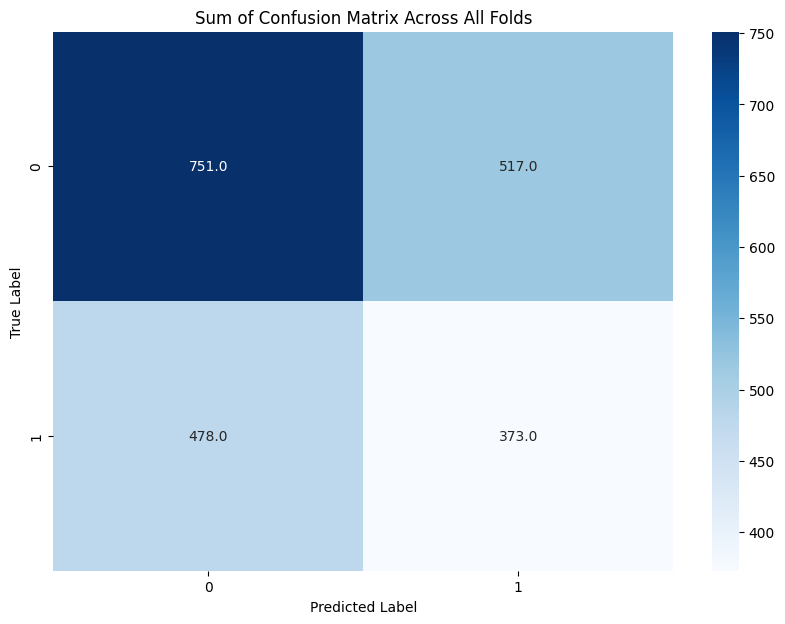

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming `df` is your DataFrame
df_confusion_matrix = RESULTS_xgbos[['split', 'test_true_0_pred_0',
       'test_true_0_pred_1', 'test_true_1_pred_0', 'test_true_1_pred_1']].set_index('split')

# Calculate the mean of confusion matrix values across all folds
mean_confusion_matrix = df_confusion_matrix.sum()

# Convert the mean values into a 2x2 confusion matrix
matrix = mean_confusion_matrix.values.reshape(2, 2)

# Plot the averaged confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt=".1f", cmap='Blues')
plt.title("Sum of Confusion Matrix Across All Folds")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [107]:
import pandas as pd


SUMMARY_EVAL = []

for row in RESULTS_EVAL.groupby(
    ['label', 'alg']
).agg(summary).reset_index().itertuples():
    for k, v in row._asdict().items():
        if type(v) is dict:
            r = dict(
                label=row.label,
                alg=row.alg,
                metric=k,
                **v
            )
            SUMMARY_EVAL.append(r)

SUMMARY_EVAL = pd.DataFrame(SUMMARY_EVAL)    
SUMMARY_EVAL.head()

label    alg       metric   n  cardinality  \
0  stress  dummy        split  38         38.0   
1  stress  dummy    n_feature  38          NaN   
2  stress  dummy    test_inst  38          NaN   
3  stress  dummy  test_inst_0  38          NaN   
4  stress  dummy  test_inst_1  38          NaN   

                                         value_count       sum         mean  \
0  P77:1, P79:1, P60:1, P80:1, P61:1, P55:1, P53:...       NaN          NaN   
1                                                NaN  127414.0  3353.000000   
2                                                NaN    2119.0    55.763158   
3                                                NaN    1268.0    33.368421   
4                                                NaN     851.0    22.394737   

          SD     med         range                                    conf.  \
0        NaN     NaN           NaN                                      NaN   
1   0.000000  3353.0  (3353, 3353)                               (nan, nan)   
2  13.684543    52.5      (36, 83)   (51.26516057520961, 60.26115521426407)   
3  10.928319    31.5      (16, 59)  (29.776371848872785, 36.96047025639038)   
4  11.129555    20.0       (8, 55)  (18.736543083809057, 26.05293060040147)   

   nan_count  
0        NaN  
1        0.0  
2        0.0  
3        0.0  
4        0.0

Below shows metrics of our interest only.

In [108]:
SUB_SUMMARY_EVAL = SUMMARY_EVAL.loc[
    lambda x: x['metric'].isin(
        ['n_feature', 'train_class_ratio', 'train_inst_0', 'train_inst_1', 'test_inst_0', 'test_inst_1', 'test_acc', 'test_f1_0' ,'test_f1_1', 'test_f1_macro', 'train_f1_0' ,'train_f1_1', 'train_f1_macro','test_roauc']
    )
].round(3).assign(
    mean_sd=lambda x: x['mean'].astype(str).str.cat(' (' + x['SD'].astype(str) + ')', sep='')
).pivot(
    index=['label', 'alg'], columns=['metric'], values=['mean_sd']
)
SUB_SUMMARY_EVAL

mean_sd                                               \
metric               n_feature       test_acc      test_f1_0      test_f1_1   
label  alg                                                                    
stress dummy      3353.0 (0.0)  0.604 (0.141)  0.743 (0.116)      0.0 (0.0)   
       rf_ns   184.211 (6.099)  0.598 (0.124)  0.725 (0.109)  0.173 (0.101)   
       rf_os   184.211 (6.099)  0.577 (0.101)  0.672 (0.115)  0.307 (0.151)   
       xgb_ns  184.211 (6.099)  0.554 (0.093)  0.656 (0.104)   0.299 (0.13)   
       xgb_os  184.211 (6.099)   0.531 (0.09)  0.586 (0.131)   0.392 (0.14)   

                                                                              \
metric         test_f1_macro      test_inst_0     test_inst_1     test_roauc   
label  alg                                                                     
stress dummy   0.372 (0.058)  33.368 (10.928)  22.395 (11.13)      0.5 (0.0)   
       rf_ns   0.449 (0.082)  33.368 (10.928)  22.395 (11.13)  0.543 (0.094)   
       rf_os   0.489 (0.074)  33.368 (10.928)  22.395 (11.13)  0.532 (0.102)   
       xgb_ns  0.478 (0.074)  33.368 (10.928)  22.395 (11.13)  0.498 (0.081)   
       xgb_os  0.489 (0.076)  33.368 (10.928)  22.395 (11.13)  0.512 (0.089)   

                                                                              \
metric        train_class_ratio     train_f1_0     train_f1_1 train_f1_macro   
label  alg                                                                     
stress dummy       1.49 (0.027)  0.749 (0.003)      0.0 (0.0)  0.374 (0.002)   
       rf_ns       1.49 (0.027)      1.0 (0.0)      1.0 (0.0)      1.0 (0.0)   
       rf_os          1.0 (0.0)      1.0 (0.0)      1.0 (0.0)      1.0 (0.0)   
       xgb_ns      1.49 (0.027)  0.897 (0.027)   0.825 (0.06)  0.861 (0.043)   
       xgb_os         1.0 (0.0)  0.939 (0.007)  0.939 (0.007)  0.939 (0.007)   

                                                     
metric              train_inst_0       train_inst_1  
label  alg                                           
stress dummy   1234.632 (10.928)    828.605 (11.13)  
       rf_ns   1234.632 (10.928)    828.605 (11.13)  
       rf_os   1234.632 (10.928)  1234.632 (10.928)  
       xgb_ns  1234.632 (10.928)    828.605 (11.13)  
       xgb_os  1234.632 (10.928)  1234.632 (10.928)

# Feature Importances (Tree Feature Importance)

## Implementation

In [65]:
from typing import Union, Optional


def feature_importance(
    estimator
):
    if not hasattr(estimator, 'feature_names_in_') or not hasattr(estimator, 'feature_importances_'):
        return None
    
    names = estimator.feature_names_in_
    importances = estimator.feature_importances_
    
    return names, importances

## Execution

In [66]:
import os
import pandas as pd
from collections import defaultdict


IMPORTANCE_EVAL = defaultdict(list)
DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')

# for l in ['valence', 'arousal', 'disturbance', 'stress']:
for l in ['stress']:
    dir_l = os.path.join(DIR_EVAL, l)
    if not os.path.exists(dir_l):
        continue
    
    for f in os.listdir(dir_l):
        if f!='.ipynb_checkpoints':

            res = load(os.path.join(dir_l, f))

            f_norm = f[:f.index('.pkl')]
            alg = f_norm[:f.rindex('#')]

            feat_imp = feature_importance(res.estimator)
            if not feat_imp:
                continue

            names, importance = feat_imp
            new_names = []
            for n in names:
                for c in res.categories:
                    n = n.replace(f'{c}_', f'{c}=')
                new_names.append(n)

            d = pd.DataFrame(
                importance.reshape(1, -1),
                columns=new_names
            )
            IMPORTANCE_EVAL[(l, alg)].append(d)
        

IMPORTANCE_SUMMARY = []

for (l, alg), v in IMPORTANCE_EVAL.items():
    new_v = pd.concat(
        v, axis=0
    ).fillna(0.0).mean().reset_index().set_axis(
        ['feature', 'importance'], axis=1
    ).assign(
        label=l,
        alg=alg
    )
    IMPORTANCE_SUMMARY.append(new_v)
    
IMPORTANCE_SUMMARY = pd.concat(IMPORTANCE_SUMMARY, axis=0, ignore_index=True)


### Plot

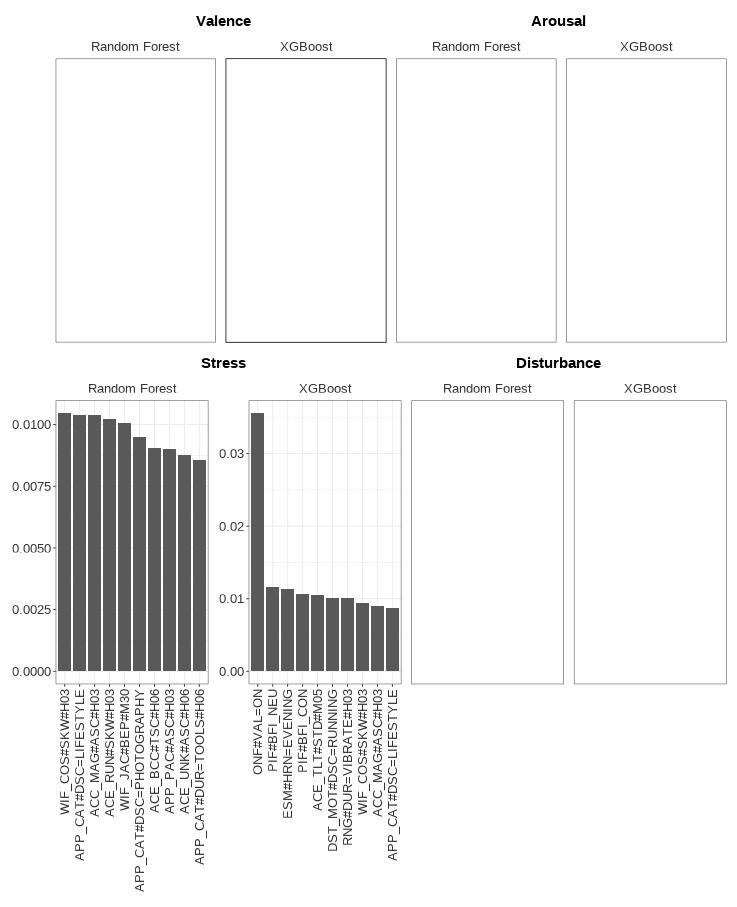

In [67]:
%%R -i IMPORTANCE_SUMMARY -w 26 -h 32 -u cm

plots <- list()

for (l in c('valence', 'arousal', 'stress', 'disturbance')) {
    data <- IMPORTANCE_SUMMARY %>% filter(
        (label == l)
    )

    p_label <- ggplot() + geom_text(
        aes(x=.5, y=.5),
        label=str_to_title(l), 
        family='ssp', 
        fontface='bold',
        size=4
    ) + theme_void()

    p_rf <- ggplot(
        data %>% filter(alg == 'rf_os') %>% top_n(n=10, wt=importance),
        aes(x=reorder(feature, -importance), y=importance),
    ) + geom_col(
    ) + THEME_DEFAULT + theme(
        axis.text.x=element_text(angle=90, size=10, hjust=1, vjust=.5),
        axis.title.x=element_blank(),
        axis.title.y=element_blank()
    ) + labs(
        subtitle='Random Forest'
    )
    
    p_xgb <- ggplot(
        data %>% filter(alg == 'xgb_os') %>% top_n(n=10, wt=importance),
        aes(x=reorder(feature, -importance), y=importance),
    ) + geom_col(
    ) + THEME_DEFAULT + theme(
        axis.text.x=element_text(angle=90, size=10, hjust=1, vjust=.5),
        axis.title.x=element_blank(),
        axis.title.y=element_blank()
    ) + labs(
        subtitle='XGBoost'
    )
    
    plots[[paste(l, 'label', sep='_')]] <- p_label
    plots[[paste(l, 'rf', sep='_')]] <- p_rf
    plots[[paste(l, 'xgb', sep='_')]] <- p_xgb
}

p <- plots$valence_label + plots$arousal_label
p <- p / (plots$valence_rf | plots$valence_xgb | plots$arousal_rf | plots$arousal_xgb)
p <- p / (plots$stress_label + plots$disturbance_label)
p <- p / (plots$stress_rf | plots$stress_xgb | plots$disturbance_rf | plots$disturbance_xgb)

p <- p + plot_layout(
    heights=c(1.1, 10, 1.1, 10)
)

ggsave(paste('./fig/imp.pdf'), plot=p, width=26, height=32, unit='cm', device=cairo_pdf)
print(p)


# Feature Importances (Shap)

In [68]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap

def feature_importance_shap(estimator, X):
    explainer = None
    # Check if the estimator is an instance of RandomForest
    if isinstance(estimator, RandomForestClassifier):
        explainer = shap.Explainer(estimator)
    elif isinstance(estimator, DummyClassifier):
        return None
    elif isinstance(estimator.model, XGBClassifier):
        # Pass the inner model to the explainer
        explainer = shap.Explainer(estimator.model)
    else:
        print("Estimator not supported:", type(estimator))
        return None

    shap_values = explainer.shap_values(X)
    if isinstance(shap_values, list): # Handling for binary classification in RandomForest
        shap_values = shap_values[1]
    names = X.columns if hasattr(estimator, 'feature_names_in_') else None # get feature names from the model itself
    return names, np.abs(shap_values).mean(axis=0)

In [69]:
import os
import pandas as pd
from collections import defaultdict
import ray

with on_ray():
    IMPORTANCE_EVAL = defaultdict(list)
    DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')

    @ray.remote
    def process_file(file_path, dir_l):
        res = load(os.path.join(dir_l, file_path))

        f_norm = file_path[:file_path.index('.pkl')]
        fold = f_norm[f_norm.rindex('#')+1:]
        alg = f_norm[:file_path.rindex('#')]

        feat_imp = feature_importance_shap(res.estimator, res.X_test)
        if not feat_imp:
            return None

        names, importance = feat_imp
        new_names = []
        for n in names:
            for c in res.categories:
                n = n.replace(f'{c}_', f'{c}=')
            new_names.append(n)

        d = pd.DataFrame(
            importance.reshape(1, -1),
            columns=new_names
        )
        return (l, fold, alg, d)


    file_tasks = []
    for l in ['stress']:
        dir_l = os.path.join(DIR_EVAL, l)
        if not os.path.exists(dir_l):
            continue

        for f in os.listdir(dir_l):
            if f != '.ipynb_checkpoints':
                file_tasks.append(process_file.remote(f, dir_l))

    IMPORTANCE_SUMMARY = []
    results = ray.get(file_tasks)
    for result in results:
        if result is not None:
            l, fold, alg, d = result
            IMPORTANCE_EVAL[(l, fold, alg)].append(d)

    for (l, fold, alg), v in IMPORTANCE_EVAL.items():
        new_v = pd.concat(
            v, axis=0
        ).fillna(0.0).mean().reset_index().set_axis(
            ['feature', 'importance'], axis=1
        ).assign(
            label=l,
            fold=fold,
            alg=alg
        )
        IMPORTANCE_SUMMARY.append(new_v)

    IMPORTANCE_SUMMARY = pd.concat(IMPORTANCE_SUMMARY, axis=0, ignore_index=True)


2023-07-20 14:22:26,036	INFO worker.py:1452 -- Connecting to existing Ray cluster at address: 192.168.1.54:6379...
2023-07-20 14:22:26,057	INFO worker.py:1627 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
(pid=311586, ip=192.168.1.49) /home/iclab1209/miniconda3/envs/sci-data/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
(pid=311586, ip=192.168.1.49)   def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
(pid=311586, ip=192.168.1.49) /home/iclab1209/miniconda3/envs/sci-data/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argum

(process_file pid=311608, ip=192.168.1.49) ntree_limit is deprecated, use `iteration_range` or model slicing instead. [repeated 3x across cluster]


In [70]:
IMPORTANCE_SUMMARY_xgb_os = IMPORTANCE_SUMMARY[IMPORTANCE_SUMMARY['alg'] =='xgb_os']

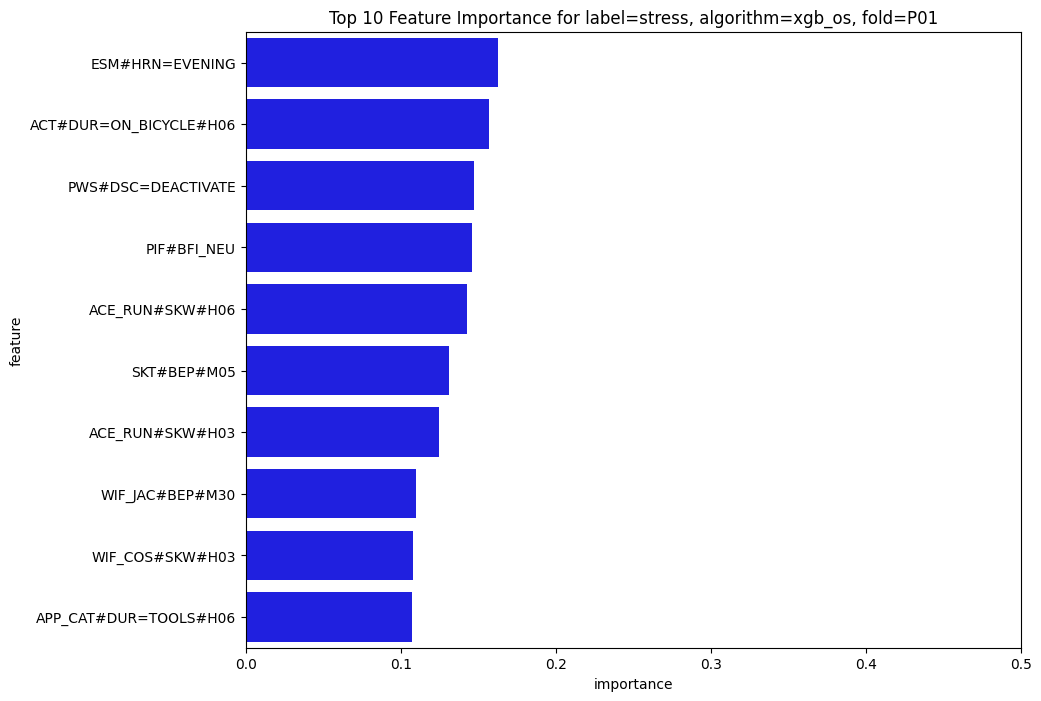

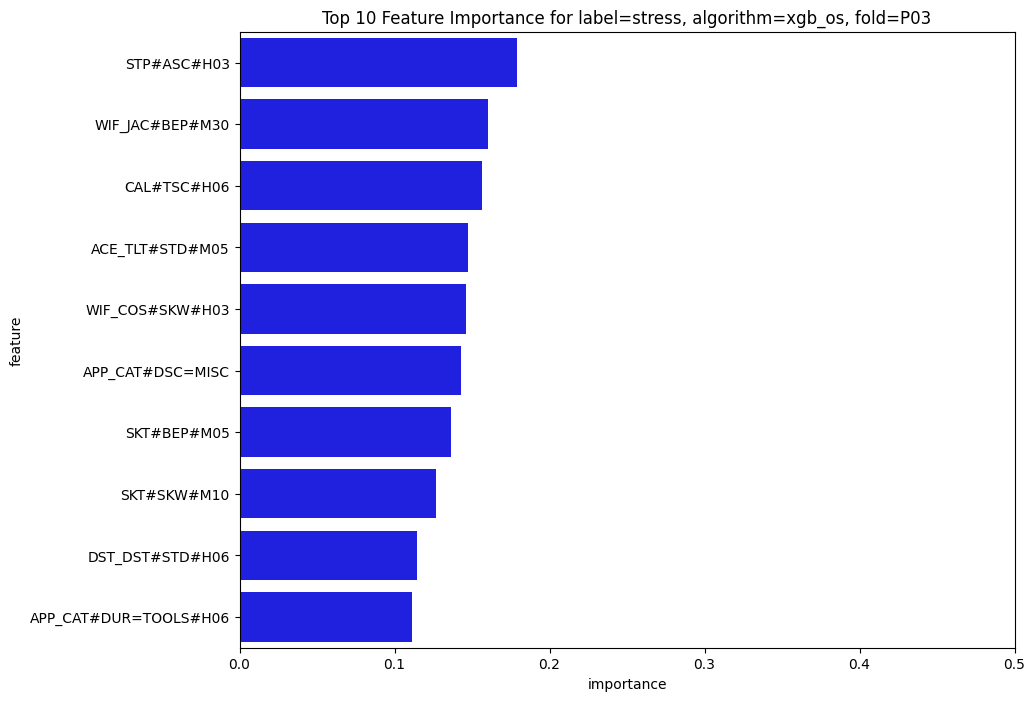

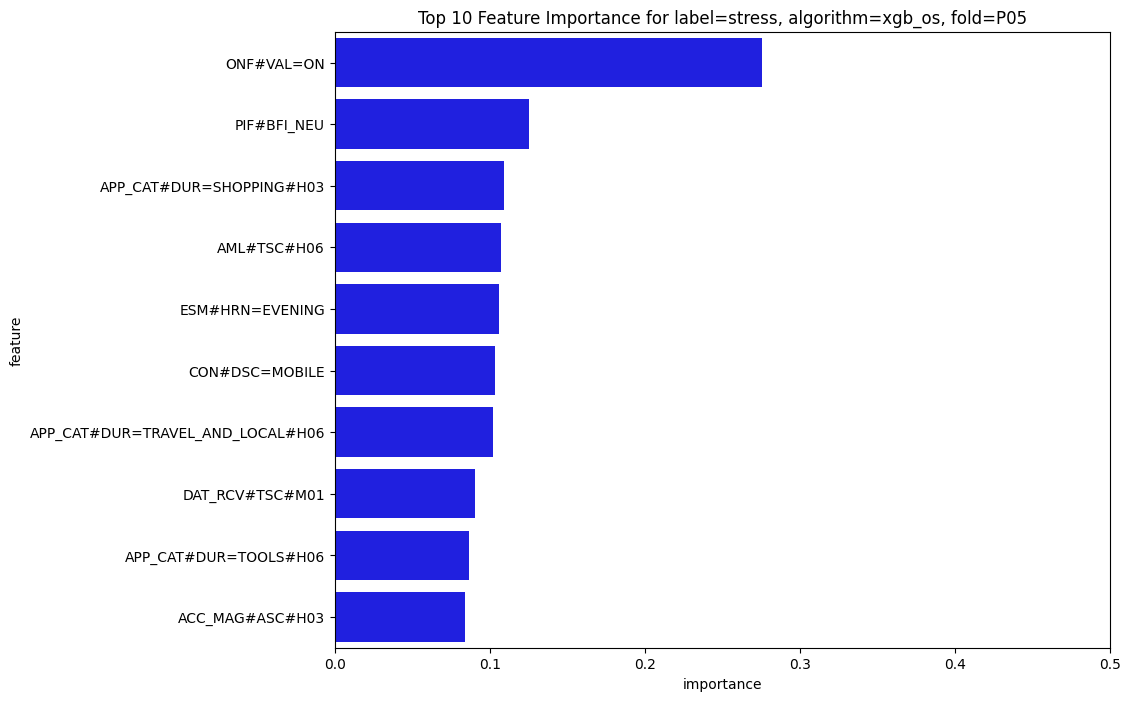

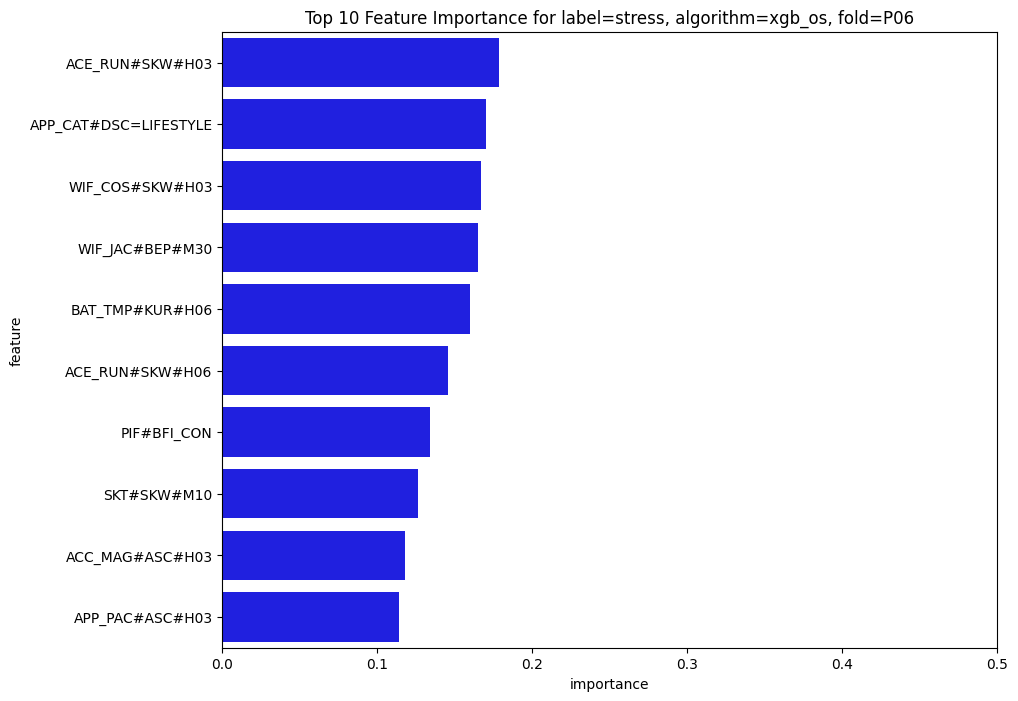

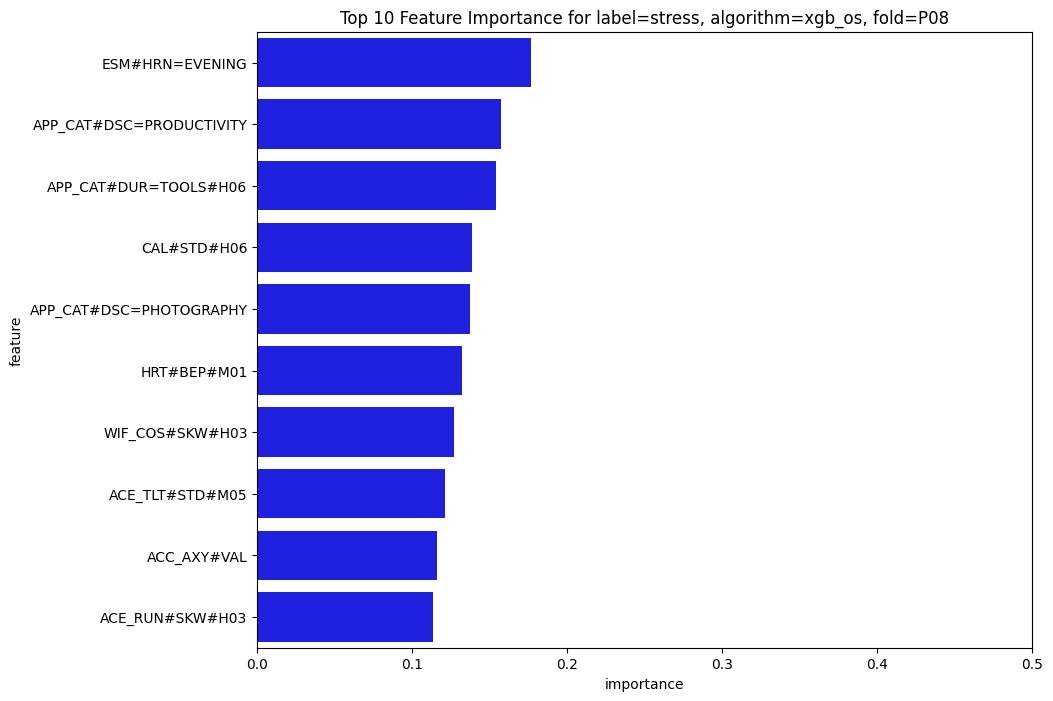

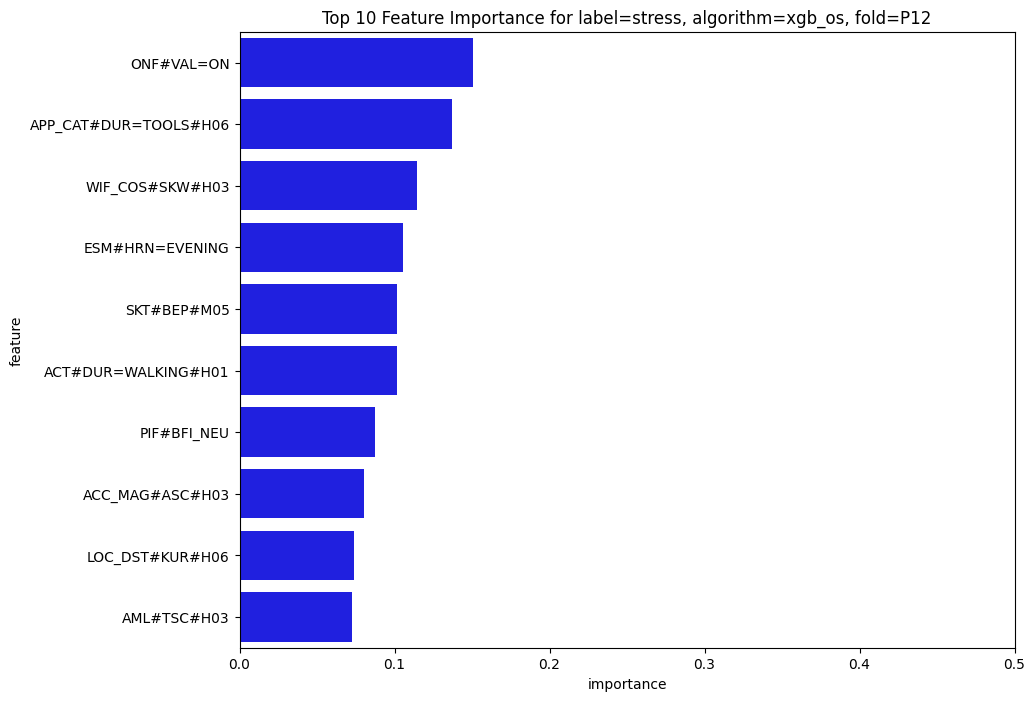

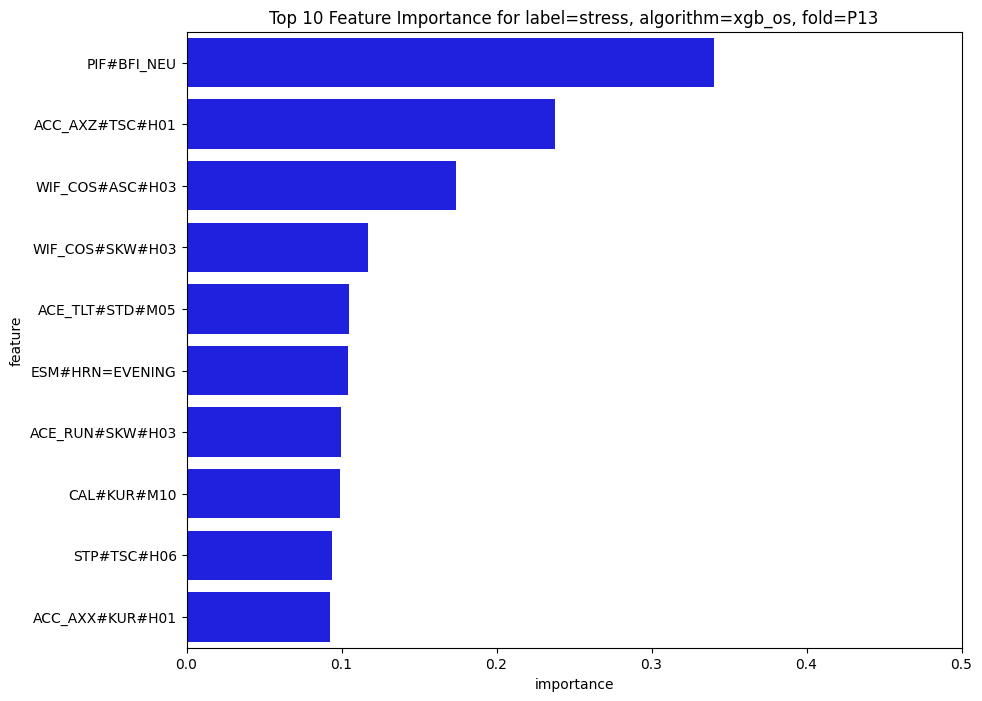

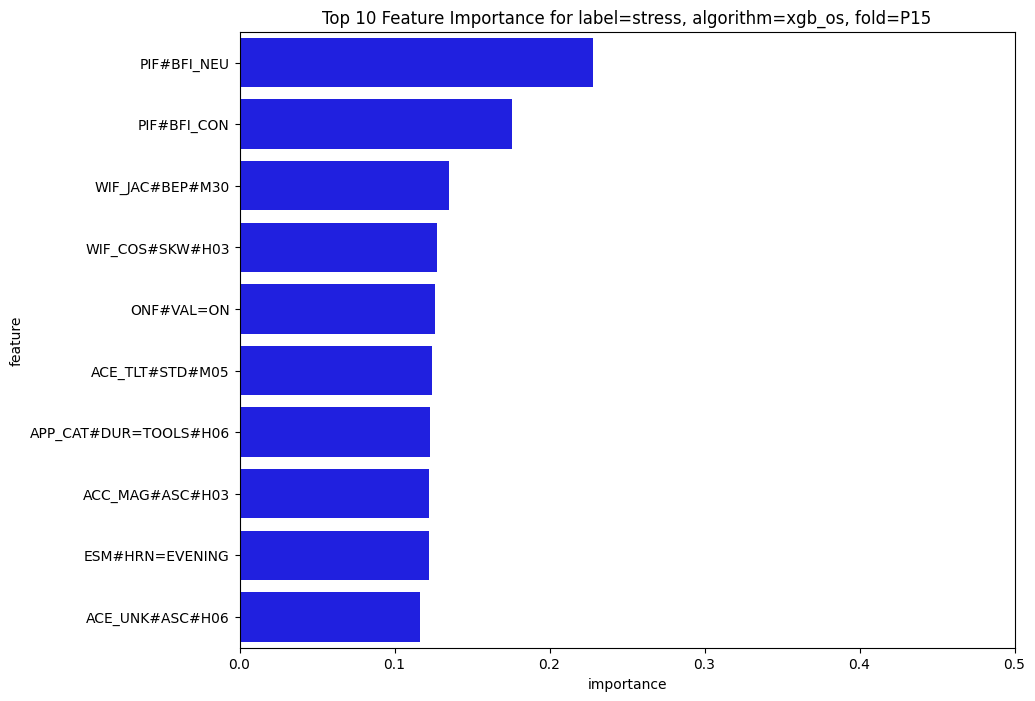

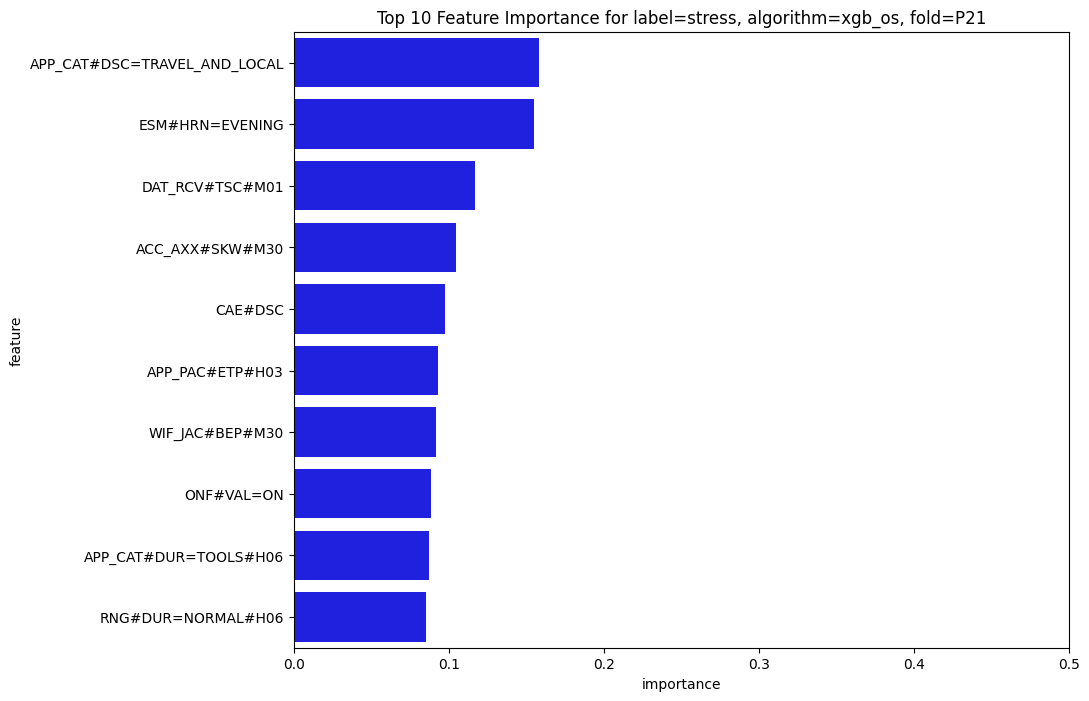

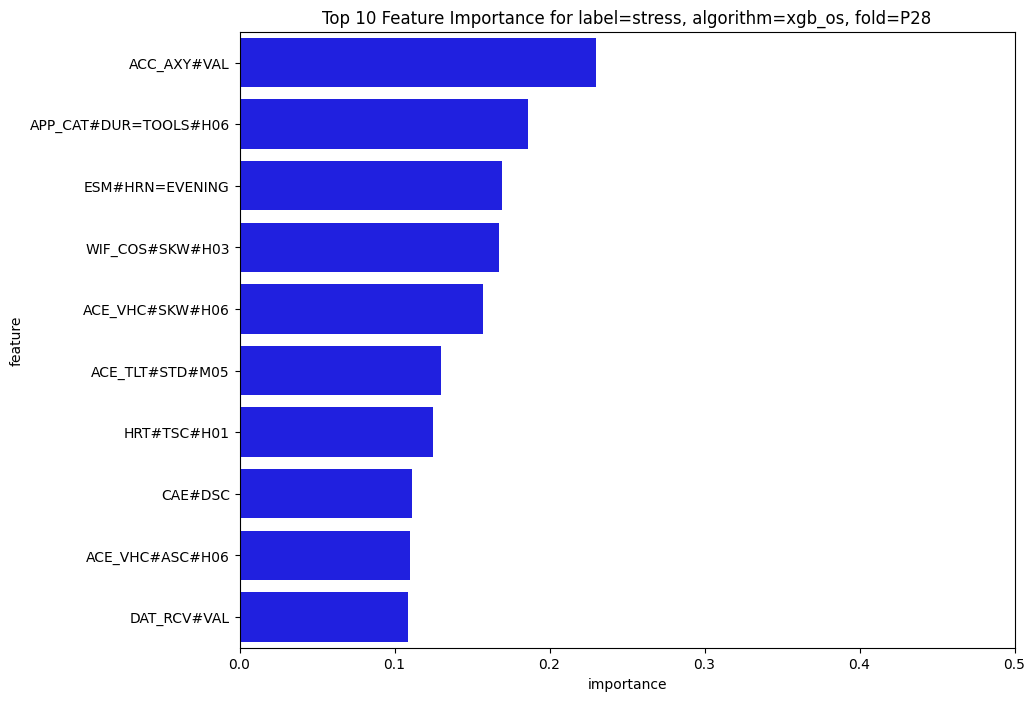

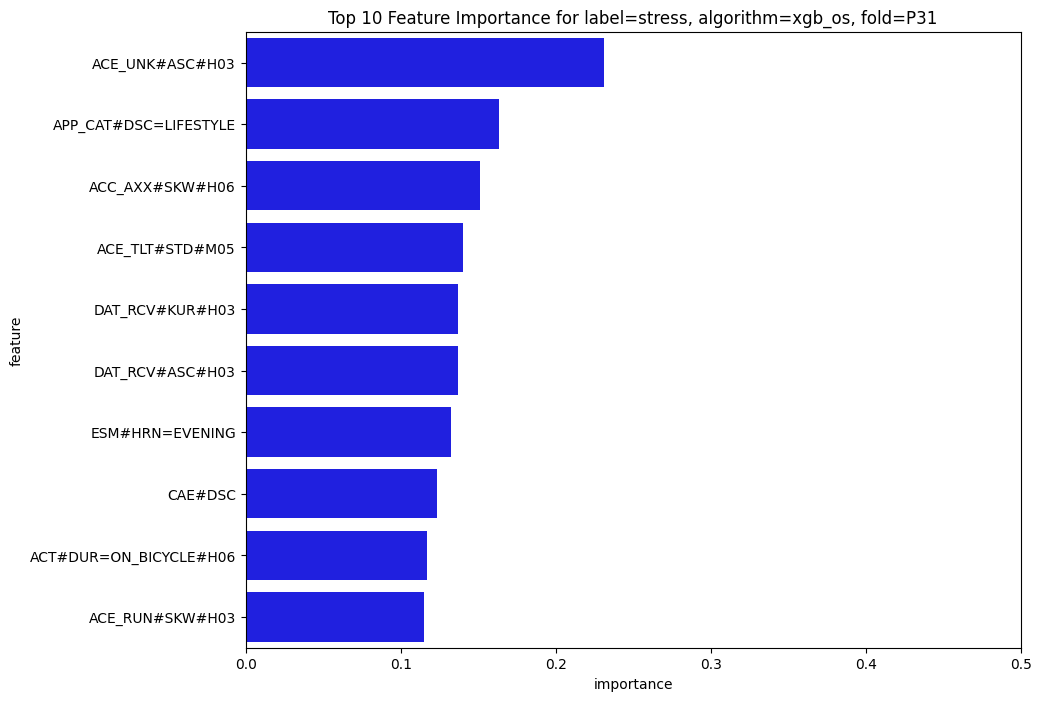

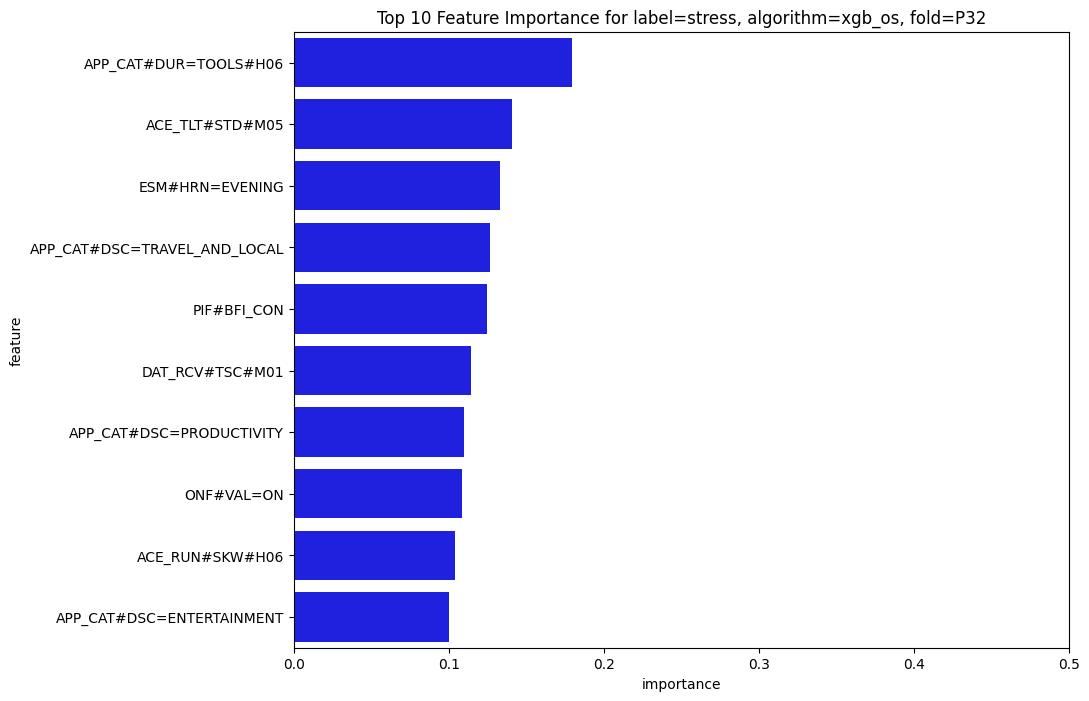

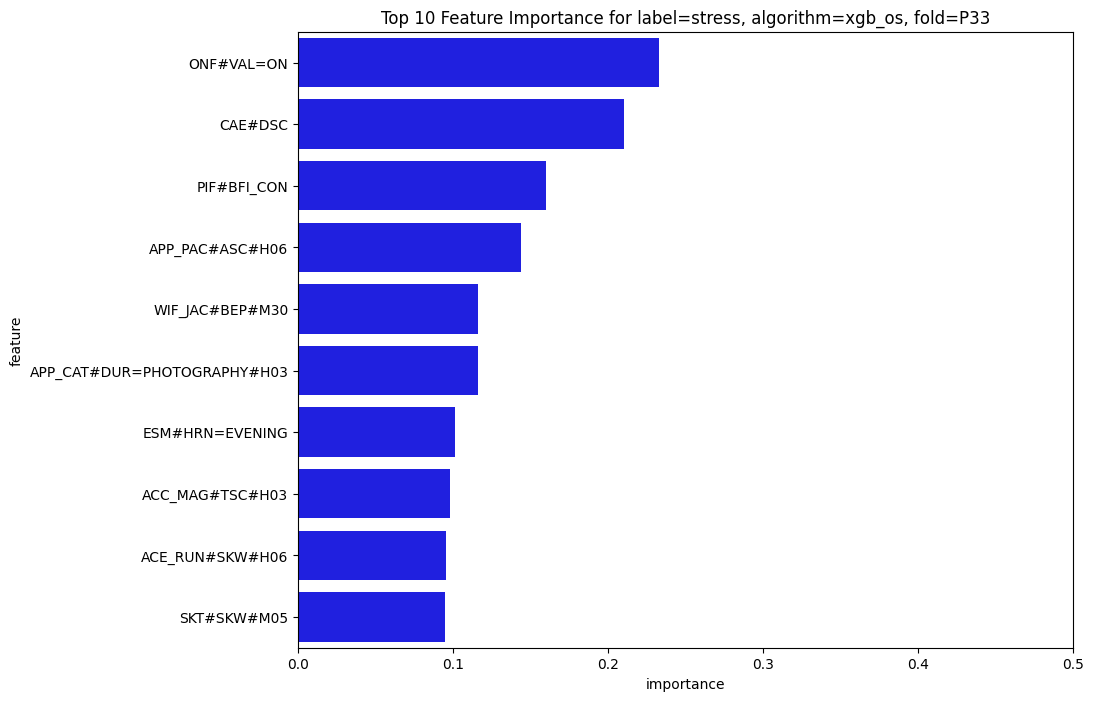

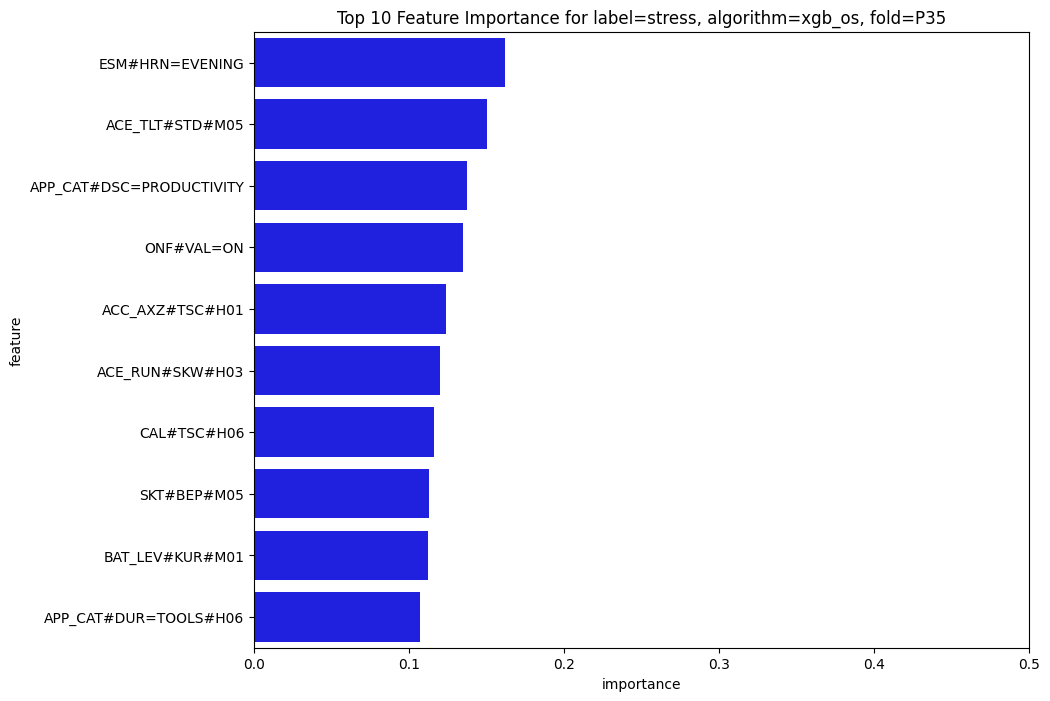

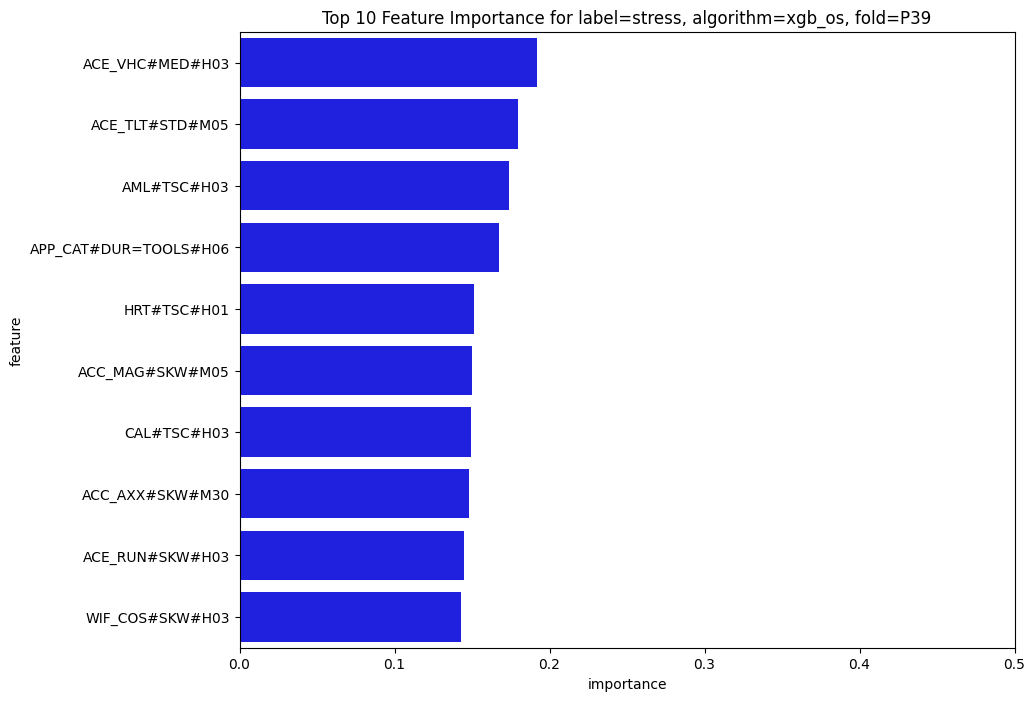

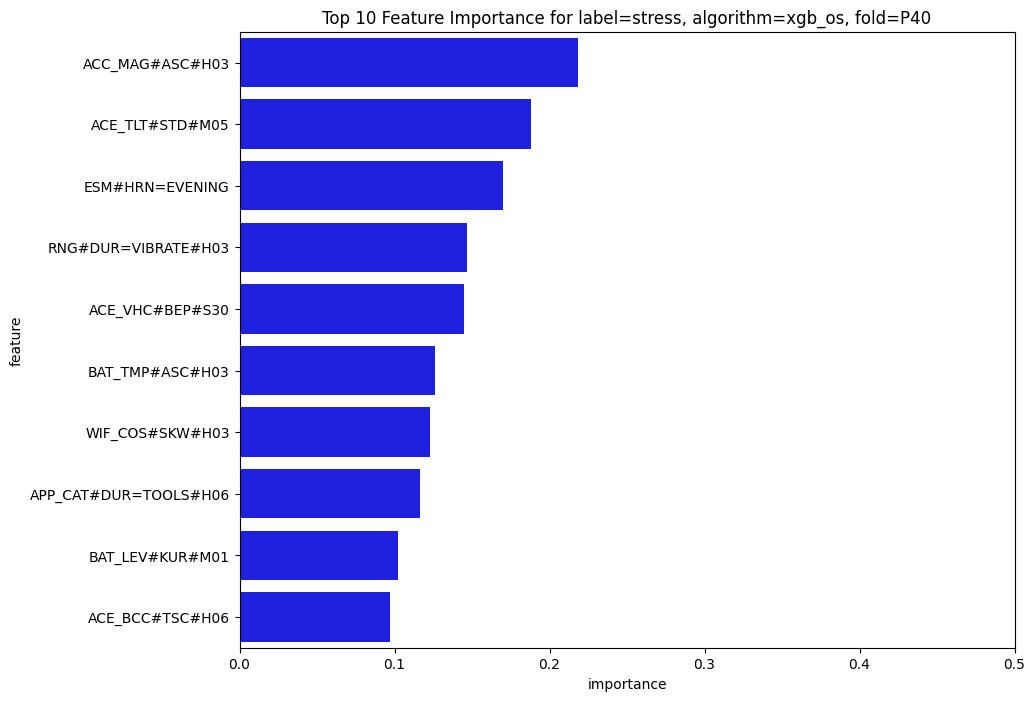

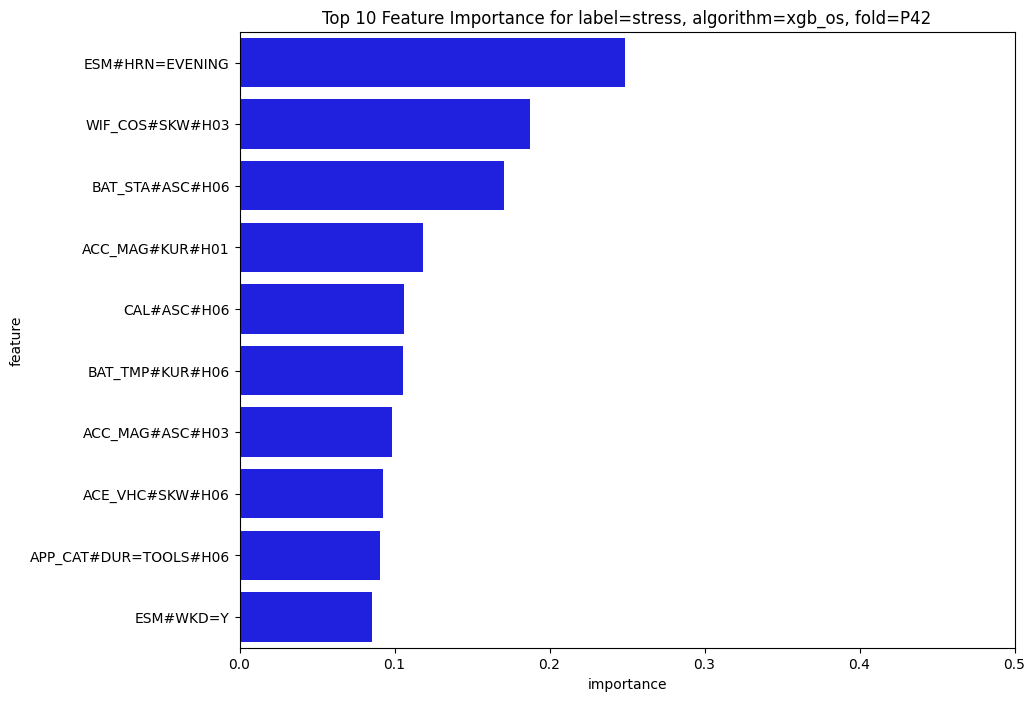

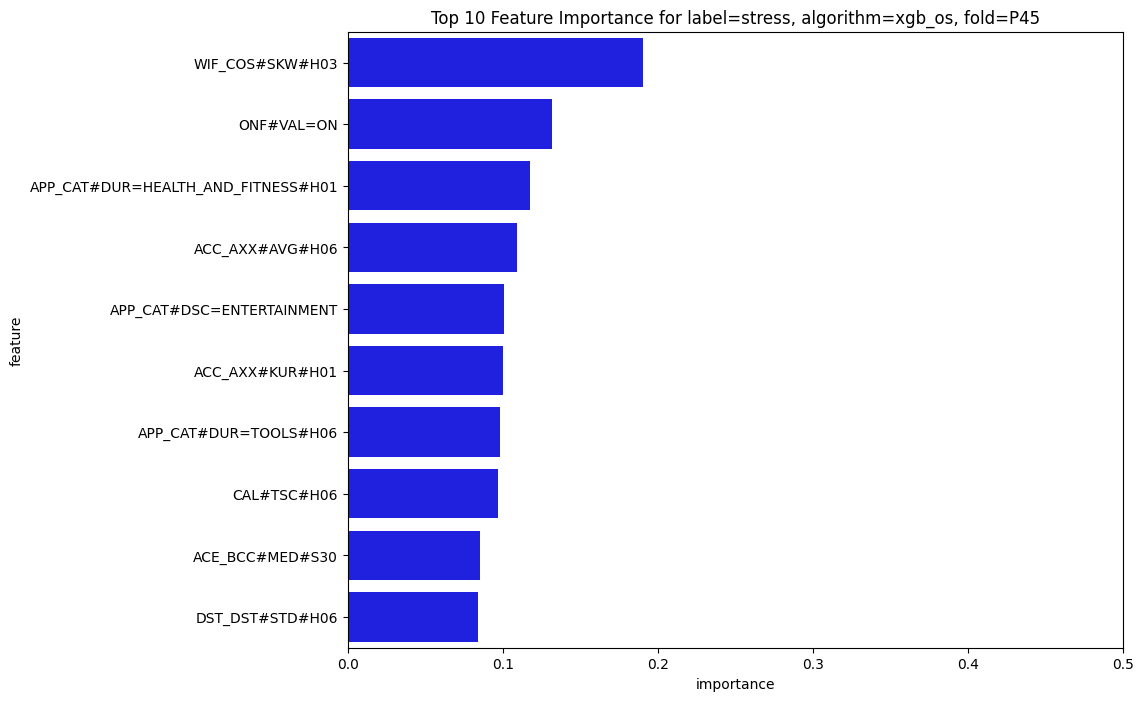

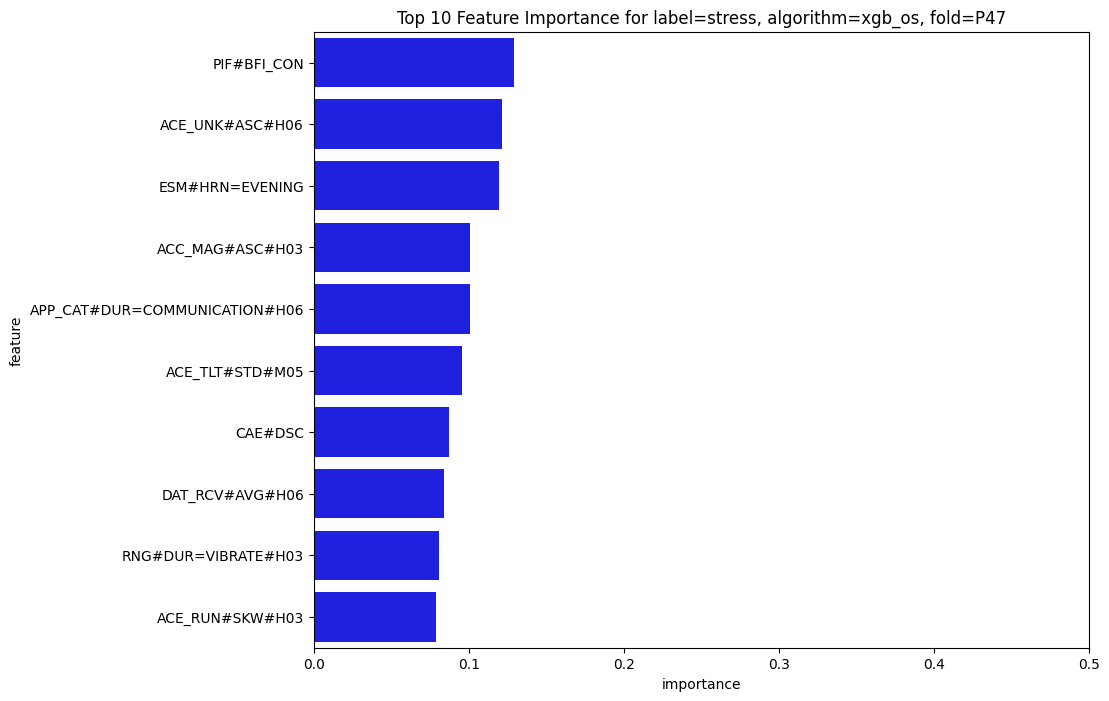

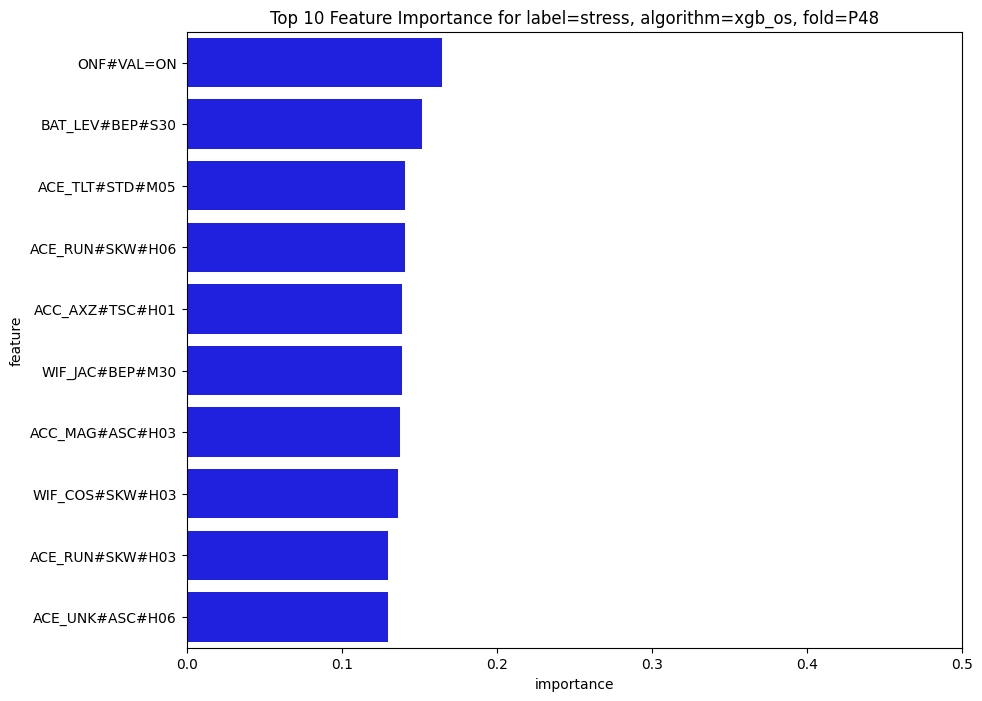

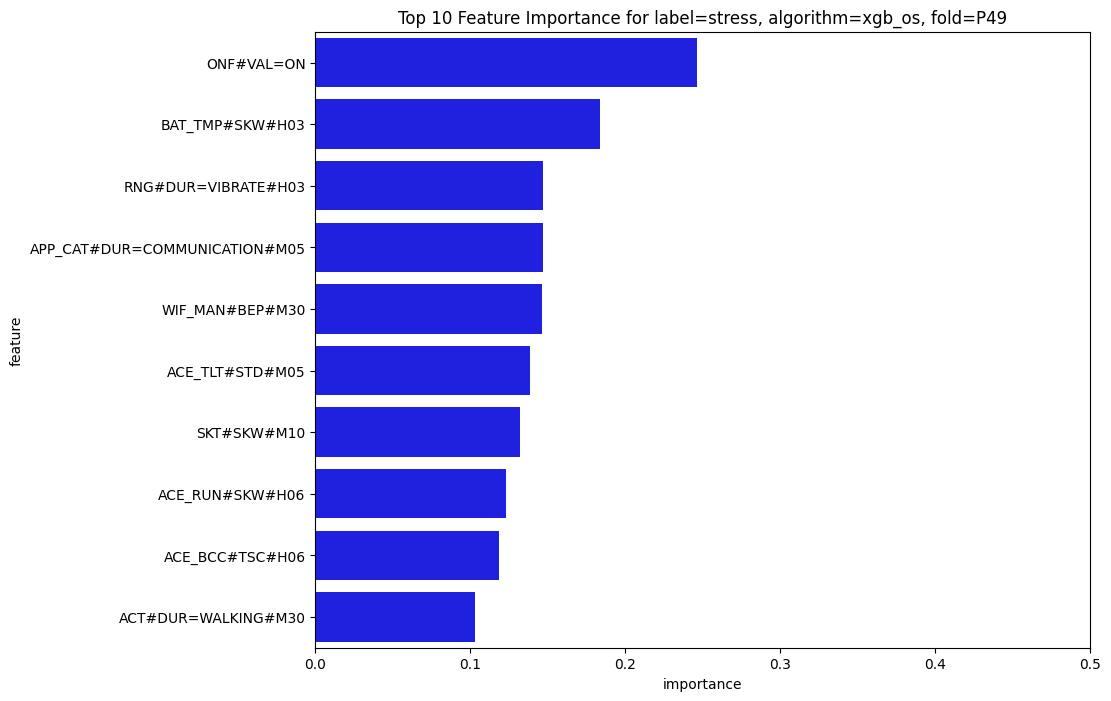

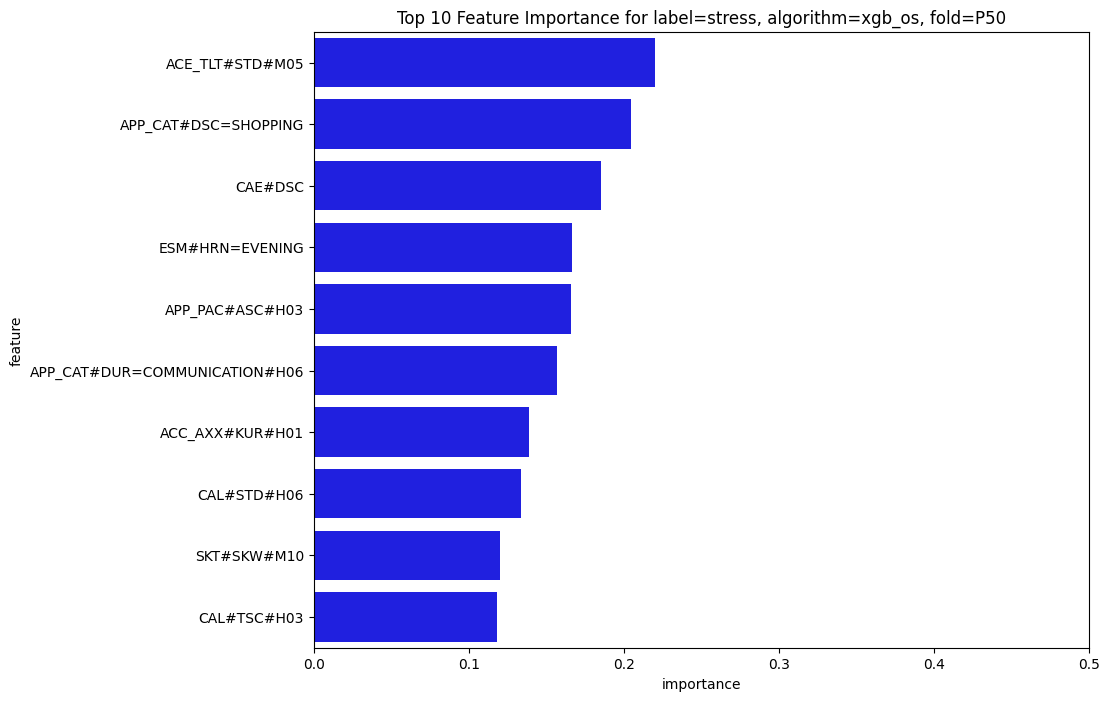

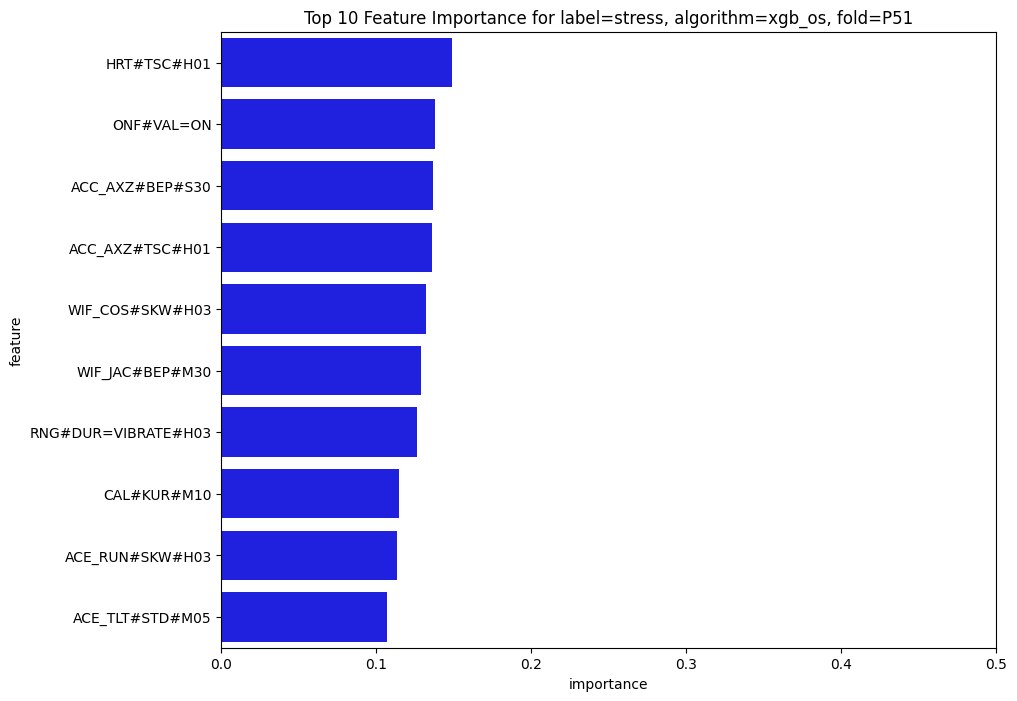

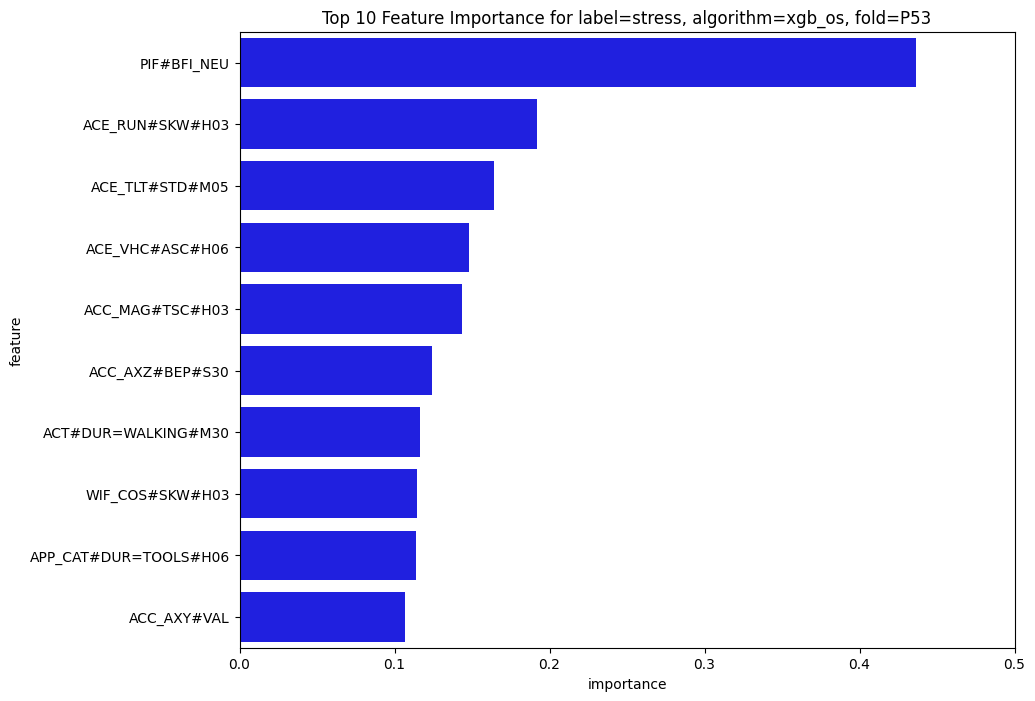

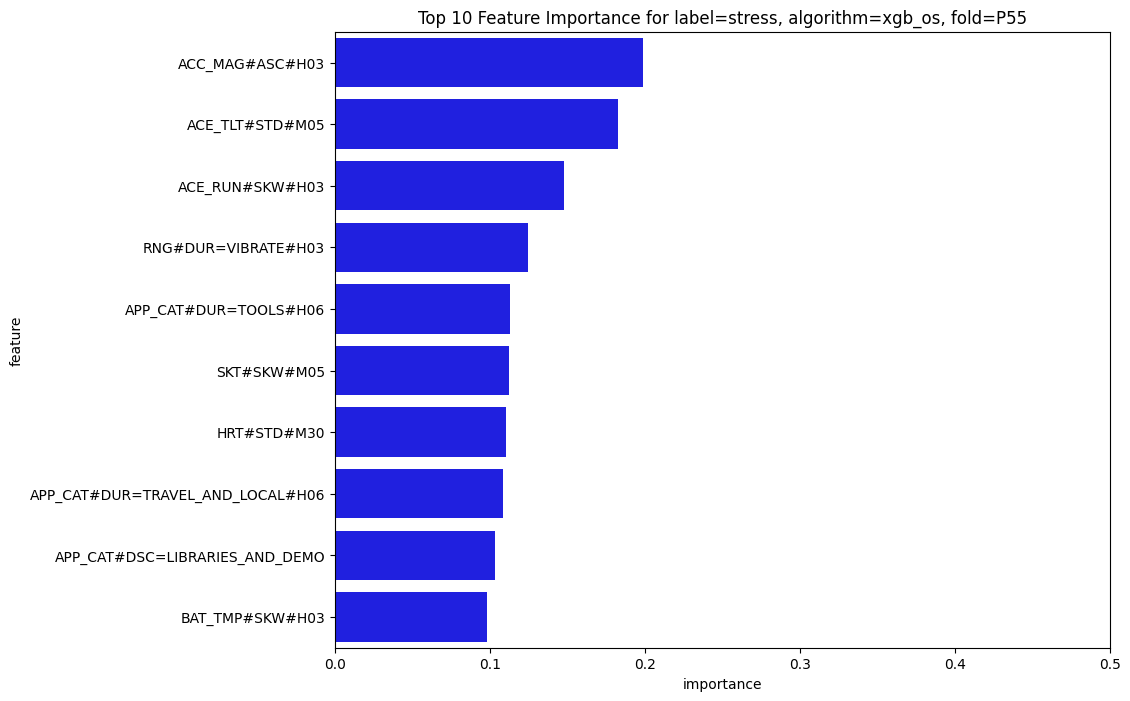

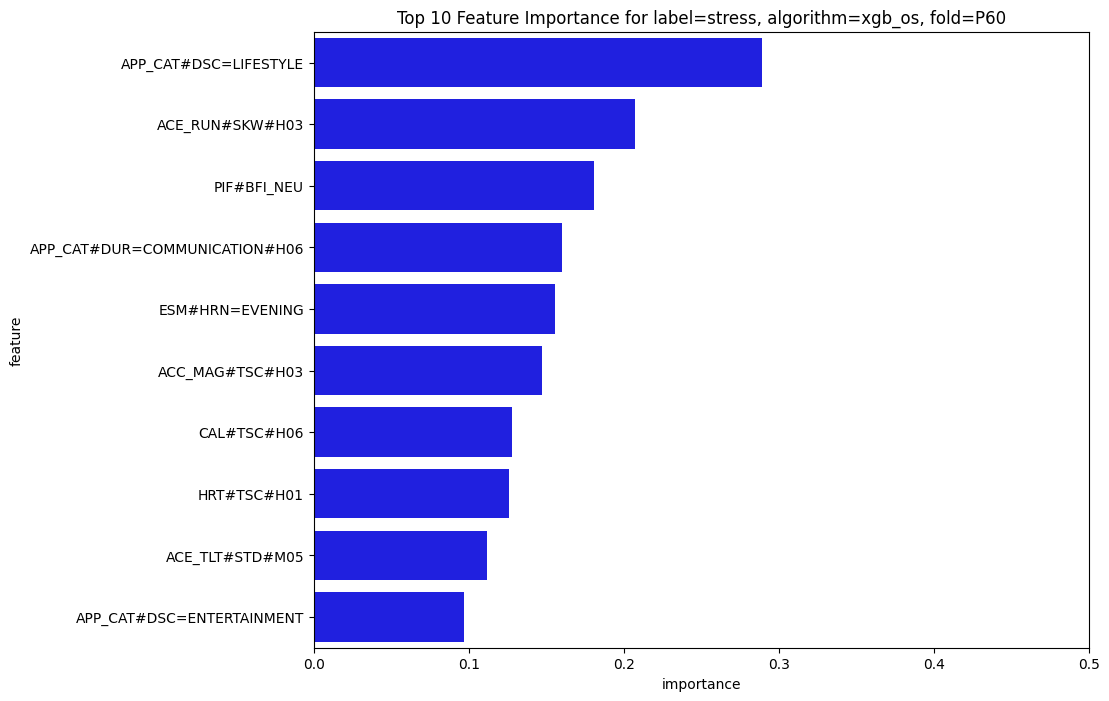

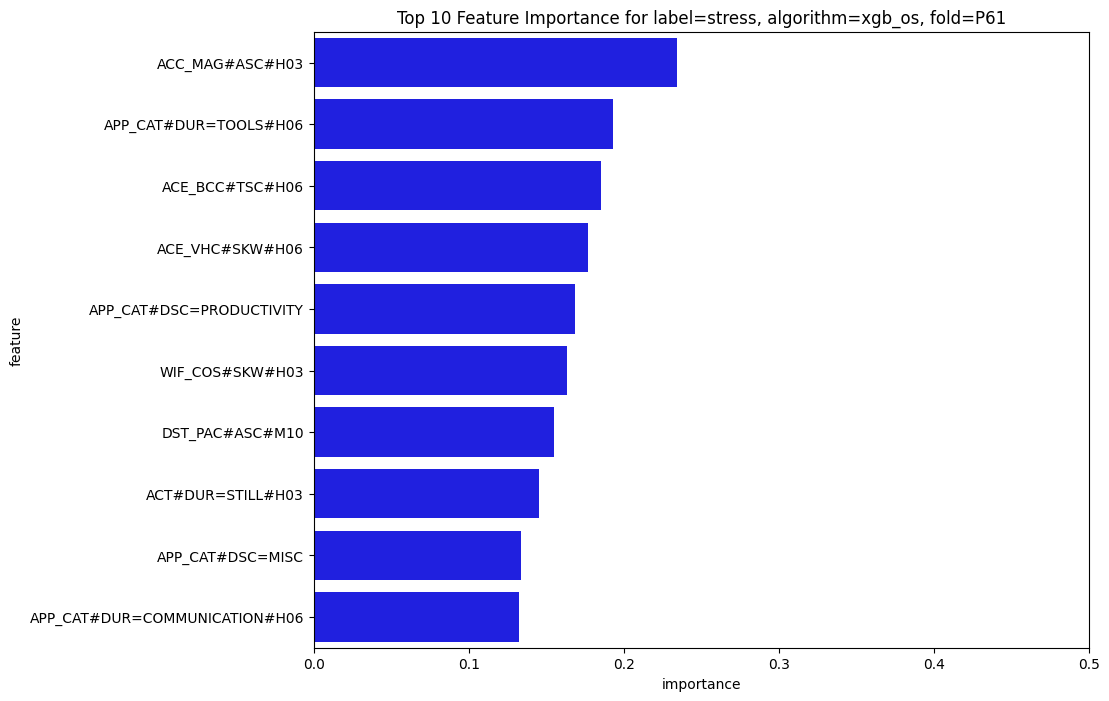

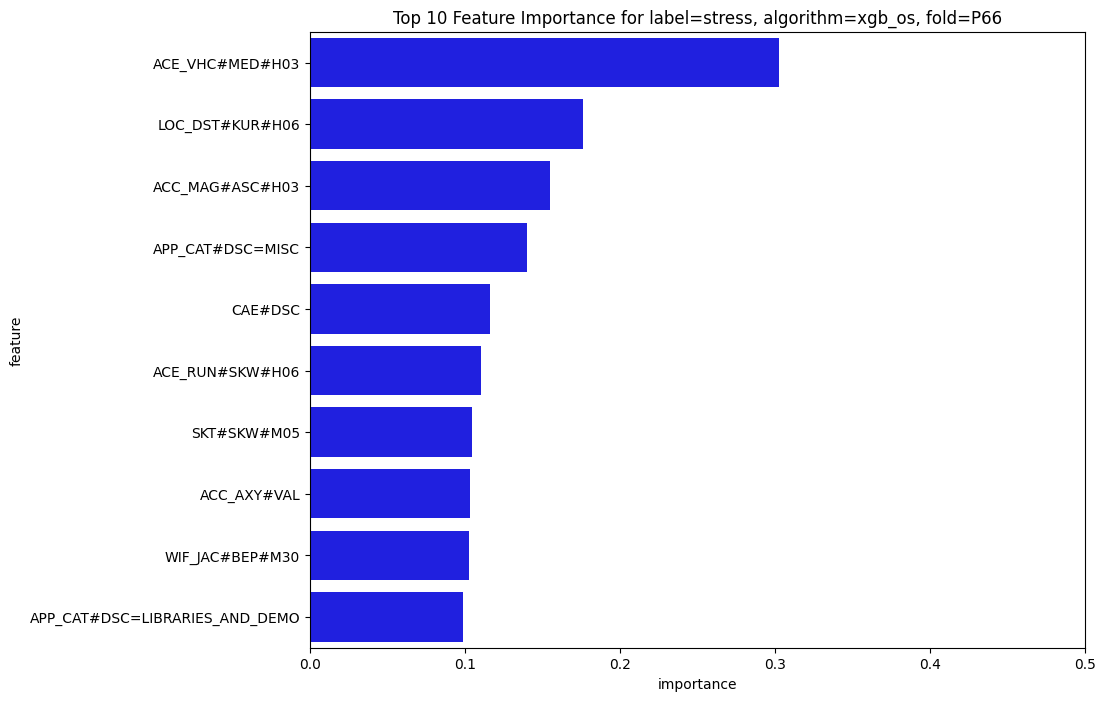

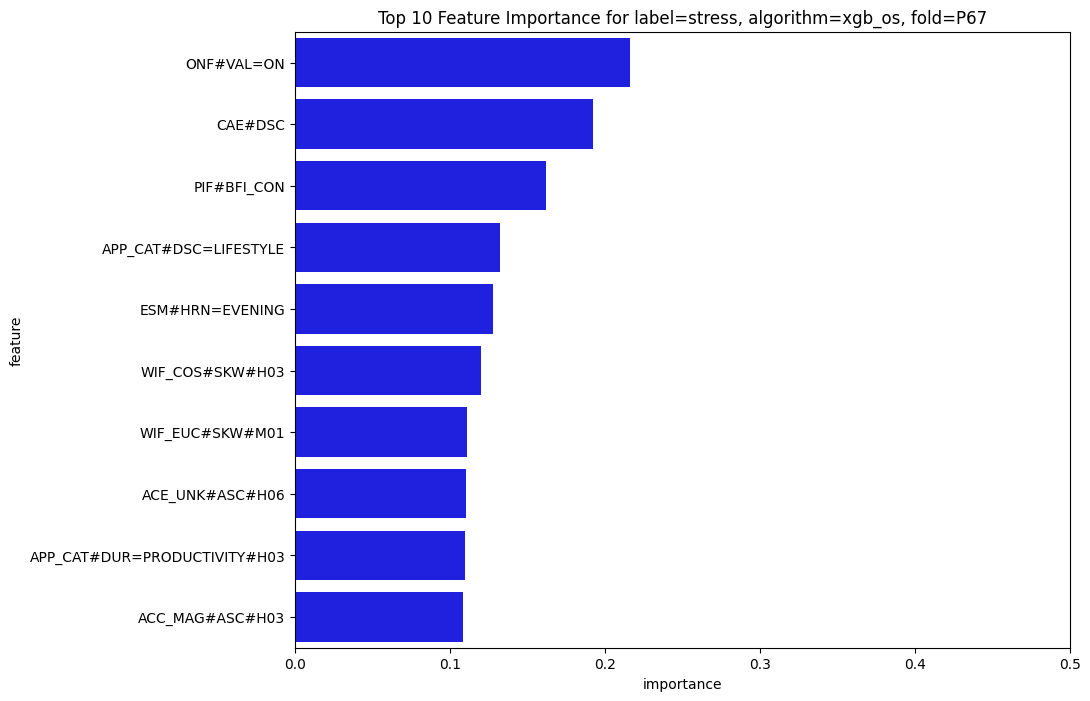

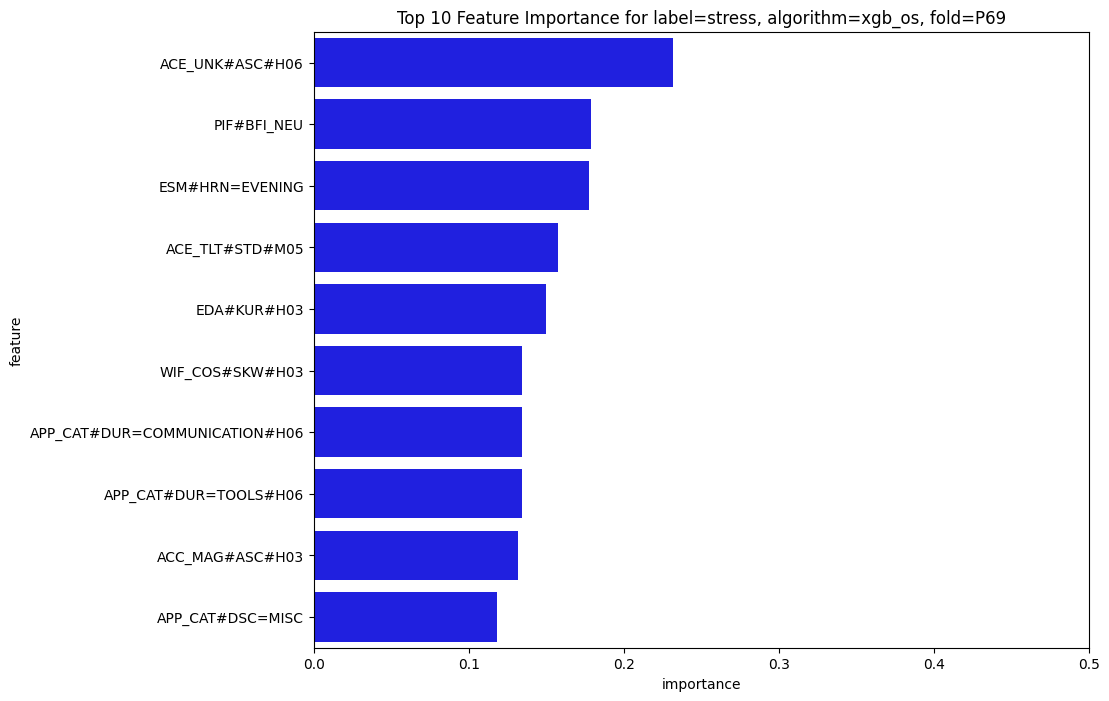

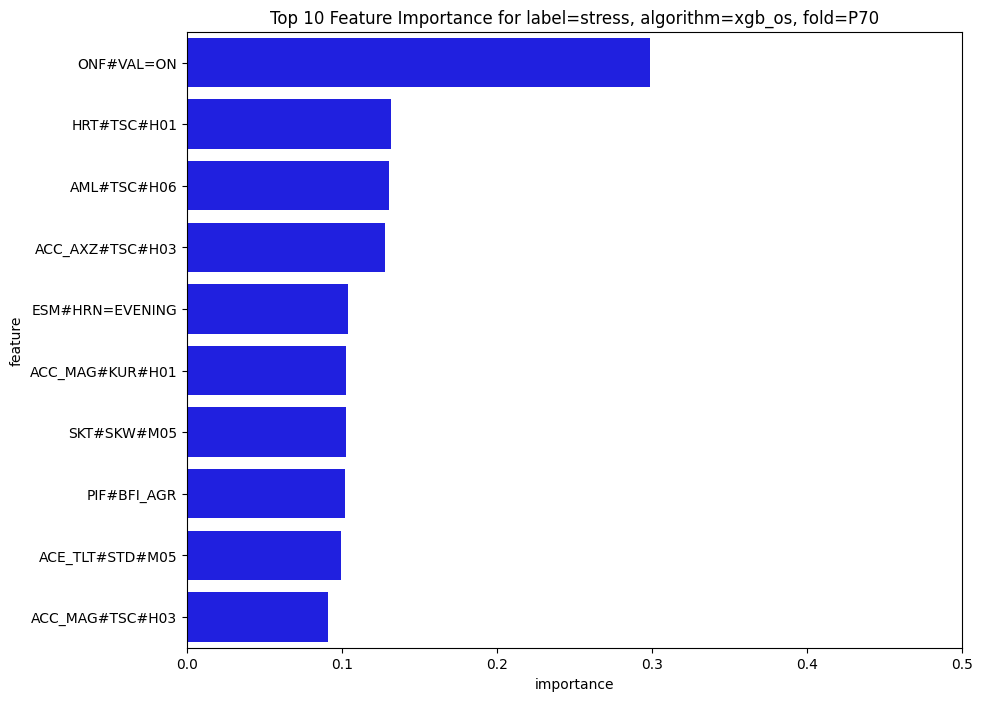

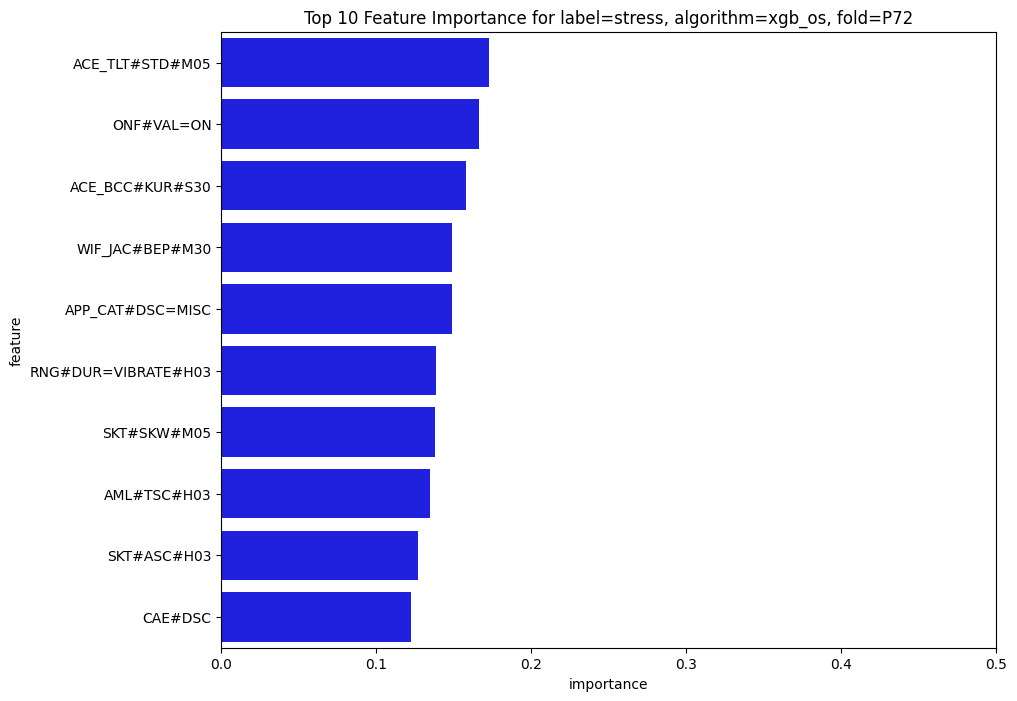

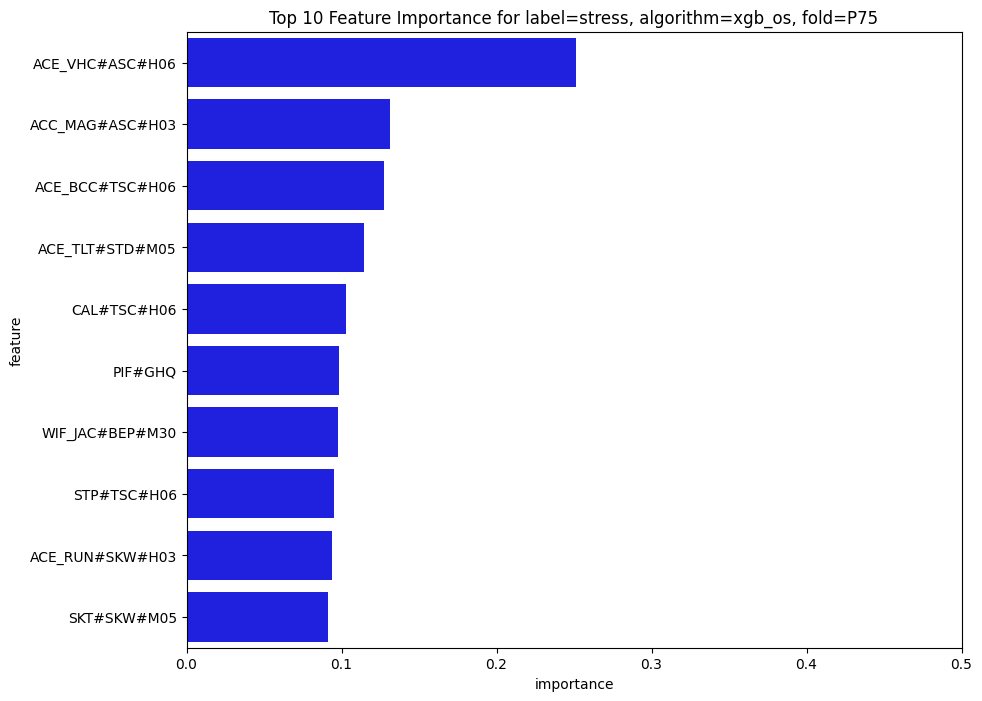

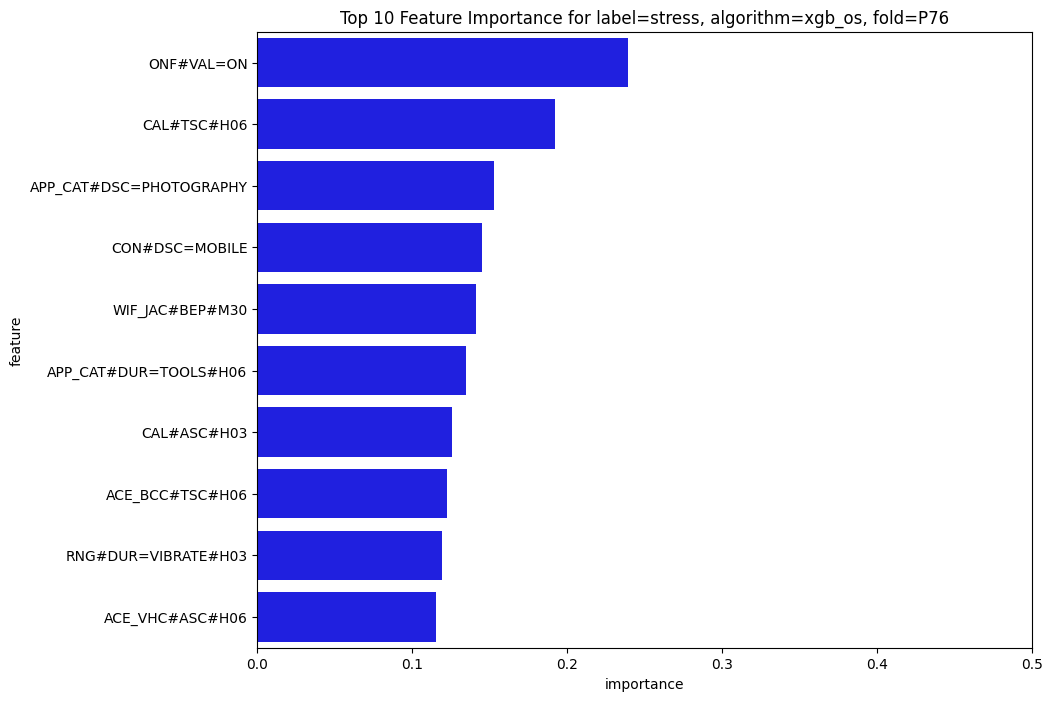

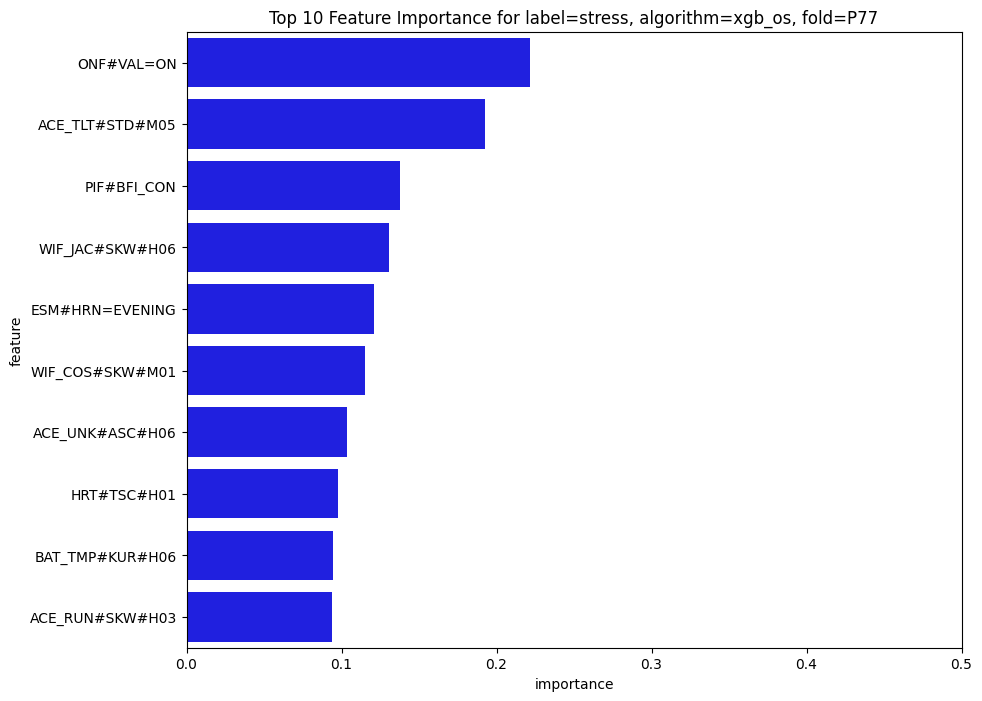

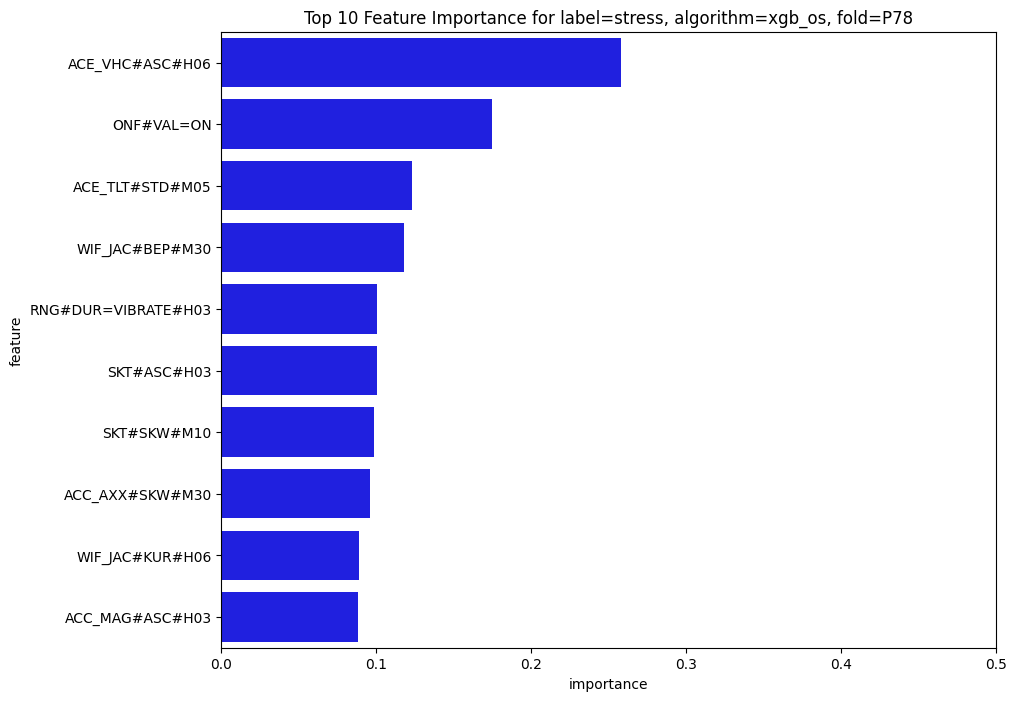

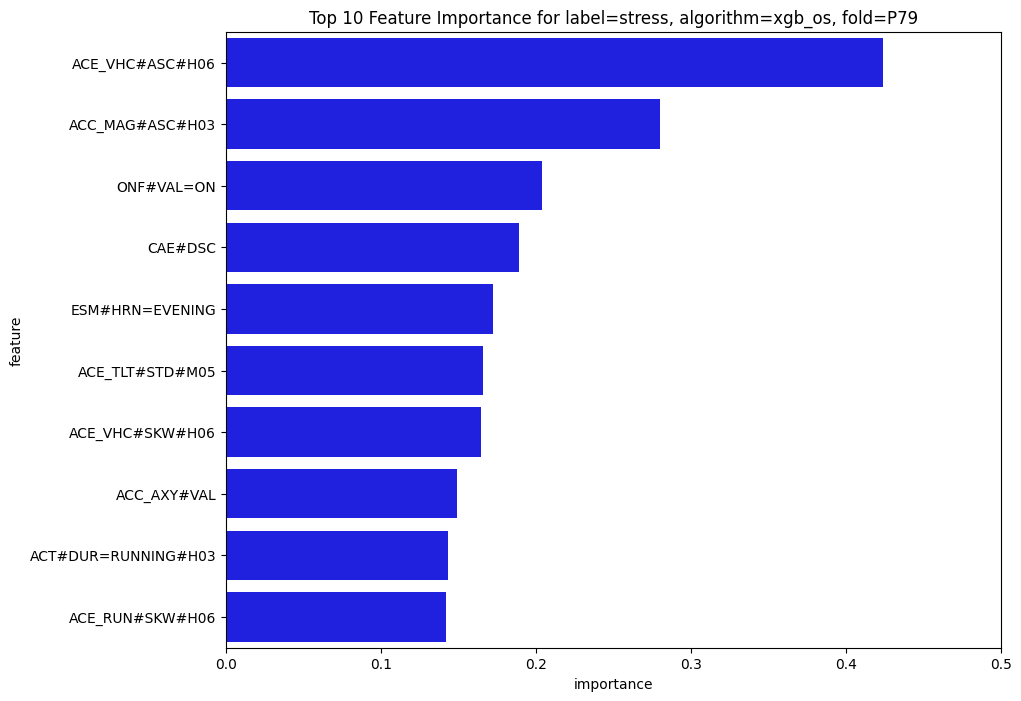

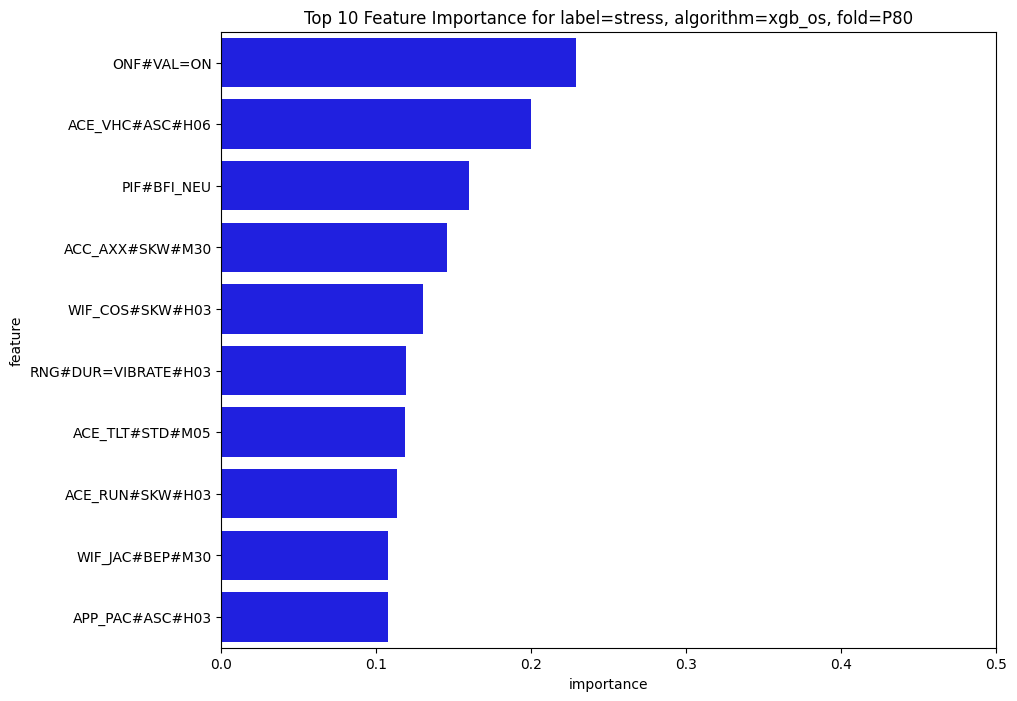

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a plot for each label, algorithm, and fold
for (l, alg, fold), df in IMPORTANCE_SUMMARY_xgb_os.groupby(['label', 'alg', 'fold']):
    # Get top 10 features
    df_top10 = df.dropna().sort_values(by='importance', ascending=False).head(10)
    plt.figure(figsize=(10,8))
    sns.barplot(data=df_top10, x='importance', y='feature', color='b')
    plt.title(f'Top 10 Feature Importance for label={l}, algorithm={alg}, fold={fold}')
    plt.xlim([0, 0.5])
    plt.show()

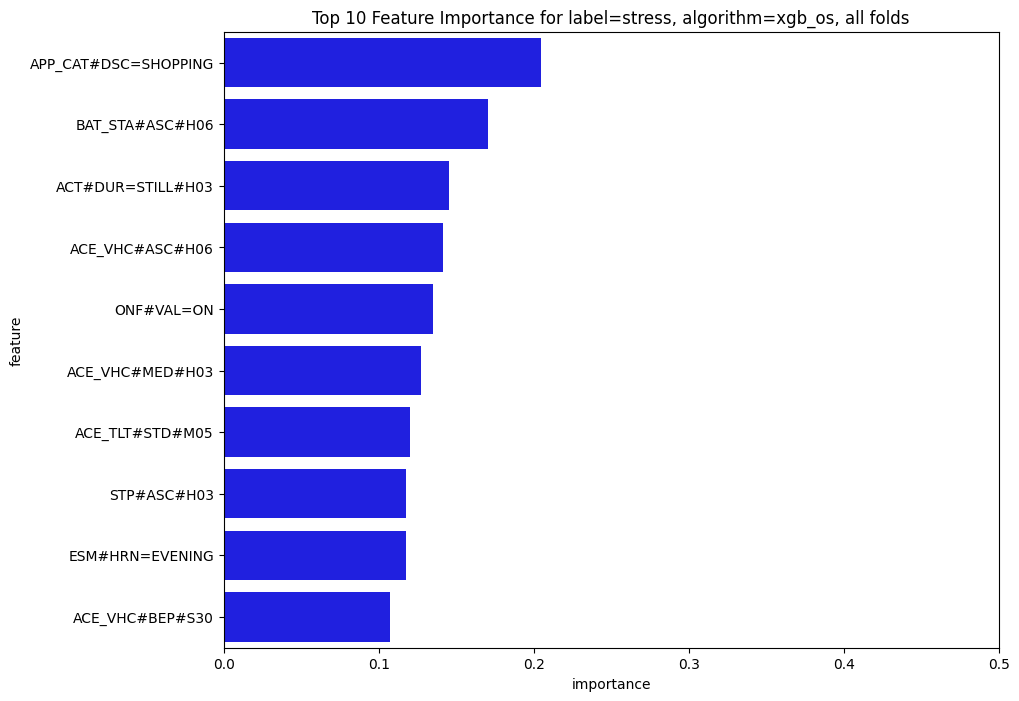

In [72]:
# Create a plot for each label and algorithm, aggregating all folds
for (l, alg), df in IMPORTANCE_SUMMARY_xgb_os.groupby(['label', 'alg']):
    # Aggregate the importance scores across folds and get top 10 features
    df_agg = df.groupby('feature')['importance'].mean().reset_index()
    df_agg_top10 = df_agg.sort_values(by='importance', ascending=False).head(10)

    plt.figure(figsize=(10,8))
    sns.barplot(data=df_agg_top10, x='importance', y='feature', color='b')
    plt.title(f'Top 10 Feature Importance for label={l}, algorithm={alg}, all folds')
    plt.xlim([0, 0.5])

    plt.show()

# Comparing High Performance Group and Low Performance Group

We already visualize individual feature importance and confusion matrix, but it is difficult to get meaningful insights from individual anlysis.
- As for ESM + [sensor, pif] (loso evaluation),
what is high performance and low performance (loso)?
    - We define high performance group as users who have higher than 0.6 macro F1 score
    - We define low performance group as users who have lower than 0.4 macro F1 score

## XGB_os

In [73]:
#Define what is high performance group and low performance group.
uid_low_performance =  RESULTS_xgbos[['split', 'test_f1_macro']].sort_values('test_f1_macro',ascending = True)[:4].split.values.tolist()
uid_high_performance = RESULTS_xgbos[['split', 'test_f1_macro']].sort_values('test_f1_macro',ascending = False)[:4].split.values.tolist()

In [74]:
uid_low_performance

['P13', 'P35', 'P77', 'P31']

In [75]:
uid_high_performance

['P48', 'P55', 'P32', 'P70']

In [76]:
IMPORTANCE_SUMMARY_xgb_os_high_performance = IMPORTANCE_SUMMARY_xgb_os.loc[IMPORTANCE_SUMMARY_xgb_os['fold'].isin(uid_high_performance)]
IMPORTANCE_SUMMARY_xgb_os_low_performance = IMPORTANCE_SUMMARY_xgb_os.loc[IMPORTANCE_SUMMARY_xgb_os['fold'].isin(uid_low_performance)]

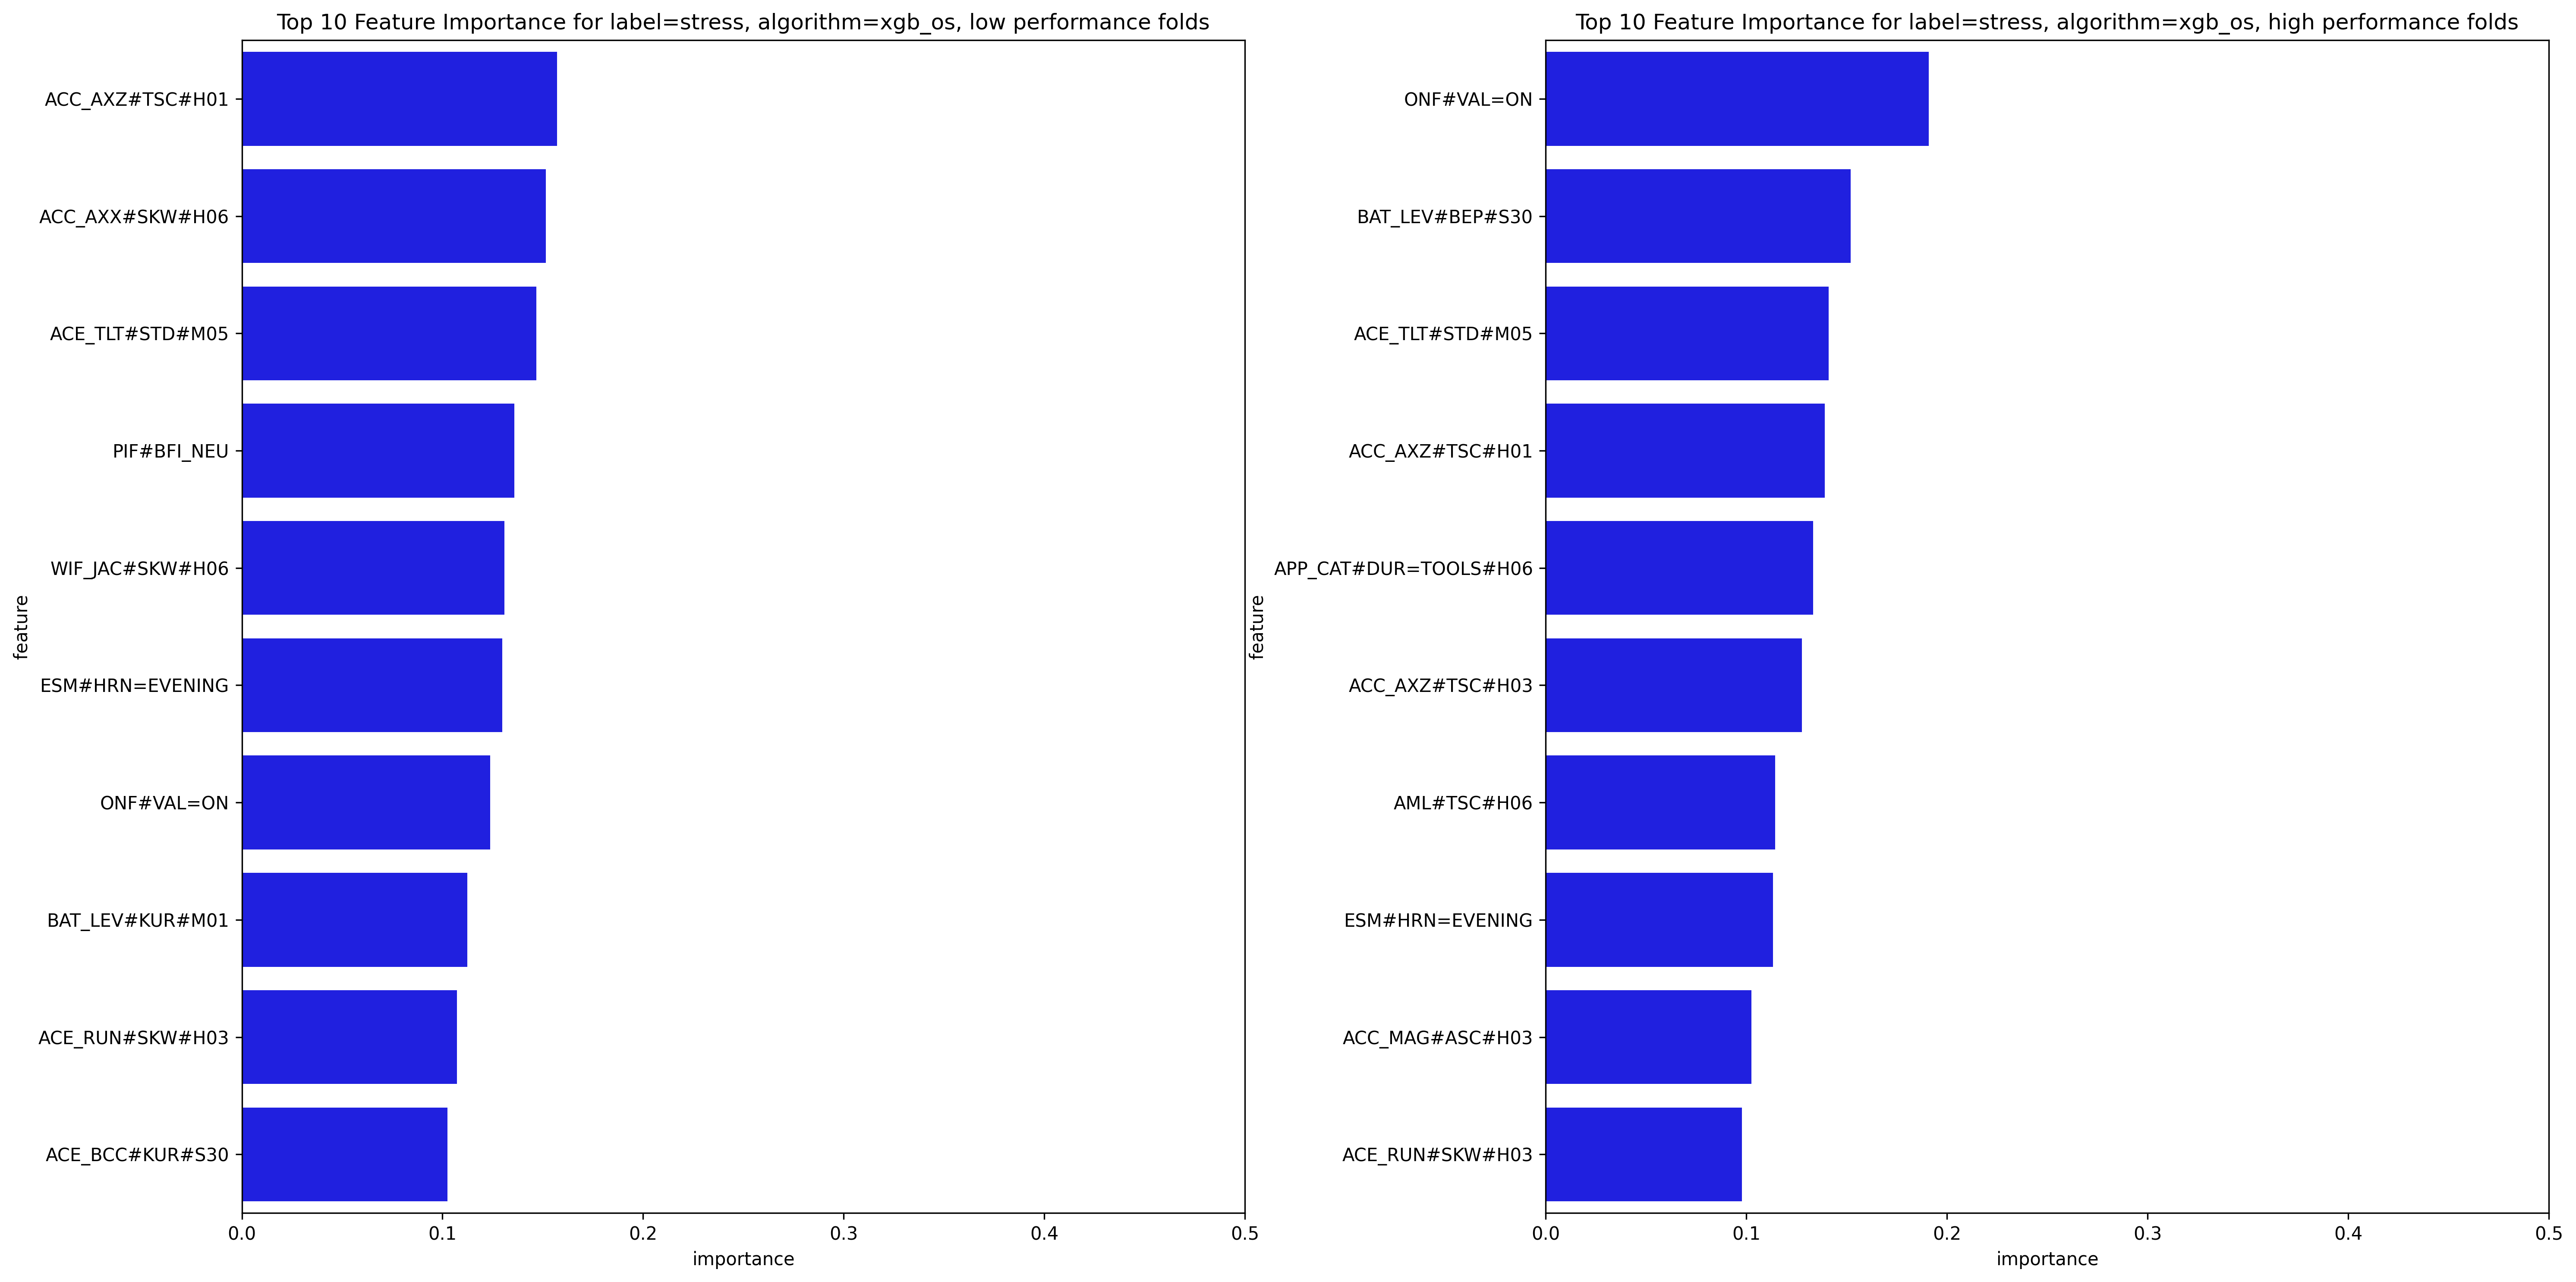

In [77]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 10), dpi=300)

for (l, alg), df in IMPORTANCE_SUMMARY_xgb_os_low_performance.groupby(['label', 'alg']):
    # Aggregate the importance scores across folds and get top 10 features
    df_agg = df.groupby('feature')['importance'].mean().reset_index()
    df_agg_top10 = df_agg.sort_values(by='importance', ascending=False).head(10)

    sns.barplot(data=df_agg_top10, x='importance', y='feature', color='b', ax=axs[0])
    axs[0].set_title(f'Top 10 Feature Importance for label={l}, algorithm={alg}, low performance folds')
    axs[0].set_xlim([0, 0.5])

for (l, alg), df in IMPORTANCE_SUMMARY_xgb_os_high_performance.groupby(['label', 'alg']):
    # Aggregate the importance scores across folds and get top 10 features
    df_agg = df.groupby('feature')['importance'].mean().reset_index()
    df_agg_top10 = df_agg.sort_values(by='importance', ascending=False).head(10)

    sns.barplot(data=df_agg_top10, x='importance', y='feature', color='b', ax=axs[1])
    axs[1].set_title(f'Top 10 Feature Importance for label={l}, algorithm={alg}, high performance folds')
    axs[1].set_xlim([0, 0.5])

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()


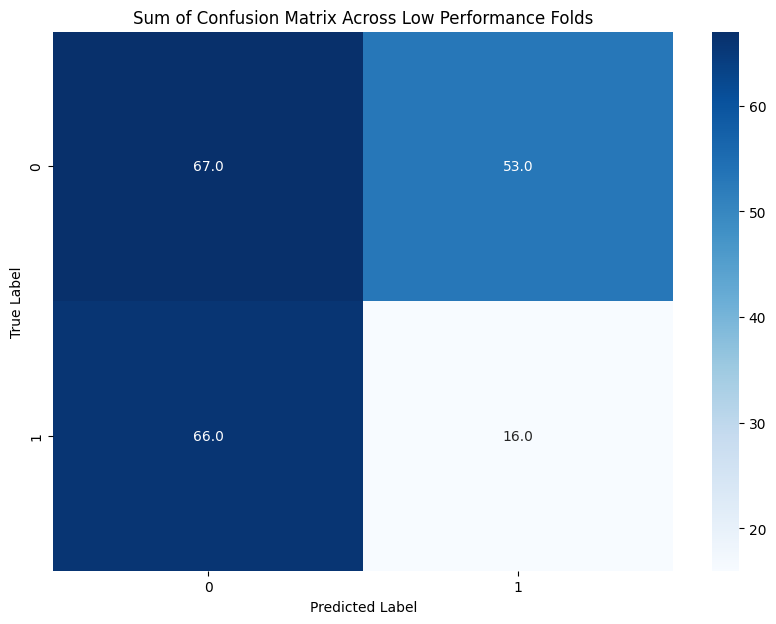

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming `df` is your DataFrame
df_confusion_matrix = RESULTS_xgbos[RESULTS_xgbos['split'].isin(uid_low_performance)][['split', 'test_true_0_pred_0',
       'test_true_0_pred_1', 'test_true_1_pred_0', 'test_true_1_pred_1']].set_index('split')

# Calculate the mean of confusion matrix values across all folds
mean_confusion_matrix = df_confusion_matrix.sum()

# Convert the mean values into a 2x2 confusion matrix
matrix = mean_confusion_matrix.values.reshape(2, 2)

# Plot the averaged confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt=".1f", cmap='Blues')
plt.title("Sum of Confusion Matrix Across Low Performance Folds")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

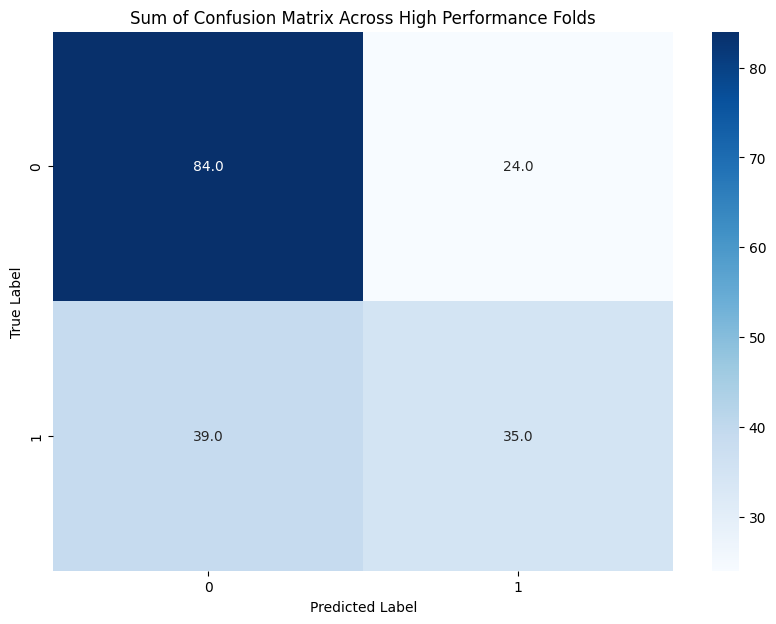

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming `df` is your DataFrame
df_confusion_matrix = RESULTS_xgbos[RESULTS_xgbos['split'].isin(uid_high_performance)][['split', 'test_true_0_pred_0',
       'test_true_0_pred_1', 'test_true_1_pred_0', 'test_true_1_pred_1']].set_index('split')

# Calculate the mean of confusion matrix values across all folds
mean_confusion_matrix = df_confusion_matrix.sum()

# Convert the mean values into a 2x2 confusion matrix
matrix = mean_confusion_matrix.values.reshape(2, 2)

# Plot the averaged confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt=".1f", cmap='Blues')
plt.title("Sum of Confusion Matrix Across High Performance Folds")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Label Value Time Series Visualization

In [80]:
df = LABELS_PROC[['stress']].reset_index()

In [81]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np


# Create a list of unique users
users = df['pcode'].unique()

# Create an empty list to store traces for each user, mean lines, and zero lines
traces = []

# Create a trace for each user's time series and calculate mean value for each user
for user in users:
    user_data = df[df['pcode'] == user]
    mean_value = user_data['stress'].mean()
    trace = go.Scatter(
        x=user_data['timestamp'],
        y=user_data['stress'],
        name=user,
        mode='markers+text',
        marker=dict(size=8, line=dict(width=1), color='blue'),
        text=user_data['stress'].astype(str),
        textposition='top center',
        textfont=dict(size=12)
    )
    traces.append(trace)
    mean_line = go.Scatter(
        x=user_data['timestamp'],
        y=[mean_value] * len(user_data['timestamp']),
        mode='lines',
        name=f'Mean ({user})'
    )
    traces.append(mean_line)
    zero_line = go.Scatter(
        x=user_data['timestamp'],
        y=[0] * len(user_data['timestamp']),
        mode='lines',
        name=f'Zero ({user})'
    )
    traces.append(zero_line)

# Create the layout for the plot
layout = go.Layout(
    title='Time Series Visualization',
    xaxis=dict(title='Timestamp'),
    yaxis=dict(title='Stress', range=[-4, 4])  # Set the desired range for the y-axis
)

# Create the figure with data and layout
fig = go.Figure(data=traces, layout=layout)

# Create the dropdown menu
buttons = []
for user in users:
    button = dict(
        label=user,
        method='update',
        args=[{'visible': [user in trace.name for trace in traces]}]
    )
    buttons.append(button)

updatemenus = list([
    dict(
        buttons=buttons,
        direction='down',
        active=0,
        showactive=True
    )
])

# Update the figure layout with the dropdown menu
fig.update_layout(updatemenus=updatemenus)

# Show the interactive plot
fig.show()


In [82]:
#The following code is designed for reordering for the sake of time series split
#################################################
df = LABELS_PROC[['stress']].reset_index()
# Normalize the datetime for each user
# df['datetime'] = df.groupby('user_id')['datetime'].transform(lambda x: x - x.min())
df['timestamp'] = df.groupby('pcode')['timestamp'].transform(lambda x: x - x.min().normalize())

# Sort the DataFrame by datetime
df = df.sort_values(by=[ 'timestamp'])
random_timestamp = pd.datetime(year=1970, month=1, day=1, hour=1)
df['timestamp'] = df['timestamp'] + random_timestamp

/tmp/ipykernel_123273/490817896.py:10: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [83]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Create a list of unique users
users = df['pcode'].unique()

# Create an empty list to store traces for each user
traces = []

# Create a trace for each user's time series
for user in users:
    user_data = df[df['pcode'] == user]
    trace = go.Scatter(
        x=user_data['timestamp'],
        y=user_data['stress'],
        name=user,
        mode='markers+text',
        marker=dict(size=8, line=dict(width=1), color='blue'),
        text=user_data['stress'].astype(str),
        textposition='top center',
        textfont=dict(size=12)
    )
    traces.append(trace)

# Calculate the overall mean value for all users
mean_value = np.mean(df['stress'])

# Create traces for the mean value line and the horizontal line at 0 for all users
mean_line = go.Scatter(
    x=df['timestamp'],
    y=[mean_value] * len(df['timestamp']),
    mode='lines',
    name='Mean (All Users)'
)
zero_line = go.Scatter(
    x=df['timestamp'],
    y=[0] * len(df['timestamp']),
    mode='lines',
    name='Zero (All Users)'
)

traces.append(mean_line)
traces.append(zero_line)

# Create the layout for the plot
layout = go.Layout(
    title='Time Series Visualization',
    xaxis=dict(title='Timestamp'),
    yaxis=dict(title='Stress', range=[-4, 4])
)

# Create the figure with data and layout
fig = go.Figure(data=traces, layout=layout)

# Show the interactive plot
fig.show()

In [84]:
#The following code is designed for reordering for the sake of time series split
#################################################
df = LABELS_PROC[['stress']].reset_index()
df = df[df['pcode'].isin(uid_low_performance)]
# Normalize the datetime for each user
# df['datetime'] = df.groupby('user_id')['datetime'].transform(lambda x: x - x.min())
df['timestamp'] = df.groupby('pcode')['timestamp'].transform(lambda x: x - x.min().normalize())

# Sort the DataFrame by datetime
df = df.sort_values(by=[ 'timestamp'])
random_timestamp = pd.datetime(year=1970, month=1, day=1, hour=1)
df['timestamp'] = df['timestamp'] + random_timestamp

/tmp/ipykernel_123273/473884817.py:11: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [85]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np


# Create a list of unique users
users = df['pcode'].unique()

# Create an empty list to store traces for each user, mean lines, and zero lines
traces = []

# Create a trace for each user's time series and calculate mean value for each user
for user in users:
    user_data = df[df['pcode'] == user]
    mean_value = user_data['stress'].mean()
    trace = go.Scatter(
        x=user_data['timestamp'],
        y=user_data['stress'],
        name=user,
        mode='markers+text',
        marker=dict(size=8, line=dict(width=1), color='blue'),
        text=user_data['stress'].astype(str),
        textposition='top center',
        textfont=dict(size=12)
    )
    traces.append(trace)
    mean_line = go.Scatter(
        x=user_data['timestamp'],
        y=[mean_value] * len(user_data['timestamp']),
        mode='lines',
        name=f'Mean ({user})'
    )
    traces.append(mean_line)
    zero_line = go.Scatter(
        x=user_data['timestamp'],
        y=[0] * len(user_data['timestamp']),
        mode='lines',
        name=f'Zero ({user})'
    )
    traces.append(zero_line)

# Create the layout for the plot
layout = go.Layout(
    title='Time Series Visualization',
    xaxis=dict(title='Timestamp'),
    yaxis=dict(title='Stress', range=[-4, 4])  # Set the desired range for the y-axis
)

# Create the figure with data and layout
fig = go.Figure(data=traces, layout=layout)

# Create the dropdown menu
buttons = []
for user in users:
    button = dict(
        label=user,
        method='update',
        args=[{'visible': [user in trace.name for trace in traces]}]
    )
    buttons.append(button)

updatemenus = list([
    dict(
        buttons=buttons,
        direction='down',
        active=0,
        showactive=True
    )
])

# Update the figure layout with the dropdown menu
fig.update_layout(updatemenus=updatemenus)

# Show the interactive plot
fig.show()


In [86]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Create a list of unique users
users = df['pcode'].unique()

# Create an empty list to store traces for each user
traces = []

# Create a trace for each user's time series
for user in users:
    user_data = df[df['pcode'] == user]
    trace = go.Scatter(
        x=user_data['timestamp'],
        y=user_data['stress'],
        name=user,
        mode='markers+text',
        marker=dict(size=8, line=dict(width=1), color='blue'),
        text=user_data['stress'].astype(str),
        textposition='top center',
        textfont=dict(size=12)
    )
    traces.append(trace)

# Calculate the overall mean value for all users
mean_value = np.mean(df['stress'])

# Create traces for the mean value line and the horizontal line at 0 for all users
mean_line = go.Scatter(
    x=df['timestamp'],
    y=[mean_value] * len(df['timestamp']),
    mode='lines',
    name='Mean (All Users)'
)
zero_line = go.Scatter(
    x=df['timestamp'],
    y=[0] * len(df['timestamp']),
    mode='lines',
    name='Zero (All Users)'
)

traces.append(mean_line)
traces.append(zero_line)

# Create the layout for the plot
layout = go.Layout(
    title='Time Series Visualization',
    xaxis=dict(title='Timestamp'),
    yaxis=dict(title='Stress', range=[-4, 4])
)

# Create the figure with data and layout
fig = go.Figure(data=traces, layout=layout)

# Show the interactive plot
fig.show()

In [87]:
#The following code is designed for reordering for the sake of time series split
#################################################
df = LABELS_PROC[['stress']].reset_index()
df = df[df['pcode'].isin(uid_high_performance)]
# Normalize the datetime for each user
# df['datetime'] = df.groupby('user_id')['datetime'].transform(lambda x: x - x.min())
df['timestamp'] = df.groupby('pcode')['timestamp'].transform(lambda x: x - x.min().normalize())

# Sort the DataFrame by datetime
df = df.sort_values(by=[ 'timestamp'])
random_timestamp = pd.datetime(year=1970, month=1, day=1, hour=1)
df['timestamp'] = df['timestamp'] + random_timestamp

/tmp/ipykernel_123273/988886537.py:11: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [88]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np


# Create a list of unique users
users = df['pcode'].unique()

# Create an empty list to store traces for each user, mean lines, and zero lines
traces = []

# Create a trace for each user's time series and calculate mean value for each user
for user in users:
    user_data = df[df['pcode'] == user]
    mean_value = user_data['stress'].mean()
    trace = go.Scatter(
        x=user_data['timestamp'],
        y=user_data['stress'],
        name=user,
        mode='markers+text',
        marker=dict(size=8, line=dict(width=1), color='blue'),
        text=user_data['stress'].astype(str),
        textposition='top center',
        textfont=dict(size=12)
    )
    traces.append(trace)
    mean_line = go.Scatter(
        x=user_data['timestamp'],
        y=[mean_value] * len(user_data['timestamp']),
        mode='lines',
        name=f'Mean ({user})'
    )
    traces.append(mean_line)
    zero_line = go.Scatter(
        x=user_data['timestamp'],
        y=[0] * len(user_data['timestamp']),
        mode='lines',
        name=f'Zero ({user})'
    )
    traces.append(zero_line)

# Create the layout for the plot
layout = go.Layout(
    title='Time Series Visualization',
    xaxis=dict(title='Timestamp'),
    yaxis=dict(title='Stress', range=[-4, 4])  # Set the desired range for the y-axis
)

# Create the figure with data and layout
fig = go.Figure(data=traces, layout=layout)

# Create the dropdown menu
buttons = []
for user in users:
    button = dict(
        label=user,
        method='update',
        args=[{'visible': [user in trace.name for trace in traces]}]
    )
    buttons.append(button)

updatemenus = list([
    dict(
        buttons=buttons,
        direction='down',
        active=0,
        showactive=True
    )
])

# Update the figure layout with the dropdown menu
fig.update_layout(updatemenus=updatemenus)

# Show the interactive plot
fig.show()


In [89]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Create a list of unique users
users = df['pcode'].unique()

# Create an empty list to store traces for each user
traces = []

# Create a trace for each user's time series
for user in users:
    user_data = df[df['pcode'] == user]
    trace = go.Scatter(
        x=user_data['timestamp'],
        y=user_data['stress'],
        name=user,
        mode='markers+text',
        marker=dict(size=8, line=dict(width=1), color='blue'),
        text=user_data['stress'].astype(str),
        textposition='top center',
        textfont=dict(size=12)
    )
    traces.append(trace)

# Calculate the overall mean value for all users
mean_value = np.mean(df['stress'])

# Create traces for the mean value line and the horizontal line at 0 for all users
mean_line = go.Scatter(
    x=df['timestamp'],
    y=[mean_value] * len(df['timestamp']),
    mode='lines',
    name='Mean (All Users)'
)
zero_line = go.Scatter(
    x=df['timestamp'],
    y=[0] * len(df['timestamp']),
    mode='lines',
    name='Zero (All Users)'
)

traces.append(mean_line)
traces.append(zero_line)

# Create the layout for the plot
layout = go.Layout(
    title='Time Series Visualization For High Performance Users',
    xaxis=dict(title='Timestamp'),
    yaxis=dict(title='Stress', range=[-4, 4])
)

# Create the figure with data and layout
fig = go.Figure(data=traces, layout=layout)

# Show the interactive plot
fig.show()